In [2]:
import pandas as pd
import csv
import os

import linecache
import sys

import matplotlib.pyplot as plt
import math
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.graph_objs as go

from prettytable import PrettyTable

#簡轉繁用 
#https://pypi.python.org/pypi/hanziconv/0.2.1
from hanziconv import HanziConv 

import matplotlib_venn 
from matplotlib_venn import venn2, venn2_circles


import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from numpy import mean, sqrt, square, arange

import pickle

import random
import datetime


In [3]:
def character_to_index(name,n):
    if n==1:
        if name[0] in Totalname_list:
            return Totalname_list.index(name[0])
        else:
            Totalname_list.append(name[0])
            return Totalname_list.index(name[0])
    if n==2 and len(name)==2:
        if name[1] in Totalname_list:
            return Totalname_list.index(name[1])
        else:
            Totalname_list.append(name[1])
            return Totalname_list.index(name[1])
    return -1


In [1]:
from mylib.PrintException  import PrintException
from mylib.is_chinese import is_chinese
from mylib.is_number import is_number
from mylib.Taiwan_name_seperate import is_biFirstName


In [5]:
from mylib.name_clean import get_error


In [2]:
#丟掉有亂碼的名字
Error_character = ['','ˉ','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','ㄧ','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','．','','','','','','','','','','','','','','','','','','','','','','','','＋','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','ㄙ','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','ㄏ','','','','','','ㄎ','','','','','','','','','','','','','','','','','','','','','','','','','','','','ㄗ','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','‧','','','','','','','','','','','','','','.','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','W','T','F','　','c','D','1','4','','?','/','？','','','','','','','','','','','','�','','','х','','ょ','','ㄧ',')','𦭳','Ｘ','!',
                   'X','	','＠','>','','：','\'']
def get_error(name):
    for c in name:
        if c in Error_character:
            return True
    return False

def name_contain_rare_character(name):
    for c in name:
        if is_chinese(c)==False and c not in moe_data_dict:
            return False
    return True

def clean_name_df(name_df):
    name_df['message'] = name_df.message.apply(lambda x: int(x) )
    name_df = name_df [ name_df.name.apply(lambda x: (type(x)!=float)) ]
    
    #Drop not Chinese Name if length >= 5 character 
    #名字字長五字起跳的全部不是正常漢語名字
    ori_length = len(name_df)
    name_df = name_df [ name_df.name.apply(lambda x: len(x)<5) ]
    print("Drop not Chinese Name, too long:",ori_length,'->',len(name_df),'\tDrop:',ori_length - len(name_df))

    ori_length = len(name_df)
    name_df  = name_df[name_df.name.apply(lambda x: get_error(x)==False)]
    print("Drop Name has error character:",ori_length,'->',len(name_df),'\tDrop:',ori_length - len(name_df))

    name_df['LastName'] = name_df.name.apply(lambda x: (GetLastName(x)))
    name_df['FirstName'] = name_df.name.apply(lambda x: (GetFirstName(x)))
    
    #名有3個長的通常是怪怪的名字
    ori_length = len(name_df)
    name_df = name_df [ name_df.FirstName.apply(lambda x: len(x)<3)]
    print("Drop too long last name:",ori_length,'->',len(name_df),'\tDrop:',ori_length - len(name_df))

    #丟掉不在字典內出現的稀有字
    ori_length = len(name_df)
    name_df = name_df [ name_df.name.apply(lambda x: name_contain_rare_character(x))]
    print("Drop name too rare character:",ori_length,'->',len(name_df),'\tDrop:',ori_length - len(name_df))
    
    return name_df

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def dataset_statistics(dataset):
    """
    Basic statistics of the dataset
    :param dataset: Pandas dataframe
    :return: None, print the basic statistics of the dataset
    """
    print (dataset.describe())
    
#http://dataaspirant.com/2017/06/26/random-forest-classifier-python-scikit-learn/
#Split train and test
def split_dataset(dataset, train_percentage, feature_headers, target_header):
    """
    Split the dataset with train_percentage
    :param dataset:
    :param train_percentage:
    :param feature_headers:
    :param target_header:
    :return: train_x, test_x, train_y, test_y
    """

    # Split dataset into train and test dataset
    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers], dataset[target_header],
                                                        train_size=train_percentage)
    return train_x, test_x, train_y, test_y

def random_forest_classifier(features, target):
    """
    To train the random forest classifier with features and target data
    :param features:
    :param target:
    :return: trained random forest classifier
    """
    clf = RandomForestClassifier(n_estimators=256,n_jobs=3)
    clf.fit(features, target)
    return clf


In [7]:
def basic_RFClassifier(data_df,x_feature,y_feature,Validation_times):

    #N fold cross-validation
    Train_accuracy_score=0
    Test_accuracy_score=0
    
    importances_list = []
    for i in range(Validation_times):
        train_x, test_x, train_y, test_y = split_dataset(data_df, 0.7, x_feature, y_feature)
        
        # Create random forest classifier instance
        trained_model = random_forest_classifier(train_x, train_y)


        predictions = trained_model.predict(test_x)

        # Train and Test Accuracy
        if(Validation_times!=1):
            print('Run times:',i+1)
        print ("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x)))
        print ("Test Accuracy  :: ", accuracy_score(test_y, predictions))
        #print (" Confusion matrix\n ", confusion_matrix(test_y, predictions))

        Train_accuracy_score+=accuracy_score(train_y, trained_model.predict(train_x))
        Test_accuracy_score+= accuracy_score(test_y, predictions)
#         calculate_error( predictions, test_y )
        
    
        #validate_error( predictions,data_df, test_y,test_x )
        
        importances = trained_model.feature_importances_
        importances_list.append(importances)
        #indices = np.argsort(importances)
        print('Feature Importances')
 
        print(x_feature)
        print(importances)
        plt.title('Feature Importances')
        plt.barh(range(len(importances)), importances, color='b', align='center')
        plt.yticks(range(len(importances)), x_feature) ## removed [indices]
        plt.xlabel('Relative Importance')
        plt.show()
        
    if(Validation_times!=1):
        Train_accuracy_score/=Validation_times
        Test_accuracy_score/=Validation_times
        print ("Average Train Accuracy :: ", Train_accuracy_score)
        print ("Average Test Accuracy  :: ",Test_accuracy_score)
        print(importances_list)
    return trained_model

In [8]:
#印出猜錯的年齡和實際年齡差距,算絕對值的差
#印出Test data的INDEX
#print(test_x.iloc[0].name)
#iloc[0].name是印第一列的編號名字
#loc[123].name會印編號名字123的編號名字，嗯，就是123
#用Total_df.loc[index]可以印該編號名字的那列....好像有重複的編號名字

#

def calculate_error(predictions,test_y):
    Error = 0
    list_y = list(test_y)
    
    for i in range(0, len( predictions)):
        if(list_y[i]!= predictions[i]):
            #index = test_x.iloc[i].name
            #print( 'Name:', Totalname_list[ int( test_x.iloc[i]['FN1'])] ,Totalname_list [ int(test_x.iloc[i]['FN2']) ])
            #print( 'BirthYear:',list_y[i],str(list_y[i]*5+1940))
            #print('Predicted outcome:',predictions[i],str(predictions[i]*5+1940))

            Error+= abs(list_y[i]-predictions[i])
            
    print('平均絕對值誤差：',Error/len(predictions))
    print('RMSE:',sqrt(mean_squared_error(list_y,predictions)))

def validate_error(predictions,data_df,test_y,test_x):
    validation_list = []
    #list_y = list(test_y)
#     for i in range(10):
#         validation_list.append( random.randint( 0,len( predictions)) )
    #print(len(list_y),len(predictions))
    for i in range(0, len( predictions)):
            #if i in validation_list:
            if predictions[i]!=test_y.iloc[i].mgender:
                df_index =  test_x.iloc[i].name
                name = data_df.loc[df_index].FirstName

                #print("Name:",Totalname_list[ int ( test_x.iloc[i].FN1)],Totalname_list[ int(test_x.iloc[i].FN2)])
                print('Name',name)
                if 'GuessedGender' in test_x.columns.values:
                    print('Gender:',test_x.iloc[i].GuessedGender)
                    
                if test_y.iloc[i].mgender=='0':
                    answer='女'
                else:
                    answer='男'
                if predictions[i]=='0':
                    predict = '女'
                else:
                    predict='男'
                #print('answer:',test_y.iloc[i].mgender,'Classfier result:',predictions[i])
                print('answer:',answer,'Classfier result:',predict)

                
def calculate_errorr_multi_answer(predictions,test_x,name_dict_list,data_df):
    Error = 0
    Min_error_answer_list = []
    
    #print(test_x.iloc[0].name)
    for index,year in enumerate(predictions):
#         df_index =  test_x.iloc[index].name
#         name = data_df.loc[df_index].FirstName
        
        name = Totalname_list[ int ( test_x.iloc[index].FN1)]+Totalname_list[ int(test_x.iloc[index].FN2)]

        
        if name in name_dict_list:
            if year not in name_dict_list[name]:
                smallest_dist = 99
                min_error_answer=0
                for answer in (name_dict_list[name]):
                    dist = abs(answer - predictions[index])
                    if(dist<smallest_dist):
                        smallest_dist=dist
                        min_error_answer=answer

                Error+=smallest_dist
                Min_error_answer_list.append(min_error_answer)
            else:
                Min_error_answer_list.append(year)
            
        else:
            print('WTF')
            print('1',df_index)
            print('2',name,test_x.iloc[index])
            print('3',data_df.loc[df_index])

         
    print('平均絕對值誤差：',round(Error/len(predictions),4))
    print('RMSE:',round(sqrt(mean_squared_error(Min_error_answer_list,predictions)),4))
    
def validate_error_multi_answer(predictions,data_df,test_y,test_x,name_dict_list):
    validation_list = []
    list_y = list(test_y)
    for i in range(10):
        validation_list.append( random.randint( 0,len( predictions)) )
        
    for index,year in enumerate(predictions):
            if index in validation_list:
                df_index =  test_x.iloc[index].name
                name = data_df.loc[df_index].FirstName

                #name = Totalname_list[ int ( test_x.iloc[index].FN1)]+Totalname_list[ int(test_x.iloc[index].FN2)]
                if name in name_dict_list:
                    print("Name:",name)
                    if 'GuessedGender' in test_x.columns.values:
                        print('Gender:',test_x.iloc[i].GuessedGender)
                    print('answer:',name_dict_list[name],'Classifier result:',predictions[index])
                    

In [9]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

from imblearn.ensemble import BalanceCascade

In [11]:
with open('./data_output/final/specail_word_dict.txt', 'rb') as handle:
    specail_word_dict = pickle.loads(handle.read())
    
with open('./data_output/final/moe_additional_dict.txt', 'rb') as handle:
    moe_additional_dict = pickle.loads(handle.read())

with open('./data_output/final/radical_list.txt', 'rb') as handle:
    radical_list = pickle.loads(handle.read())

with open('./data_output/final/Totalname_list.txt', 'rb') as handle:
    Totalname_list = pickle.loads(handle.read())
    
with open('./data_output/final/son_in_list.txt', 'rb') as handle:
    son_in_list = pickle.loads(handle.read())
    
with open('./data_output/final/moe_data_dict.txt', 'rb') as handle:
    moe_data_dict = pickle.loads(handle.read())
    
with open('./data_output/final/mu_in_list.txt', 'rb') as handle:
    mu_in_list = pickle.loads(handle.read())

In [9]:
with open('./data_output/final/prob/gender_x_feature', 'rb') as handle:
    x_feature = pickle.loads(handle.read())

In [20]:
import pickle
filename = './data_output/final/gender_predicton_model.sav'
gender_predicton_model2 = pickle.load(open(filename, 'rb'))

In [10]:
filename = './data_output/final/prob/gender_predicton_model.sav'
gender_predicton_model = pickle.load(open(filename, 'rb'))

In [15]:
def add_radical_column(character):
    term = Totalname_list[character]
    if term in moe_data_dict:
        #print(term,moe_data_dict[term]['radical'])
        return moe_data_dict[term]['radical'] 
    elif term in specail_word_dict :
        return specail_word_dict[term]['radical']  
    
def add_radical_index_column(radical):
    if radical in radical_list:
        return radical_list.index(radical)
    else:
        #print(radical)
        return -1
    

In [16]:
def add_pin_in_column(character, mode):
    #mode 1 = sonin
    #mode 2 = muin
    if character==-1:
        return None
    specail_word_pinyin_dic = {'艶':'yàn' ,'鳯':'fèng','恵':'huì','姈':'líng','寳':'bǎo','姫':'jī','鑅':'róng',
                              "玂":"qí","浤":"hóng",'煊':'xuān','斔':'zhōng','琜':'lái','苰':'hóng','玹':'xuán','姵':'pèi','妏':'wèn',
'妘':'yún','珺':'jùn','媗':'xuān','彣':'wén','玹':'xuán','瀞':'jìng','妡':'xīn','琁':'xuán','浤':'hóng','緁':'jī',
'媜':'zhēng','姸':'yán','嬅':'huà','眞':'zhēn','廼':'nǎi','寛':'kuān','秝':'lì','蕥':'yǎ','汯':'hóng','逹':'dá','萓':'yí',
'媃':'róu','孋':'lí','媁':'wěi','祤':'yǔ','媄':'měi','夆':'fēng','蒝':'yuán','嬣':'níng','砡':'yù','芠':'wén',
'姳':'mǐng','蔆':'líng','菈':'lā','鍹':'xuān','榳':'tíng','錤':'jī','憓':'huì','潓':'huì','瓈':'lí','芛':'wěi',
'峮':'qún','鋕':'zhì','姷':'yòu','兪':'yú','瑠':'liú','嫙':'xuán','珅':'shēn','暟':'kǎi','斈':'xué','煐':'yīng','淓':'fāng','瑨':'jìn','嬨':'cí','琹':'qín','珆':'yí','琣':'pěi',
'娪':'wú','荺':'yǔn','爕':'xiè','玶':'píng','鋆':'yún','愼':'shèn','斳':'qín','瑈':'róu','澪':'líng','珦':'xiàng','妶':'xián','姃':'zhēng','薾':'ěr','溎':'guì','琄':'xuàn','琡':'shū','瑭':'táng','嫆':'róng'
                              }
    term = Totalname_list [character ]
    try:
        if term not in moe_data_dict:
            term = HanziConv.toTraditional(term)
            
        if term in moe_data_dict:
#            pin_yin_list = []
#             if len( moe_data_dict[term]['heteronyms'])>1:
#                 for hete in moe_data_dict[term]['heteronyms']:
#                     if 'pinyin' in hete and  moe_data_dict[term]['title']!='啐':
#                         if 'pinyin' not in pin_yin_list and  '（' not  in (hete['pinyin']):
#                             pin_yin_list.append(hete['pinyin'])
            
#             if len(pin_yin_list)>1:
#                 for word_p in pin_yin_list:
#                             #word_p = hete['pinyin']
#                             #if '（' not  in (word_p) and moe_data_dict[term]['title']!='啐': 
#                         for mu in mu_in_list:
#                             if mu in word_p:
#                                 if mode=='sonin':
#                                     #print(word_p[: word_p.index(mu)])
#                                     print('字：',moe_data_dict[term]['title'],'拼音：',word_p)
#                                     #return word_p[: word_p.index(mu)]
#                                     break
#                                 else:
#                                     return mu

            for hete in moe_data_dict[term]['heteronyms']:
                if 'pinyin' in hete and  moe_data_dict[term]['title']!='啐':
                    word_p = hete['pinyin']
                    
                    if '（'  in (hete['pinyin']):
                        if '（讀音）' in hete['pinyin']:
                            word_p = hete['pinyin'].replace('（讀音）','')
                        if '（語音）' in hete['pinyin']:
                            word_p = hete['pinyin'].replace('（語音）','')   
                        if '(' in word_p:
                            print(word_p+"!!")  

                            
                    for mu in mu_in_list:
                        if mu in word_p:
                            if mode=='sonin':
                                return word_p[: word_p.index(mu)]
                            else:
                                return mu                                    
            #找不到字音，看是否是哪個字的異體字
            for hete in moe_data_dict[term]['heteronyms']:
                for define in hete['definitions']:
                    if '異體字' in define['def']:
                        d =  define['def']
                        alt_term = d[  d.index('「')+1 : d.index('」') ]
                        #print(alt_term,term)
                        
                        for hete2 in moe_data_dict[alt_term]['heteronyms']:
                            if 'pinyin' in hete2 and  moe_data_dict[alt_term]['title']!='啐':
                                
                                word_p = hete2['pinyin']
                                if '（'  in (hete2['pinyin']):
                                    if '（讀音）' in hete2['pinyin']:
                                        word_p = hete2['pinyin'].replace('（讀音）','')
                                    if '（語音）' in hete2['pinyin']:
                                        word_p = hete2['pinyin'].replace('（語音）','')   
                                    if '(' in word_p:
                                        print(word_p+"!!")
                                    
                                for mu in mu_in_list:
                                    if mu in word_p:
                                        if mode=='sonin':
                                            return word_p[: word_p.index(mu)]
                                        else:
                                            return mu     
            #print('在字典內但沒有拼音：',term)
        else:
            #print('不在字典內：',term)
            
            if term in specail_word_dict:
                word_p = specail_word_dict[term]['pinyin']
                for mu in mu_in_list:
                    if mu in word_p:
                        if mode=='sonin':
                            return word_p[: word_p.index(mu)]
                        else:
                            return mu   
            else:
                #print('拼音不明：',term)
                if term not in unkown_dict:
                    unkown_dict[term]=1
                else:
                    unkown_dict[term]+=1

#             if len( moe_df[moe_df.字詞名.apply(lambda x: x==term)])>0:
#                 print('不在字典內：',term)
    except Exception as e:
        print (e)
        PrintException() 
        

In [17]:
def add_pin_in_index_column(pin_yin, mode):
    #mode 1 = sonin
    #mode 2 = muin
    if pin_yin ==None:
        return -1
    try:
        if mode =='muin':
            return mu_in_list.index(pin_yin)
        
        if mode == 'sonin':
            if pin_yin in son_in_list:
                return son_in_list.index(pin_yin)
            else:
                print(pin_yin)

    except Exception as e:
        print (e)
        print (fileName)
        PrintException() 

In [21]:
def GuessGender(name):
    name = '蕭'+name
    name_df = pd.DataFrame()
    name_df['name'] = [ name]


    name_df['LastName'] = name_df.name.apply(lambda x: (GetLastName(x)))
    name_df['FirstName'] = name_df.name.apply(lambda x: (GetFirstName(x)))
    name_df['FN1'] = name_df.FirstName.apply(lambda x: character_to_index(x,1))
    name_df['FN2'] = name_df.FirstName.apply(lambda x: character_to_index(x,2))

    name_df['FN1_sonin'] = name_df.FN1.apply(lambda x:  add_pin_in_column(x,'sonin') )
    name_df['FN1_muin'] = name_df.FN1.apply(lambda x:  add_pin_in_column(x,'muin') )

    name_df['FN2_sonin'] = name_df.FN2.apply(lambda x:  add_pin_in_column(x,'sonin') )
    name_df['FN2_muin'] = name_df.FN2.apply(lambda x:  add_pin_in_column(x,'muin') )
    name_df['FN1_sonin_index'] = name_df.FN1_sonin.apply(lambda x:  add_pin_in_index_column(x,'sonin') )
    name_df['FN2_sonin_index'] = name_df.FN2_sonin.apply(lambda x:  add_pin_in_index_column(x,'sonin') )

    name_df['FN1_muin_index'] = name_df.FN1_muin.apply(lambda x:  add_pin_in_index_column(x,'muin') )
    name_df['FN2_muin_index'] = name_df.FN2_muin.apply(lambda x:  add_pin_in_index_column(x,'muin') )

    name_df['FN1_radical'] = name_df.FN1.apply(lambda x:add_radical_column(x))
    name_df['FN2_radical'] = name_df.FN2.apply(lambda x:add_radical_column(x))

    name_df['FN1_radical_index'] = name_df.FN1_radical.apply(lambda x:add_radical_index_column(x))
    name_df['FN2_radical_index'] = name_df.FN2_radical.apply(lambda x:add_radical_index_column(x))

    x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index','FN2_muin_index',
                 'FN1_radical_index','FN2_radical_index']
    #x_feature = ['FN1','FN2','FN1_radical_index','FN2_radical_index']
    #print(name_df[x_feature])
    result = gender_predicton_model2.predict(name_df[x_feature])
    print(gender_predicton_model2.predict_proba(name_df[x_feature]))
    if result =='0' or  result ==0:
        print('我猜',name[1:],'是:女生')
    if result =='1' or result ==1:
        print('我猜',name[1:],'是:男生')
    #print(gender_predicton_model.predict(name_df[x_feature]))

In [19]:
Path = './data_output/final/resampled_gender.csv'
resampled_gender = pd.read_csv(Path, dtype='str')

In [111]:
with open('./data_output/final/resampled_gender2.csv', 'wb') as handle:
    pickle.dump(resampled_gender, handle)

In [113]:
with open('./data_output/final/resampled_gender2.csv', 'rb') as handle:
    resampled_gender = pickle.loads(handle.read())

In [114]:
resampled_gender

FirstName LastName gender message name            userID   FN1   FN2  \
0             民任        吳      1    1947  吳民任               NaN   335   297   
1             昭呈        劉      1    1965  劉昭呈               NaN   462   111   
2             恩田        莊      1    1959  莊恩田               NaN    86   202   
3             呈祥        林      1    1951  林呈祥               NaN   111   165   
4             碧山        廖      1    1944  廖碧山               NaN  1287   447   
5             進國        徐      1    1962  徐進國               NaN   474   436   
6             正鎰        林      1    1969  林正鎰               NaN   276  1868   
7             中柱        吳      1    1958  吳中柱               NaN   321  2039   
8             漢瀛        楊      1    1952  楊漢瀛               NaN   575  2353   
9             浚輝        張      1    1994  張浚輝  1742571835772284   502   315   
10            蘭娣        白      1    1993  白蘭娣  1897631213807925  1329  1465   
11            傳懷        陳      1    1964  陳傳懷               NaN   720   930   
12            希宇        陳      1    1962  陳希宇               NaN   610    10   
13            智彭        林      1    1956  林智彭               NaN   336  2104   
14            庭宇        劉      1    1994  劉庭宇  1362260720509643    46    10   
15            宥霖        陳      1    1990  陳宥霖  1540332902646407   558   143   
16            國建        謝      1    1948  謝國建               NaN   436    43   
17            志穎        林      1    1994  林志穎  1682859848409878    68   154   
18            守國        史      1    1947  史守國               NaN   422   436   
19             傑        王      1    2001   王傑  1114345485376859    -1   169   
20            蓬欽        王      1    1958  王蓬欽               NaN  2606  1272   
21            義傑        黃      1    1994  黃義傑  1293926820685819   650   169   
22            楷誌        王      1    1996  王楷誌  1264702423599040    14   220   
23            德興        郭      1    1944  郭德興               NaN   142   504   
24            昭明        陳      1    1926  陳昭明               NaN   462   159   
25            子毅        李      1    2004  李子毅   808085149340727   114    40   
26            惟揚        李      1    1997  李惟揚  1339604809456798   490   110   
27            存隆        何      1    1954  何存隆               NaN   577   141   
28            建璋        吳      1    1984  吳建璋  1458346484237558    43   584   
29            尚正        裘      1    1930  裘尚正               NaN   636   276   
...          ...      ...    ...     ...  ...               ...   ...   ...   
121856        月華        賴      0    1929  賴月華               NaN   706   123   
121857        淑貞        賴      0    1929  賴淑貞               NaN   348   635   
121858        藹楚        錢      0    1929  錢藹楚               NaN  4044   409   
121859        汴宣        鮑      0    1929  鮑汴宣               NaN  4579   253   
121860        筱安        龍      0    1929  龍筱安               NaN    23    20   
121861        美真        戴      0    1929  戴美真               NaN   140   653   
121862        宏弘        謝      0    1929  謝宏弘               NaN    27   385   
121863        素貞        謝      0    1929  謝素貞               NaN   455   635   
121864        麗香        謝      0    1929  謝麗香               NaN   203   341   
121865        秀正        鍾      0    1929  鍾秀正               NaN    70   276   
121866        和美        鍾      0    1929  鍾和美               NaN   122   140   
121867        金妹        鍾      0    1929  鍾金妹               NaN   280   126   
121868        裕美        鍾      0    1929  鍾裕美               NaN   493   140   
121869        燕琴        鍾      0    1929  鍾燕琴               NaN   298   429   
121870        玉英        簡      0    1929  簡玉英               NaN   211   388   
121871        素蘭        簡      0    1929  簡素蘭               NaN   455  1329   
121872        榮昌        藍      0    1929  藍榮昌               NaN     4   369   
121873        惠蓮        顏      0    1929  顏惠蓮               NaN   106   496   
121874        紫玲        羅      0    1929  羅紫玲            

In [13]:
#Real name
#Path = './data_output/final/Real_name_df.csv'
#Path = './data_output/final/0.93/Real_name_df.csv'
# Path = './data_output/final/0.93/resampled_Real_data_df.csv'
# Real_name_df = pd.read_csv(Path, dtype='str')


#FB name
#Path = './data_output/final/cname_df.csv'
#Path = './data_output/final/0.93/cname_df.csv'
Path = './data_output/final/0.93/resampled_FB_data_df.csv'
FB_name_df = pd.read_csv(Path, dtype='str')


#讀取時會預設全部是str tpye，還原所有欄的正確type

# Real_name_df['BirthYear'] = Real_name_df.BirthYear.apply(lambda x: int(x))
# Real_name_df['FN1'] = Real_name_df.FN1.apply(lambda x: int(x))
# Real_name_df['FN2'] = Real_name_df.FN2.apply(lambda x: int(x))
# #Real_name_df['gender'] = Real_name_df.gender.apply(lambda x: int(float(x)))
# Real_name_df['GuessedGender'] = Real_name_df.GuessedGender.apply(lambda x: int(float(x)))
# Real_name_df['FN1_sonin_index'] = Real_name_df.FN1_sonin_index.apply(lambda x: int(x))
# Real_name_df['FN2_sonin_index'] = Real_name_df.FN2_sonin_index.apply(lambda x: int(x))
# Real_name_df['FN1_muin_index'] = Real_name_df.FN1_muin_index.apply(lambda x: int(x))
# Real_name_df['FN2_muin_index'] = Real_name_df.FN2_muin_index.apply(lambda x: int(x))
# Real_name_df['FN1_radical_index'] = Real_name_df.FN1_radical_index.apply(lambda x: int(x))
# Real_name_df['FN2_radical_index'] = Real_name_df.FN2_radical_index.apply(lambda x: int(x))

FB_name_df['BirthYear'] = FB_name_df.BirthYear.apply(lambda x: int(x))
FB_name_df['FN1'] = FB_name_df.FN1.apply(lambda x: int(x))
FB_name_df['FN2'] = FB_name_df.FN2.apply(lambda x: int(x))
FB_name_df['GuessedGender'] = FB_name_df.GuessedGender.apply(lambda x: int(float(x)))
FB_name_df['FN1_sonin_index'] = FB_name_df.FN1_sonin_index.apply(lambda x: int(x))
FB_name_df['FN2_sonin_index'] = FB_name_df.FN2_sonin_index.apply(lambda x: int(x))
FB_name_df['FN1_muin_index'] = FB_name_df.FN1_muin_index.apply(lambda x: int(x))
FB_name_df['FN2_muin_index'] = FB_name_df.FN2_muin_index.apply(lambda x: int(x))
FB_name_df['FN1_radical_index'] = FB_name_df.FN1_radical_index.apply(lambda x: int(x))
FB_name_df['FN2_radical_index'] = FB_name_df.FN2_radical_index.apply(lambda x: int(x))

In [54]:
GuessGender('旭秋')
劉蘭亭、戴雙喜、莊鳥鍛、林幼春、林子瑾

我猜 旭秋 是:女生


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [22]:
GuessGender('柏辰')

[[ 0.  1.]]
我猜 柏辰 是:男生


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [15]:
GuessGender('蘭亭')
GuessGender('雙喜')
GuessGender('鳥鍛')
GuessGender('幼春')
GuessGender('子瑾')
GuessGender('文')

我猜 蘭亭 是:女生
我猜 雙喜 是:女生
我猜 鳥鍛 是:男生
我猜 幼春 是:女生
我猜 子瑾 是:男生
我猜 文 是:男生


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [16]:
GuessGender('梓吟')

我猜 梓吟 是:女生


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



# 以下為資料處理過程

In [4]:
Path = './Total_FBname/name.csv'
#Read gender data
cname_df = pd.read_csv(Path, dtype='str')
cname_df

name message             userID LastName FirstName
0        雷霆    2002   1465701136787816        雷         霆
1       黃海銘    1995   1484433631589977        黃        海銘
2       陳志亮    1986   1328211283930764        陳        志亮
3       林士傑    2001    296012147484045        林        士傑
4       翁玉妹    2003   1895288067372189        翁        玉妹
5       陳巧瓶    1981   1375688302454662        陳        巧瓶
6       林松青    1992   1434724669881548        林        松青
7       王宥勝    1987    770763393073431        王        宥勝
8       趙凱揚    1995   1295109403905407        趙        凱揚
9       宋茜沄    1985   1388946507832568        宋        茜沄
10      羅文泰    1972   1550108411680341        羅        文泰
11      舒子芸    2003   1796381430689469        舒        子芸
12      葉千豪    1987   1414173521972695        葉        千豪
13       伍生    1999   1414155308648948        伍         生
14      林義盛    1986   1048578891941316        林        義盛
15      張家琪    1991   1530311903655556        張        家琪
16       張豪    1997   1498310573577623        張         豪
17      鍾舒涵    1983   1824362987888148        鍾        舒涵
18      賴威龍    1983    477854192605371        賴        威龍
19      林怡廷    2004    191504144677977        林        怡廷
20      顏怡潔    2002    857511391053895        顏        怡潔
21      施孟瑋    1991   1372801542742499        施        孟瑋
22      謝濰謙    1995   1473081852712317        謝        濰謙
23      蔡東翰    1995   1656873247674637        蔡        東翰
24      張俊仁    1997   1241082882665191        張        俊仁
25       尤君    1990   1450388804979446        尤         君
26      張美珍    2002    644509159078343        張        美珍
27      何品萱    1997   1175592212563514        何        品萱
28      林楷森    1996   1389792611042167        林        楷森
29      徐彩騏    1998   1287497291303871        徐        彩騏
...     ...     ...                ...      ...       ...
731060  葉哲勳    1993    135373783743474        葉        哲勳
731061  何冠冠    2008    663809233818202        何        冠冠
731062  邱呈淵    1999   1796707933690667        邱        呈淵
731063  邱佳琪    2005    351041895348477        邱        佳琪
731064   文文    1994   1627415850623340        文         文
731065  吳振宇    1999    803885343108754        吳        振宇
731066  獨愛伱    1996   1847628045255322        獨        愛伱
731067  吳生黴    1993  10154921708526404        吳        生黴
731068  郭政豪    2002    268428420338176        郭        政豪
731069  黃微明    1999    913839378766328        黃        微明
731070   龍氏    1991    804370026412022        龍         氏
731071  顏湘孟    2004    269052463597778        顏        湘孟
731072  蘇子原    2004    321286998333924        蘇        子原
731073  姚建成    1998   1475153592566945        姚        建成
731074  王洛嵐    2002    869236136561686        王        洛嵐
731075  呂學修    1993   1509603699107162        呂        學修
731076  黃淨梅    2000    819266638243405        黃        淨梅
731077  李佩甄    2003    686250614914764        李        佩甄
731078  楊芷妍    2002    262056130954579        楊        芷妍
731079   卓敏    2003    266400523853122        卓         敏
731080  蘭郁玲    1991   1921849904498074        蘭        郁玲
731081  李绍俊    1996    502658706736741        李        绍俊
731082  吳祥嘉    1987   1870681616281658        吳        祥嘉
731083  陳以利    1992   1802015343149713        陳        以利
731084  黄綕佃    1994   1234340960045483        黄        綕佃
731085  夏雨天    2004    161311101115560        夏        雨天
731086  張嘉芮    1998   1452003888226036        張        嘉芮
731087  蘇明傑    2000   1591031004280884        蘇        明傑
731088  黄斤力    1999   1497938720267615        黄        斤力
731089  蔡汰文    2004    167420550494468        蔡        汰文

[731090 rows x 5 columns]

In [5]:
Path = './Total_FBname/gender.csv'
#Read gender data
gcname_df = pd.read_csv(Path, dtype='str')
gcname_df

name message             userID gender LastName FirstName
0      紀登議    1999   2332535790304442      m        紀        登議
1      洗官徽    1986  10212201113333657      m        洗        官徽
2      李榮伍    1992   1457961080894591      m        李        榮伍
3      邱嘉儀    2000   1657180277910074      w        邱        嘉儀
4      李知餘    1994   1955003091452576      m        李        知餘
5      翁宇恆    1996   1468670823153768      m        翁        宇恆
6      曾耀葦    2000   1859800624271989      m        曾        耀葦
7      鄭楷儒    1989   1785207711497026      m        鄭        楷儒
8      盧宜萱    2001   1410782538988183      w        盧        宜萱
9      賴俊瑜    1987   1238911026207407      m        賴        俊瑜
10      紀安    1989   1923728447907286      m        紀         安
11     謝彩廷    2002   1931750973722202      w        謝        彩廷
12     洪筱晴    2005    474340716289988      w        洪        筱晴
13     陳羽柔    1990   1665003263516847      w        陳        羽柔
14     阮宏文    1987   1362759457118836      m        阮        宏文
15     林家生    1984   1620655244617249      m        林        家生
16      卓煌    1985    412117009145643      m        卓         煌
17     陸忠雄    1994   1137440173031386      m        陸        忠雄
18     胡姿姿    1989   1603353663017568      w        胡        姿姿
19     張音音    1989   1480270681994394      w        張        音音
20     林之康    2000    798509310298607      m        林        之康
21      樂迪    2004    279658485779047      w        樂         迪
22     蘇展毅    1994   1486282721396420      m        蘇        展毅
23     陳上禾    1994   1454591434559126      m        陳        上禾
24     陳建銘    1995   1346752628734969      m        陳        建銘
25     徐翊庭    1997   1635057126523947      w        徐        翊庭
26     廖柏勛    1991   1782802728402196      m        廖        柏勛
27     許曜顯    1987    199882073852346      m        許        曜顯
28     陳奕丞    1996    269827300094524      m        陳        奕丞
29     蔡小璟    1978   1654651474550164      w        蔡        小璟
...    ...     ...                ...    ...      ...       ...
68796  吳秀妏    1998   1838745859474338      w        吳        秀妏
68797  林子涵    1994   1766905143349807      w        林        子涵
68798  王姿敏    2006    259368904573241      w        王        姿敏
68799  張瀞尹    2002    675672222643911      w        張        瀞尹
68800  黄綕佃    1994   1234340960045483      m        黄        綕佃
68801  夏雨天    2004    161311101115560      w        夏        雨天
68802  王俊文    2005   1456664891119536      m        王        俊文
68803  郭律瑩    2001   1921193071473400      w        郭        律瑩
68804  林振宇    1986   1923025194689135      m        林        振宇
68805  魏紹宇    1984    881463202016635      w        魏        紹宇
68806  周佳玟    1993   1612259995471777      w        周        佳玟
68807  胡昂万    2005    486061881763200      m        胡        昂万
68808  李筱仪    2005    112785042746282      w        李        筱仪
68809  陳妍婷    1988   1492870120769866      w        陳        妍婷
68810  林智慧    2001    980442625430236      w        林        智慧
68811  張嘉芮    1998   1452003888226036      w        張        嘉芮
68812  梁文祥    2002   1907302859520962      m        梁        文祥
68813   燕子    1998   1465423093513467      w        燕         子
68814  蘇明傑    2000   1591031004280884      m        蘇        明傑
68815  莊雅雯    2005   2199112490315321      w        莊        雅雯
68816  彭嘉俊    2003    276858236130271      m        彭        嘉俊
68817  廖祝儀    2005    346725752422481      w        廖        祝儀
68818  林心卉    2005    862531380571588      w        林        心卉
68819  詹哲維    2005    143511849581021      m        詹        哲維
68820  黄斤力    1999   1497938720267615      m        黄        斤力
68821  吳亭臻    2006    269286546920691      w        吳        亭臻
68822  蔡汰文    2004    167420550494468      m        蔡        汰文
68823  張祐甄    2005   1937189903208880      w        張        祐甄
68824  陳雨涵    2006    749389488582671      w        陳        雨涵
68825  劉思昀    2003   1461152050629940      w        劉        思昀

[68826 rows x 6 columns]

In [355]:
#Read real List
#1976~1994
List_name_df = pd.DataFrame()
List_name_df = pd.read_csv('../C_1994-2012_2/Total_1994-2012_2.csv', dtype='str')
List_name_df = List_name_df [ List_name_df.name.apply(lambda x: (type(x)!=float)) ]
List_name_df = clean_name_df(List_name_df)
List_name_df['message']  = List_name_df.message.apply(lambda x: int(x)-18 )


List_name_df.sample(20)

Drop not Chinese Name, too long: 1336612 -> 1336589 	Drop: 23
Drop Name has error character: 1336589 -> 1335573 	Drop: 1016
Drop too long last name: 1335573 -> 1334759 	Drop: 814
Drop name too rare character: 1334759 -> 1327122 	Drop: 7637


message name LastName FirstName
82802       1987  吳和諺        吳        和諺
648827      1988  洪文強        洪        文強
67140       1987  郭君瑋        郭        君瑋
566203      1992  賴建良        賴        建良
1290707     1983  王瓊燁        王        瓊燁
448001      1976  陳昭凱        陳        昭凱
63846       1987  劉于森        劉        于森
2716        1987  林昶詠        林        昶詠
342724      1981  羅舒蓉        羅        舒蓉
391746      1993  劉人傑        劉        人傑
48366       1987  黃子維        黃        子維
959440      1989  林彤穎        林        彤穎
145461      1980  張獻仁        張        獻仁
508432      1992  吳鑒旂        吳        鑒旂
281303      1979  詹莉婷        詹        莉婷
414016      1993  曹文馨        曹        文馨
1246283     1977  王良正        王        良正
763014      1990  張晅禎        張        晅禎
1023402     1984  高婉瑜        高        婉瑜
1165665     1986  劉國智        劉        國智

In [356]:
Male_df = pd.read_csv("./Real_name_Gender/male/male.csv", dtype='str')
Male_df['gender'] = 1 #Male_df.apply(lambda row: return 1)

Female_df  = pd.read_csv("./Real_name_Gender/female/female.csv", dtype='str')
Female_df['gender'] = 0

HS_gender_df = pd.concat((Male_df, Female_df))
HS_gender_df = clean_name_df(HS_gender_df)

HS_gender_df['message'] = HS_gender_df.message.apply(lambda x: int(x)-18 )
# HS_gender_df['FN1'] = HS_gender_df.FirstName.apply(lambda x: character_to_index(x,1))
# HS_gender_df['FN2'] = HS_gender_df.FirstName.apply(lambda x: character_to_index(x,2))
HS_gender_df

Drop not Chinese Name, too long: 77104 -> 77098 	Drop: 6
Drop Name has error character: 77098 -> 76953 	Drop: 145
Drop too long last name: 76953 -> 76836 	Drop: 117
Drop name too rare character: 76836 -> 76827 	Drop: 9


message name  gender LastName FirstName
0         1940  丁承先       1        丁        承先
1         1940  丁昞原       1        丁        昞原
2         1940   方超       1        方         超
3         1940  方九龍       1        方        九龍
4         1940  方大錚       1        方        大錚
5         1940  方文隆       1        方        文隆
6         1940  方平和       1        方        平和
7         1940  毛河光       1        毛        河光
8         1940  王人毅       1        王        人毅
9         1940  王子仁       1        王        子仁
10        1940  王小琛       1        王        小琛
11        1940  王中立       1        王        中立
12        1940  王文龍       1        王        文龍
13        1940  王台超       1        王        台超
14        1940  王正一       1        王        正一
15        1940  王正哲       1        王        正哲
16        1940  王生耀       1        王        生耀
17        1940  王成良       1        王        成良
18        1940  王君乾       1        王        君乾
19        1940  王志成       1        王        志成
20        1940  王志堅       1        王        志堅
21        1940  王忠一       1        王        忠一
22        1940  王明彥       1        王        明彥
23        1940  王明輝       1        王        明輝
24        1940  王保慶       1        王        保慶
25        1940  王厚祺       1        王        厚祺
26        1940  王建邦       1        王        建邦
27        1940  王炳奎       1        王        炳奎
28        1940  王茂雄       1        王        茂雄
29        1940  王容南       1        王        容南
...        ...  ...     ...      ...       ...
28566     1929  賴月華       0        賴        月華
28567     1929  賴淑貞       0        賴        淑貞
28568     1929  錢藹楚       0        錢        藹楚
28569     1929  鮑汴宣       0        鮑        汴宣
28570     1929  龍筱安       0        龍        筱安
28571     1929  戴美真       0        戴        美真
28573     1929  謝宏弘       0        謝        宏弘
28574     1929  謝素貞       0        謝        素貞
28575     1929  謝麗香       0        謝        麗香
28576     1929  鍾秀正       0        鍾        秀正
28577     1929  鍾和美       0        鍾        和美
28578     1929  鍾金妹       0        鍾        金妹
28579     1929  鍾裕美       0        鍾        裕美
28580     1929  鍾燕琴       0        鍾        燕琴
28581     1929  簡玉英       0        簡        玉英
28582     1929  簡素蘭       0        簡        素蘭
28583     1929  藍榮昌       0        藍        榮昌
28584     1929  顏惠蓮       0        顏        惠蓮
28585     1929  羅紫玲       0        羅        紫玲
28586     1929  譚小廣       0        譚        小廣
28587     1929  譚立忠       0        譚        立忠
28588     1929  譚旭宇       0        譚        旭宇
28589     1929  譚美華       0        譚        美華
28590     1929  蘇春生       0        蘇        春生
28591     1929  蘇瑞珠       0        蘇        瑞珠
28592     1929  蘇瑞儀       0        蘇        瑞儀
28593     1929  蘇錦臺       0        蘇        錦臺
28594     1929  饒聖英       0        饒        聖英
28595     1929  饒蓉芳       0        饒        蓉芳
28596     1929  顧彩鶯       0        顧        彩鶯

[76827 rows x 5 columns]

In [357]:
Path = './data_output/1003/em.csv'
#Read gender data
em_name_df = pd.read_csv(Path, dtype='str')
em_name_df = clean_name_df(em_name_df)
em_name_df

Drop not Chinese Name, too long: 78456 -> 78453 	Drop: 3
Drop Name has error character: 78453 -> 78431 	Drop: 22
Drop too long last name: 78431 -> 78307 	Drop: 124
Drop name too rare character: 78307 -> 78305 	Drop: 2


message name LastName FirstName
0         1940  林政雄        林        政雄
1         1940  黃宗勝        黃        宗勝
2         1940  賴賢一        賴        賢一
3         1940  范良知        范        良知
4         1940  林正浩        林        正浩
5         1940  劉松助        劉        松助
6         1940  林勝男        林        勝男
7         1940  張石川        張        石川
8         1940  羅辛爐        羅        辛爐
9         1940  謝榮珍        謝        榮珍
10        1940  林良穎        林        良穎
11        1940  葉清信        葉        清信
12        1940  賴明鑑        賴        明鑑
13        1940  陳議和        陳        議和
14        1940  蘇清一        蘇        清一
15        1940  賴健二        賴        健二
16        1940  黃東一        黃        東一
17        1940  林石虎        林        石虎
18        1940  林定輝        林        定輝
19        1940  林水木        林        水木
20        1940   劉進        劉         進
21        1940  鄭信義        鄭        信義
22        1940  曾茂雄        曾        茂雄
23        1940  李金生        李        金生
24        1940  曾茂川        曾        茂川
25        1940  賴美玉        賴        美玉
26        1940  馮芳召        馮        芳召
27        1940  黃麗喜        黃        麗喜
28        1940  蔡阿燕        蔡        阿燕
29        1940  林惠美        林        惠美
...        ...  ...      ...       ...
78426     1983  簡良安        簡        良安
78427     1983  葉權緯        葉        權緯
78428     1983  林士吉        林        士吉
78429     1983  陳世招        陳        世招
78430     1984  陳沛敏        陳        沛敏
78431     1984  葉惠如        葉        惠如
78432     1984  葉惠婷        葉        惠婷
78433     1984  謝明芳        謝        明芳
78434     1984  陳怡婷        陳        怡婷
78435     1984  林裕祥        林        裕祥
78436     1984  簡守正        簡        守正
78437     1984  陳平居        陳        平居
78438     1984  謝嘉州        謝        嘉州
78439     1985  葉黃志        葉        黃志
78440     1985  葉權謀        葉        權謀
78441     1985  簡嘉汶        簡        嘉汶
78442     1985  林聖傑        林        聖傑
78443     1985  簡愛倫        簡        愛倫
78444     1985  葉凱琳        葉        凱琳
78445     1985  陳宣綾        陳        宣綾
78446     1985  林玉梅        林        玉梅
78447     1985  葉欣玫        葉        欣玫
78448     1986  林源竣        林        源竣
78449     1986  陳俐如        陳        俐如
78450     1986  謝育達        謝        育達
78451     1987  簡暐儒        簡        暐儒
78452     1987  葉盈坐        葉        盈坐
78453     1987  陳億元        陳        億元
78454     1987  葉文棋        葉        文棋
78455     1987  林政利        林        政利

[78305 rows x 4 columns]

In [358]:
School_df = pd.read_csv("./wtf/Total/Total_school.csv", dtype='str')

#Clean school 
School_df = clean_name_df(School_df)

School_df

Drop not Chinese Name, too long: 275790 -> 275786 	Drop: 4
Drop Name has error character: 275786 -> 275722 	Drop: 64
Drop too long last name: 275722 -> 275215 	Drop: 507
Drop name too rare character: 275215 -> 275196 	Drop: 19


message name LastName FirstName
0          1949  李岳貞        李        岳貞
1          1949   陳寧        陳         寧
2          1949  林繼昌        林        繼昌
3          1949  黃顯雄        黃        顯雄
4          1949  林炳祥        林        炳祥
5          1949  吳輝煌        吳        輝煌
6          1949  傅衣定        傅        衣定
7          1949  翁嘉坤        翁        嘉坤
8          1949   余信        余         信
9          1949  戚樹紅        戚        樹紅
10         1949   林濤        林         濤
11         1949  黃台陽        黃        台陽
12         1949   楊威        楊         威
13         1949  袁慧銘        袁        慧銘
14         1949   郭嫥        郭         嫥
15         1949  李京華        李        京華
16         1949  蔡瑞魁        蔡        瑞魁
17         1949  江丞正        江        丞正
18         1949   黃傑        黃         傑
19         1949  黃浩明        黃        浩明
20         1949  陳克旻        陳        克旻
21         1949   孔毅        孔         毅
22         1949  陳仁賢        陳        仁賢
23         1949  陳世勁        陳        世勁
24         1949  東靖華        東        靖華
25         1949  葉壽財        葉        壽財
26         1949  詹文德        詹        文德
27         1949  李主國        李        主國
28         1949  溫宏碩        溫        宏碩
29         1949  方鍾堯        方        鍾堯
...         ...  ...      ...       ...
275760     2002  陳囿椿        陳        囿椿
275761     2002  許鈞皓        許        鈞皓
275762     2002  陳渝茜        陳        渝茜
275763     2002  吳卉敏        吳        卉敏
275764     2002  陳恩宇        陳        恩宇
275765     2002   李婕        李         婕
275766     2002  陳卲侖        陳        卲侖
275767     2003  陳文秀        陳        文秀
275768     2003  許瑞宸        許        瑞宸
275769     2003  吳欣樺        吳        欣樺
275770     2003  陳盈蓁        陳        盈蓁
275771     2004  陳為廉        陳        為廉
275772     2004  許富誠        許        富誠
275773     2004  陳冠廷        陳        冠廷
275774     2004  陳俊鴻        陳        俊鴻
275775     2004  陳鈺芳        陳        鈺芳
275776     2004  陳芷淋        陳        芷淋
275777     2004  吳卉珊        吳        卉珊
275778     2004  鍾慧雯        鍾        慧雯
275779     2004  李凱倪        李        凱倪
275780     2004  林宜穎        林        宜穎
275781     2004  林可妹        林        可妹
275782     2004  李慶齡        李        慶齡
275783     2004  陳宜棋        陳        宜棋
275784     2004  吳孟莼        吳        孟莼
275785     2005  陳皇銘        陳        皇銘
275786     2005  陳為肯        陳        為肯
275787     2005  許芷绫        許        芷绫
275788     2005  許瑞庭        許        瑞庭
275789     2005  吳孟茹        吳        孟茹

[275196 rows x 4 columns]

In [359]:
#所有學校的Data
School_df  = pd.concat([em_name_df,School_df])

In [360]:
gender_df = pd.concat([gcname_df,HS_gender_df])

In [22]:
def add_to_Totalname_list(name):
    for n in name:
        if n not in Totalname_list:
            Totalname_list.append(n)


In [361]:
print(len(gender_df),len(List_name_df),len(cname_df),len(School_df))
print('Total :',len(gender_df)+len(List_name_df)+len(cname_df)+len(School_df))

145653 1327122 731090 353501
Total : 2557366


# Make Totalname_list

In [362]:
Totalname_list = []

gender_df.FirstName.apply(lambda x: add_to_Totalname_list(x))
print(len(Totalname_list))
List_name_df.FirstName.apply(lambda x: add_to_Totalname_list(x))
print(len(Totalname_list))
cname_df.FirstName.apply(lambda x: add_to_Totalname_list(x))
print(len(Totalname_list))
School_df.FirstName.apply(lambda x: add_to_Totalname_list(x))
print(len(Totalname_list))

4580
6080
8105
8578


In [363]:
count = 0
for c in Totalname_list:
    if is_chinese(c)==False and c not in moe_data_dict:
        print(c)
        count+=1
count

0

In [1]:
#gender_df

In [365]:
def changeGenderIntoNumber(gender):
    if gender =='w' or gender==0:
        return  0
    if gender =='m' or gender==1:
        return  1 
gender_df.gender = gender_df.gender.apply(lambda x: changeGenderIntoNumber(x))
#gender_df

FirstName LastName  gender message name             userID
0            登議        紀       1    1999  紀登議   2332535790304442
1            官徽        洗       1    1986  洗官徽  10212201113333657
2            榮伍        李       1    1992  李榮伍   1457961080894591
3            嘉儀        邱       0    2000  邱嘉儀   1657180277910074
4            知餘        李       1    1994  李知餘   1955003091452576
5            宇恆        翁       1    1996  翁宇恆   1468670823153768
6            耀葦        曾       1    2000  曾耀葦   1859800624271989
7            楷儒        鄭       1    1989  鄭楷儒   1785207711497026
8            宜萱        盧       0    2001  盧宜萱   1410782538988183
9            俊瑜        賴       1    1987  賴俊瑜   1238911026207407
10            安        紀       1    1989   紀安   1923728447907286
11           彩廷        謝       0    2002  謝彩廷   1931750973722202
12           筱晴        洪       0    2005  洪筱晴    474340716289988
13           羽柔        陳       0    1990  陳羽柔   1665003263516847
14           宏文        阮       1    1987  阮宏文   1362759457118836
15           家生        林       1    1984  林家生   1620655244617249
16            煌        卓       1    1985   卓煌    412117009145643
17           忠雄        陸       1    1994  陸忠雄   1137440173031386
18           姿姿        胡       0    1989  胡姿姿   1603353663017568
19           音音        張       0    1989  張音音   1480270681994394
20           之康        林       1    2000  林之康    798509310298607
21            迪        樂       0    2004   樂迪    279658485779047
22           展毅        蘇       1    1994  蘇展毅   1486282721396420
23           上禾        陳       1    1994  陳上禾   1454591434559126
24           建銘        陳       1    1995  陳建銘   1346752628734969
25           翊庭        徐       0    1997  徐翊庭   1635057126523947
26           柏勛        廖       1    1991  廖柏勛   1782802728402196
27           曜顯        許       1    1987  許曜顯    199882073852346
28           奕丞        陳       1    1996  陳奕丞    269827300094524
29           小璟        蔡       0    1978  蔡小璟   1654651474550164
...         ...      ...     ...     ...  ...                ...
28566        月華        賴       0    1929  賴月華                NaN
28567        淑貞        賴       0    1929  賴淑貞                NaN
28568        藹楚        錢       0    1929  錢藹楚                NaN
28569        汴宣        鮑       0    1929  鮑汴宣                NaN
28570        筱安        龍       0    1929  龍筱安                NaN
28571        美真        戴       0    1929  戴美真                NaN
28573        宏弘        謝       0    1929  謝宏弘                NaN
28574        素貞        謝       0    1929  謝素貞                NaN
28575        麗香        謝       0    1929  謝麗香                NaN
28576        秀正        鍾       0    1929  鍾秀正                NaN
28577        和美        鍾       0    1929  鍾和美                NaN
28578        金妹        鍾       0    1929  鍾金妹                NaN
28579        裕美        鍾       0    1929  鍾裕美                NaN
28580        燕琴        鍾       0    1929  鍾燕琴                NaN
28581        玉英        簡       0    1929  簡玉英                NaN
28582        素蘭        簡       0    1929  簡素蘭                NaN
28583        榮昌        藍       0    1929  藍榮昌                NaN
28584        惠蓮        顏       0    1929  顏惠蓮                NaN
28585        紫玲        羅       0    1929  羅紫玲                NaN
28586        小廣        譚       0    1929  譚小廣                NaN
28587        立忠        譚       0    1929  譚立忠                NaN
28588        旭宇        譚       0    1929  譚旭宇                NaN
28589        美華        譚       0    1929  譚美華                NaN
28590        春生        蘇       0    1929  蘇春生                NaN
28591        瑞珠        蘇       0    1929  蘇瑞珠                NaN
28592        瑞儀        蘇       0    1929  蘇瑞儀                NaN
28593        錦臺        蘇       0    1929  蘇錦臺                NaN
28594        聖英        饒       0    1929  饒聖英                NaN
28595        蓉芳        饒       0    1929  饒蓉芳                NaN
28596        彩鶯        顧       0    1929 

In [366]:
gender_df['FN1'] = gender_df.FirstName.apply(lambda x: character_to_index(x,1))
gender_df['FN2'] = gender_df.FirstName.apply(lambda x: character_to_index(x,2))

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def dataset_statistics(dataset):
    """
    Basic statistics of the dataset
    :param dataset: Pandas dataframe
    :return: None, print the basic statistics of the dataset
    """
    print (dataset.describe())
    
#http://dataaspirant.com/2017/06/26/random-forest-classifier-python-scikit-learn/
#Split train and test
def split_dataset(dataset, train_percentage, feature_headers, target_header):
    """
    Split the dataset with train_percentage
    :param dataset:
    :param train_percentage:
    :param feature_headers:
    :param target_header:
    :return: train_x, test_x, train_y, test_y
    """

    # Split dataset into train and test dataset
    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers], dataset[target_header],
                                                        train_size=train_percentage)
    return train_x, test_x, train_y, test_y

def random_forest_classifier(features, target):
    """
    To train the random forest classifier with features and target data
    :param features:
    :param target:
    :return: trained random forest classifier
    """
    clf = RandomForestClassifier()
    clf.fit(features, target)
    return clf

In [34]:
gender_df

FirstName LastName  gender message name             userID   FN1   FN2
0            登議        紀       1    1999  紀登議   2332535790304442     0     1
1            官徽        洗       1    1986  洗官徽  10212201113333657     2     3
2            榮伍        李       1    1992  李榮伍   1457961080894591     4     5
3            嘉儀        邱       0    2000  邱嘉儀   1657180277910074     6     7
4            知餘        李       1    1994  李知餘   1955003091452576     8     9
5            宇恆        翁       1    1996  翁宇恆   1468670823153768    10    11
6            耀葦        曾       1    2000  曾耀葦   1859800624271989    12    13
7            楷儒        鄭       1    1989  鄭楷儒   1785207711497026    14    15
8            宜萱        盧       0    2001  盧宜萱   1410782538988183    16    17
9            俊瑜        賴       1    1987  賴俊瑜   1238911026207407    18    19
10            安        紀       1    1989   紀安   1923728447907286    20    -1
11           彩廷        謝       0    2002  謝彩廷   1931750973722202    21    22
12           筱晴        洪       0    2005  洪筱晴    474340716289988    23    24
13           羽柔        陳       0    1990  陳羽柔   1665003263516847    25    26
14           宏文        阮       1    1987  阮宏文   1362759457118836    27    28
15           家生        林       1    1984  林家生   1620655244617249    29    30
16            煌        卓       1    1985   卓煌    412117009145643    31    -1
17           忠雄        陸       1    1994  陸忠雄   1137440173031386    32    33
18           姿姿        胡       0    1989  胡姿姿   1603353663017568    34    34
19           音音        張       0    1989  張音音   1480270681994394    35    35
20           之康        林       1    2000  林之康    798509310298607    36    37
21            迪        樂       0    2004   樂迪    279658485779047    38    -1
22           展毅        蘇       1    1994  蘇展毅   1486282721396420    39    40
23           上禾        陳       1    1994  陳上禾   1454591434559126    41    42
24           建銘        陳       1    1995  陳建銘   1346752628734969    43    44
25           翊庭        徐       0    1997  徐翊庭   1635057126523947    45    46
26           柏勛        廖       1    1991  廖柏勛   1782802728402196    47    48
27           曜顯        許       1    1987  許曜顯    199882073852346    49    50
28           奕丞        陳       1    1996  陳奕丞    269827300094524    51    52
29           小璟        蔡       0    1978  蔡小璟   1654651474550164    53    54
...         ...      ...     ...     ...  ...                ...   ...   ...
28566        月華        賴       0    1929  賴月華                NaN   706   123
28567        淑貞        賴       0    1929  賴淑貞                NaN   348   635
28568        藹楚        錢       0    1929  錢藹楚                NaN  4044   409
28569        汴宣        鮑       0    1929  鮑汴宣                NaN  4583   253
28570        筱安        龍       0    1929  龍筱安                NaN    23    20
28571        美真        戴       0    1929  戴美真                NaN   140   653
28573        宏弘        謝       0    1929  謝宏弘                NaN    27   385
28574        素貞        謝       0    1929  謝素貞                NaN   455   635
28575        麗香        謝       0    1929  謝麗香                NaN   203   341
28576        秀正        鍾       0    1929  鍾秀正                NaN    70   276
28577        和美        鍾       0    1929  鍾和美                NaN   122   140
28578        金妹        鍾       0    1929  鍾金妹                NaN   280   126
28579        裕美        鍾       0    1929  鍾裕美                NaN   493   140
28580        燕琴        鍾       0    1929  鍾燕琴                NaN   298   429
28581        玉英        簡       0    1929  簡玉英                NaN   211   388
28582        素蘭        簡       0    1929  簡素蘭                NaN   455  1329
28583        榮昌        藍       0    1929  藍榮昌                NaN     4   369
28584        惠蓮        顏       0    1929  顏惠蓮                NaN   106   496
28585        紫玲        羅       0    1929  羅紫玲                NaN    93   207
28586        小廣        譚       0    1929  譚小廣                NaN    53  1455
28

In [367]:
gender_df.gender.value_counts()

1    84710
0    60943
Name: gender, dtype: int64

In [7]:
def basic_RFClassifier(data_df,x_feature,y_feature,Validation_times):

    #N fold cross-validation
    Train_accuracy_score=0
    Test_accuracy_score=0
    
    
    for i in range(Validation_times):
        train_x, test_x, train_y, test_y = split_dataset(data_df, 0.7, x_feature, y_feature)

        # Create random forest classifier instance
        trained_model = random_forest_classifier(train_x, train_y)


        predictions = trained_model.predict(test_x)

        # Train and Test Accuracy
        if(Validation_times!=1):
            print('Run times:',i+1)
        print ("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x)))
        print ("Test Accuracy  :: ", accuracy_score(test_y, predictions))
        #print (" Confusion matrix\n ", confusion_matrix(test_y, predictions))

        Train_accuracy_score+=accuracy_score(train_y, trained_model.predict(train_x))
        Test_accuracy_score+= accuracy_score(test_y, predictions)
#         calculate_error( predictions, test_y )
#         validate_error( predictions, test_y,test_x )
        
    if(Validation_times!=1):
        Train_accuracy_score/=Validation_times
        Test_accuracy_score/=Validation_times
        print ("Average Train Accuracy :: ", Train_accuracy_score)
        print ("Average Test Accuracy  :: ",Test_accuracy_score)
    
    return trained_model

In [8]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

from imblearn.ensemble import BalanceCascade



Automatically created module for IPython interactive environment


In [368]:
resampled_gender = gender_df[gender_df.gender.apply(lambda x: x==1)].sample(60943)

In [369]:
resampled_gender = pd.concat( [ resampled_gender, gender_df[gender_df.gender.apply(lambda x: x==0)] ])

In [370]:
resampled_gender.gender.value_counts()

1    60943
0    60943
Name: gender, dtype: int64

In [43]:
test_df = gender_df.sample(100)

In [46]:
test_df = gender_df.sample(10)
x_feature = ['FN1','FN2']
y_feature = ['gender']
print(datetime.datetime.now())
X = test_df[x_feature]
y = test_df[y_feature]

# Apply Balance Cascade method
bc = BalanceCascade( return_indices = True , classifier = 'random-forest')
X_resampled, y_resampled,indice = bc.fit_sample(X, y)
resampled_data_df = test_df.iloc[indice[0]] 
resampled_data_df

2017-10-03 10:55:41.527102


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:547: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



KeyboardInterrupt: 

In [39]:
x_feature = ['FN1','FN2']
y_feature = ['gender']
print(datetime.datetime.now())
X = gender_df[x_feature]
y = gender_df[y_feature]

# Apply Balance Cascade method
bc = BalanceCascade( return_indices = True , classifier = 'random-forest')
# X_resampled, y_resampled,indice = bc.fit_sample(X, y)
# resampled_data_df = gcname_df.iloc[indice[0]] 
# resampled_data_df

2017-10-03 10:50:22.830821


In [40]:

print(datetime.datetime.now())
X_resampled, y_resampled,indice = bc.fit_sample(X, y)
resampled_data_df = gender_df.iloc[indice[0]] 
resampled_data_df

2017-10-03 10:50:30.681801


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:547: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



KeyboardInterrupt: 

In [371]:
#用來扣掉同名字但有不同性別存在的名字
name_gender_dict = {}
def name_gender_count(row):
    name = row['FirstName']
    gender = row['gender']
    if name in name_gender_dict:
        if gender==1:
            name_gender_dict[name]+=1
        else:
            name_gender_dict[name]-=1
    else:
        if gender==1:
            name_gender_dict[name]=1
        else:
            name_gender_dict[name]=-1        
    
resampled_gender.apply(lambda row: name_gender_count(row),axis=1)
print(name_gender_dict)

{'亞莉': -1, '國培': -1, '咨蓉': -1, '紜禎': -1, '啟義': 3, '秉渝': 1, '以旻': 1, '修賢': 3, '亦三': 1, '一吉': 2, '昌釗': 1, '啓誠': 1, '經娜': -1, '志忻': 1, '純廣': 1, '俊哲': 11, '小萓': -1, '武諺': 1, '王盛': 1, '淳蕃': 1, '斯棟': 1, '發銓': 1, '昱臣': 2, '銘總': 1, '帥治': 1, '郁菁': -2, '方衡': 1, '希': -5, '如心': -4, '永林': 2, '惟平': 1, '化昌': 1, '家蓁': -16, '扶榮': 1, '棟材': 1, '靖薇': -1, '巧珣': -1, '楓蕎': -1, '柏全': 0, '大衛': 5, '宇卉': -1, '糖': -1, '昀鑫': 1, '憲竑': 1, '傲': 1, '震寰': 3, '錒男': 1, '景冀': 1, '讚衞': 1, '辰砡': -1, '綺玲': -2, '淩翔': 1, '懿芸': -1, '屏軒': -1, '永蘭': -2, '樹堂': 1, '至信': 2, '端霆': 1, '子陽': 1, '瑞揚': 1, '于蘋': -1, '相屏': -1, '信富': 3, '芳胡': -1, '奕欽': 1, '能寶': 1, '燦': 1, '妍心': -1, '瑋彤': -3, '美梅': -5, '衍享': -1, '坤泉': 2, '思圓': -1, '繁偉': 1, '钰祐': 1, '萬慣': 1, '雅萍': -28, '煥雄': 1, '茵琁': -1, '鍾聲': 1, '豔優': -2, '保羅': 3, '昶安': 1, '世辰': 1, '志乃': 1, '胤勛': -1, '韓玲': -1, '慈育': -1, '純音': -1, '憲端': -1, '勁毅': 1, '瑞臻': -2, '雅玲': -52, '瓊麗': -5, '松瑜': 1, '穗楚': -2, '櫻琴': -1, '昌誠': 1, '土城': 1, '紹聖': 1, '銓洺': 2, '姵諠': -2, '月蘭': -4, '愛思': -1, '沛鋒': 2, '達中': 1, '

In [372]:
for name in name_gender_dict:
    if name_gender_dict[name] ==0:
        if random.randint(0,1) == 0:
            name_gender_dict[name] = -1
        else:
            name_gender_dict[name] = 1

In [373]:
def add_most_gender(row):
    name = row['FirstName']
    gender = row['gender']
    
    if name_gender_dict[name] > 0:
        return 1
    if name_gender_dict[name] < 0:
        return 0

    if name_gender_dict[name] == 0:
        return -1
#gcname_df['mgender'] = 
resampled_gender['mgender'] = resampled_gender.apply(lambda row: add_most_gender(row),axis=1)


In [374]:
resampled_gender[ resampled_gender.mgender.apply(lambda x:x==-1)]

Empty DataFrame
Columns: [FirstName, LastName, gender, message, name, userID, FN1, FN2, mgender]
Index: []

In [375]:
resampled_gender.mgender.value_counts()

1    60947
0    60939
Name: mgender, dtype: int64

In [376]:
x_feature = ['FN1','FN2']
y_feature = ['mgender']

basic_RFClassifier(resampled_gender,x_feature,y_feature,3)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.990365682138
Test Accuracy  ::  0.882513810644


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.991279887482
Test Accuracy  ::  0.885795547777


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.990752461322
Test Accuracy  ::  0.883525679593
Average Train Accuracy ::  0.990799343647
Average Test Accuracy  ::  0.883945012671


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# 加入子音.韻母.部首

In [69]:
import pickle
with open('./data_output/final/mu_in_list.txt', 'rb') as handle:
    mu_in_list = pickle.loads(handle.read())


In [70]:
with open('./data_output/final/moe_data_dict.txt', 'rb') as handle:
    moe_data_dict = pickle.loads(handle.read())

In [89]:
with open('./data_output/final/son_in_list.txt', 'rb') as handle:
    son_in_list = pickle.loads(handle.read())

In [ ]:
with open('./data_output/final/specail_word_dict.txt', 'rb') as handle:
    specail_word_dict =pickle.loads(handle.read())

In [553]:
with open('./data_output/final/moe_additional_dict.txt', 'wb') as handle:
    pickle.dump(moe_additional_dict, handle)

In [530]:
with open('./data_output/final/moe_additional_dict.txt', 'rb') as handle:
    moe_additional_dict =pickle.loads(handle.read())

In [531]:
for c in moe_additional_dict:
    if '[' in moe_additional_dict[c]['pinyin']:
        p = moe_additional_dict[c]['pinyin']
        print(p,p[1:-1])
        #moe_additional_dict[c]['pinyin'] = p[1:-1]

In [532]:
sp_radical_list =[]
for c in moe_additional_dict:
    if moe_additional_dict[c]['radical'] not in sp_radical_list:
        sp_radical_list.append(moe_additional_dict[c]['radical'])
print(len(sp_radical_list),sp_radical_list)

232 ['扌', '方', '月', '氵', '矛', '木', '心', '糹', '阝', '土', '釒', '火', '女', '目', '忄', '巾', '行', '丿', '貝', '亻', '王', '魚', '曰', '艸', '米', '衤', '非', '礻', '十', '走', '穴', '言', '禾', '羽', '見', '牜', '犭', '髟', '石', '尸', '立', '黹', '口', '刀', '二', '辶', '酉', '疒', '止', '山', '日', '一', '白', '示', '卜', '韋', '風', '豆', '鳥', '广', '舟', '飠', '冖', '車', '攵', '頁', '隹', '凵', '灬', '耳', '斤', '雨', '弓', '戈', '黑', '比', '竹', '力', '鬼', '工', '衣', '彳', '八', '足', '刂', '田', '士', '門', '欠', '臣', '鼠', '手', '囗', '宀', '耒', '耂', '彡', '豕', '青', '馬', '厂', '水', '豸', '革', '虫', '面', '爻', '覀', '人', '采', '戶', '皿', '子', '己', '丨', '旡', '殳', '虍', '瓜', '气', '歹', '大', '用', '冫', '勹', '骨', '疋', '玉', '香', '干', '川', '鹵', '辛', '爫', '丶', '儿', '入', '毛', '夂', '弋', '艮', '犬', '色', '舌', '糸', '黍', '罒', '缶', '鹿', '麻', '牛', '廾', '寸', '匚', '羊', '生', '癶', '瓦', '夕', '矢', '亠', '冂', '玄', '尢', '文', '臼', '龠', '乙', '厶', '鬥', '至', '巛', '金', '首', '父', '赤', '黽', '廴', '几', '卩', '匕', '鼻', '角', '小', '又', '片', '麥', '厄', '氏', '谷', '齒', '乚', '鼎', '而', '彐', '亅', '爪', '巳', '鬲', 

In [451]:
for c in specail_word_dict:
    if '[' in specail_word_dict[c]['pinyin']:
        p = specail_word_dict[c]['pinyin']
        specail_word_dict[c]['pinyin'] = p[1:-1]

In [459]:
sp_radical_list =[]
for c in specail_word_dict:
    if specail_word_dict[c]['radical'] not in sp_radical_list:
        sp_radical_list.append(specail_word_dict[c]['radical'])

In [461]:
print(len(sp_radical_list),sp_radical_list)

184 ['贝', '刂', '纟', '女', '艹', '巾', '钅', '王', '鬼', '釒', '口', '氵', '亻', '山', '言', '彑', '穴', '讠', '糹', '頁', '火', '日', '木', '阝', '衤', '勹', '扌', '忄', '土', '虫', '亠', '竹', '白', '耳', '鼓', '羽', '水', '心', '弋', '攵', '犬', '力', '见', '采', '玄', '冖', '鳥', '页', '龍', '人', '石', '韦', '士', '金', '子', '魚', '足', '瓦', '禾', '爫', '小', '見', '一', '走', '豸', '立', '色', '门', '冫', '灬', '辶', '雨', '鼠', '羊', '彳', '兀', '鸟', '糸', '馬', '貝', '巳', '马', '米', '麥', '乚', '飞', '饣', '犭', '韋', '目', '八', '韭', '宀', '月', '大', '几', '鹿', '匚', '又', '黄', '礻', '曰', '示', '香', '衣', '鱼', '夂', '風', '麦', '冂', '囗', '户', '田', '豆', '隹', '彡', '厶', '音', '戈', '牜', '車', '风', '罒', '齒', '齿', '玉', '甘', '門', '廾', '丿', '弓', '乙', '革', '十', '方', '毛', '髟', '寸', '广', '手', '厂', '丶', '车', '缶', '黑', '先', '隶', '丨', '歹', '生', '文', '欠', '尸', '刀', '卜', '气', '夕', '二', '青', '丷', '釒钅', '攴', '豕', '镸', '入', '聿', '舟', '靑', '斤', '廴', '酉', '行', '龙', '卩', '身', '巛', '长', '儿', '辰', '齐', '斗', '克', '舌', '止']


In [545]:
radical_convert_dict = {'扌':'手','氵':'水','糹':'糸',
                        '阝':'阜','釒':'金','忄':'心','亻':'人','王':'玉','衤':'衣','牜':'牛','犭':'犬',
'辶':'辵','飠':'食','攵':'攴','灬':'火','刂':'刀','耂':'老','覀':'西','旡':'无','川':'巛','罒':'网','乚':'乙',
                                            '巳':'己','彑':'彐','幺幺':'幺','丷':'八','难检字':'龜'}

In [550]:
for c in specail_word_dict:
    if specail_word_dict[c]['radical'] in radical_convert_dict:
        print(c, specail_word_dict[c]['radical']  , radical_convert_dict[ specail_word_dict[c]['radical']])
        specail_word_dict[c]['radical']  = radical_convert_dict[specail_word_dict[c]['radical']]

创 刂 刀
琩 王 玉
鍏 釒 金
鈗 釒 金
泑 氵 水
僪 亻 人
彜 彑 彐
鍟 釒 金
俪 亻 人
縜 糹 糸
濎 氵 水
倸 亻 人
仱 亻 人
湆 氵 水
銌 釒 金
汌 氵 水
郑 阝 阜
瀭 氵 水
灔 氵 水
錂 釒 金
繍 糹 糸
袊 衤 衣
泩 氵 水
鎤 釒 金
擡 扌 手
愽 忄 心
総 糹 糸
倇 亻 人
洆 氵 水
湡 氵 水
鋑 釒 金
佲 亻 人
敌 攵 攴
愢 忄 心
滐 氵 水
瀈 氵 水
俤 亻 人
鈅 釒 金
溍 氵 水
仹 亻 人
陆 阝 阜
琠 王 玉
澕 氵 水
璯 王 玉
瑶 王 玉
环 王 玉
鐛 釒 金
侒 亻 人
瓂 王 玉
漒 氵 水
鋛 釒 金
銂 釒 金
鉯 釒 金
偞 亻 人
灈 氵 水
阳 阝 阜
浟 氵 水
涏 氵 水
絊 糹 糸
錝 釒 金
鄃 阝 阜
琄 王 玉
璸 王 玉
濸 氵 水
执 扌 手
湷 氵 水
璄 王 玉
琣 王 玉
洈 氵 水
鍈 釒 金
瀜 氵 水
仴 亻 人
鍞 釒 金
灬 灬 火
传 亻 人
泋 氵 水
熈 灬 火
运 辶 辵
捿 扌 手
玪 王 玉
鏸 釒 金
玴 王 玉
悧 忄 心
瑭 王 玉
鐥 釒 金
郆 阝 阜
酀 阝 阜
緁 糹 糸
愰 忄 心
拹 扌 手
鑛 釒 金
懧 忄 心
濝 氵 水
惍 忄 心
琟 王 玉
琁 王 玉
濙 氵 水
巶 巳 己
珖 王 玉
傛 亻 人
侓 亻 人
淗 氵 水
傼 亻 人
剥 刂 刀
鉾 釒 金
剑 刂 刀
懐 忄 心
縀 糹 糸
捀 扌 手
乚 乚 乙
瑥 王 玉
鋗 釒 金
璍 王 玉
护 扌 手
汻 氵 水
猦 犭 犬
玡 王 玉
濨 氵 水
偻 亻 人
沥 氵 水
鉎 釒 金
氻 氵 水
迶 辶 辵
濋 氵 水
珚 王 玉
鑴 釒 金
瑆 王 玉
汘 氵 水
狘 犭 犬
伝 亻 人
珴 王 玉
抲 扌 手
离 忄 心
滽 氵 水
淉 氵 水
狮 犭 犬
裬 衤 衣
淓 氵 水
挥 扌 手
湰 氵 水
择 扌 手
洁 氵 水
渘 氵 水
銢 釒 金
緽 糹 糸
憰 忄 心
沞 氵 水
珎 王 玉
傧 亻 人
汮 氵 水
偆 亻 人
汼 氵 水
鋭 釒 金
瑔 王 玉
鈏 釒 金
瑠 王 玉
漹 氵 水
瓈 王 玉
縼 糹 糸
鋠 釒 金
釨 釒 金
沶 氵 水
瑺 王 玉
瀤 氵 水
灦 氵 水
阩 阝 阜
綨 糹 

In [ ]:
#http://zidian.wenku1.com/%E7%AC%AA/
#specail_word_dict[''] = {'radical':''  ,'pinyin':'',  'stroke_count':'', 'def':''}

In [657]:
with open('./data_output/final/specail_word_dict.txt', 'wb') as handle:
    pickle.dump(specail_word_dict, handle)

In [552]:
for c in moe_additional_dict:
    if moe_additional_dict[c]['radical'] in radical_convert_dict:
        print(c, moe_additional_dict[c]['radical']  , radical_convert_dict[ moe_additional_dict[c]['radical']])
        moe_additional_dict[c]['radical']  = radical_convert_dict[moe_additional_dict[c]['radical']]

拮 扌 手
渟 氵 水
絪 糹 糸
紜 糹 糸
陽 阝 阜
掁 扌 手
沚 氵 水
鏈 釒 金
鎡 釒 金
排 扌 手
惺 忄 心
俏 亻 人
瓔 王 玉
釢 釒 金
袨 衤 衣
傲 亻 人
綻 糹 糸
牡 牜 牛
鉤 釒 金
投 扌 手
障 阝 阜
際 阝 阜
鉻 釒 金
獉 犭 犬
汧 氵 水
汲 氵 水
珥 王 玉
鑣 釒 金
逄 辶 辵
惶 忄 心
潼 氵 水
恬 忄 心
潞 氵 水
低 亻 人
郡 阝 阜
釦 釒 金
遭 辶 辵
鎛 釒 金
搬 扌 手
璱 王 玉
逃 辶 辵
似 亻 人
揩 扌 手
鈿 釒 金
鈴 釒 金
飽 飠 食
濬 氵 水
授 扌 手
慴 忄 心
惲 忄 心
迭 辶 辵
縷 糹 糸
便 亻 人
敞 攵 攴
敖 攵 攴
紉 糹 糸
造 辶 辵
鏵 釒 金
鉞 釒 金
烹 灬 火
怩 忄 心
熬 灬 火
鉠 釒 金
懺 忄 心
湲 氵 水
儘 亻 人
係 亻 人
灑 氵 水
揄 扌 手
侵 亻 人
憬 忄 心
到 刂 刀
珮 王 玉
縳 糹 糸
阪 阝 阜
倌 亻 人
涮 氵 水
刷 刂 刀
傃 亻 人
迆 辶 辵
老 耂 老
渚 氵 水
澳 氵 水
飴 飠 食
剡 刂 刀
鑀 釒 金
沼 氵 水
鏘 釒 金
釤 釒 金
釾 釒 金
遄 辶 辵
濠 氵 水
紓 糹 糸
技 扌 手
渃 氵 水
隍 阝 阜
琊 王 玉
隘 阝 阜
狸 犭 犬
涖 氵 水
鐮 釒 金
悁 忄 心
鄉 阝 阜
鄂 阝 阜
扯 扌 手
拯 扌 手
慆 忄 心
援 扌 手
覆 覀 西
瑊 王 玉
倘 亻 人
繨 糹 糸
偎 亻 人
搖 扌 手
懮 忄 心
擒 扌 手
持 扌 手
操 扌 手
浬 氵 水
餮 飠 食
鉑 釒 金
狩 犭 犬
璇 王 玉
琫 王 玉
瑰 王 玉
捧 扌 手
鈆 釒 金
陏 阝 阜
泣 氵 水
逍 辶 辵
傎 亻 人
滙 氵 水
迫 辶 辵
績 糹 糸
牷 牜 牛
握 扌 手
來 亻 人
儁 亻 人
附 阝 阜
袑 衤 衣
錢 釒 金
飲 飠 食
浚 氵 水
鎧 釒 金
既 旡 无
擺 扌 手
澧 氵 水
逸 辶 辵
澱 氵 水
供 亻 人
洪 氵 水
怡 忄 心
猴 犭 犬
佳 亻 人
纚 糹 糸
伽 亻 人
州 川 巛
鏡 釒 金
敉 攵 攴
儀 亻 人
涂 氵 水
掾 扌 手
狡 犭 犬
沅 氵 水
涴 氵 水
錏 釒 金
沃 氵 

狠 犭 犬
琛 王 玉
綴 糹 糸
俸 亻 人
璘 王 玉
鋝 釒 金
署 罒 网
瀰 氵 水
儲 亻 人
淺 氵 水
鍋 釒 金
慘 忄 心
憛 忄 心
擔 扌 手
偋 亻 人
鈇 釒 金
綎 糹 糸
銬 釒 金
侍 亻 人
洙 氵 水
澦 氵 水
渙 氵 水
儹 亻 人
邗 阝 阜
溫 氵 水
前 刂 刀
潛 氵 水
逕 辶 辵
惦 忄 心
批 扌 手
傑 亻 人
憾 忄 心
鈉 釒 金
健 亻 人
瑣 王 玉
僾 亻 人
拘 扌 手
僈 亻 人
耋 耂 老
瀋 氵 水
淑 氵 水
何 亻 人
鏜 釒 金
捏 扌 手
鄄 阝 阜
渾 氵 水
鈃 釒 金
納 糹 糸
遍 辶 辵
迋 辶 辵
抆 扌 手
絅 糹 糸
鏢 釒 金
餅 飠 食
波 氵 水
悰 忄 心
渣 氵 水
佻 亻 人
銑 釒 金
繞 糹 糸
灤 氵 水
沇 氵 水
儜 亻 人
迥 辶 辵
猓 犭 犬
酈 阝 阜
灘 氵 水
仡 亻 人
鉉 釒 金
珙 王 玉
逢 辶 辵
淂 氵 水
偌 亻 人
餽 飠 食
僆 亻 人
伺 亻 人
璨 王 玉
渺 氵 水
慄 忄 心
儉 亻 人
攵 攵 攴
捺 扌 手
押 扌 手
褐 衤 衣
捂 扌 手
擐 扌 手
憐 忄 心
扶 扌 手
津 氵 水
熊 灬 火
湅 氵 水
湉 氵 水
鑑 釒 金
價 亻 人
縿 糹 糸
鏽 釒 金
擢 扌 手
釔 釒 金
倬 亻 人
鏇 釒 金
滈 氵 水
敬 攵 攴
倖 亻 人
逛 辶 辵
滷 氵 水
濔 氵 水
汴 氵 水
洼 氵 水
緋 糹 糸
涔 氵 水
挴 扌 手
摔 扌 手
為 灬 火
琢 王 玉
遂 辶 辵
犯 犭 犬
抬 扌 手
伯 亻 人
彙 彑 彐
琦 王 玉
剖 刂 刀
懌 忄 心
沌 氵 水
鈁 釒 金
逗 辶 辵
溝 氵 水
湖 氵 水
掙 扌 手
猊 犭 犬
淩 氵 水
鄢 阝 阜
隊 阝 阜
鏮 釒 金
淪 氵 水
控 扌 手
鉚 釒 金
浦 氵 水
淮 氵 水
摘 扌 手
政 攵 攴
禹 忄 心
遶 辶 辵
適 辶 辵
消 氵 水
沒 氵 水
撈 扌 手
鄗 阝 阜
罪 罒 网
邀 辶 辵
班 王 玉
儆 亻 人
沄 氵 水
潔 氵 水
掐 扌 手
飼 飠 食
淶 氵 水
遵 辶 辵
沫 氵 水
遠 辶 辵
沱 氵 水
煦 灬 火
澎 氵 水
漈 氵 水
玲 王 玉
繢 糹 糸
沂 氵 水
補 衤 

In [549]:
with open('./data_output/final/radical_list.txt', 'wb') as handle:
    pickle.dump(radical_list, handle)

In [548]:
print(radical_list)

['魚', '艸', '巾', '人', '貝', '水', '木', '日', '一', '足', '金', '虫', '耒', '火', '欠', '車', '口', '辵', '工', '心', '手', '舟', '禸', '彡', '疒', '穴', '玉', '月', '石', '目', '缶', '禾', '牛', '冫', '鬼', '言', '見', '方', '鹿', '示', '糸', '广', '走', '鳥', '耳', '女', '曰', '角', '老', '戈', '衣', '网', '卩', '亠', '肉', '八', '玄', '皿', '馬', '行', '竹', '頁', '宀', '土', '食', '片', '門', '米', '刀', '瓦', '邑', '雨', '又', '麥', '阜', '身', '赤', '犬', '爪', '骨', '囗', '止', '弓', '儿', '豕', '革', '十', '黑', '己', '气', '尸', '尢', '幺', '髟', '凵', '山', '用', '香', '彳', '高', '冂', '酉', '厂', '斤', '子', '廴', '羽', '大', '攴', '无', '立', '齒', '矢', '豸', '鼠', '歹', '皮', '谷', '勹', '自', '丿', '龍', '夕', '匸', '夂', '力', '彐', '毛', '文', '匚', '羊', '斗', '黽', '父', '臼', '隹', '殳', '白', '風', '虍', '辰', '疋', '寸', '鼻', '巛', '癶', '二', '小', '田', '鬥', '鼓', '襾', '乙', '而', '黃', '辛', '韋', '比', '士', '戶', '入', '色', '釆', '舌', '廾', '丨', '青', '亅', '鬲', '黍', '氏', '干', '齊', '毋', '卜', '几', '夊', '豆', '甘', '冖', '韭', '面', '至', '厶', '音', '聿', '爿', '支', '里', '生', '匕', '弋', '飛', '龜', '舛', '臣', '丶', '黹', '鼎', '屮',

In [535]:
simp_radical_convert_dict = {}
for r in sp_radical_list:
    if HanziConv.toTraditional(r) in radical_list :
        if HanziConv.toTraditional(r) !=r:
            print(r,HanziConv.toTraditional(r) )
            simp_radical_convert_dict[r]=HanziConv.toTraditional(r)
    elif HanziConv.toTraditional(r) !=r:
        print(r,HanziConv.toTraditional(r) )

尸 屍
卜 蔔
广 廣
厂 廠
虫 蟲
面 麵
气 氣
干 乾
儿 兒
几 幾
谷 榖
里 裏
难检字 難檢字
隶 隸


In [467]:
#部首簡轉繁
for c in specail_word_dict:
    if specail_word_dict[c]['radical'] in simp_radical_convert_dict:
        specail_word_dict[c]['radical'] = simp_radical_convert_dict [ specail_word_dict[c]['radical'] ]

In [528]:
for c in moe_additional_dict:
    if moe_additional_dict[c]['radical'] in simp_radical_convert_dict:
        moe_additional_dict[c]['radical'] = simp_radical_convert_dict [ moe_additional_dict[c]['radical'] ]

In [13]:
def add_pin_in_column(character, mode):
    #mode 1 = sonin
    #mode 2 = muin
    if character==-1:
        return None
    specail_word_pinyin_dic = {'艶':'yàn' ,'鳯':'fèng','恵':'huì','姈':'líng','寳':'bǎo','姫':'jī','鑅':'róng',
                              "玂":"qí","浤":"hóng",'煊':'xuān','斔':'zhōng','琜':'lái','苰':'hóng','玹':'xuán','姵':'pèi','妏':'wèn',
'妘':'yún','珺':'jùn','媗':'xuān','彣':'wén','玹':'xuán','瀞':'jìng','妡':'xīn','琁':'xuán','浤':'hóng','緁':'jī',
'媜':'zhēng','姸':'yán','嬅':'huà','眞':'zhēn','廼':'nǎi','寛':'kuān','秝':'lì','蕥':'yǎ','汯':'hóng','逹':'dá','萓':'yí',
'媃':'róu','孋':'lí','媁':'wěi','祤':'yǔ','媄':'měi','夆':'fēng','蒝':'yuán','嬣':'níng','砡':'yù','芠':'wén',
'姳':'mǐng','蔆':'líng','菈':'lā','鍹':'xuān','榳':'tíng','錤':'jī','憓':'huì','潓':'huì','瓈':'lí','芛':'wěi',
'峮':'qún','鋕':'zhì','姷':'yòu','兪':'yú','瑠':'liú','嫙':'xuán','珅':'shēn','暟':'kǎi','斈':'xué','煐':'yīng','淓':'fāng','瑨':'jìn','嬨':'cí','琹':'qín','珆':'yí','琣':'pěi',
'娪':'wú','荺':'yǔn','爕':'xiè','玶':'píng','鋆':'yún','愼':'shèn','斳':'qín','瑈':'róu','澪':'líng','珦':'xiàng','妶':'xián','姃':'zhēng','薾':'ěr','溎':'guì','琄':'xuàn','琡':'shū','瑭':'táng','嫆':'róng'
                              }
    term = Totalname_list [character ]
    try:
        if term not in moe_data_dict:
            term = HanziConv.toTraditional(term)
            
        if term in moe_data_dict:
#            pin_yin_list = []
#             if len( moe_data_dict[term]['heteronyms'])>1:
#                 for hete in moe_data_dict[term]['heteronyms']:
#                     if 'pinyin' in hete and  moe_data_dict[term]['title']!='啐':
#                         if 'pinyin' not in pin_yin_list and  '（' not  in (hete['pinyin']):
#                             pin_yin_list.append(hete['pinyin'])
            
#             if len(pin_yin_list)>1:
#                 for word_p in pin_yin_list:
#                             #word_p = hete['pinyin']
#                             #if '（' not  in (word_p) and moe_data_dict[term]['title']!='啐': 
#                         for mu in mu_in_list:
#                             if mu in word_p:
#                                 if mode=='sonin':
#                                     #print(word_p[: word_p.index(mu)])
#                                     print('字：',moe_data_dict[term]['title'],'拼音：',word_p)
#                                     #return word_p[: word_p.index(mu)]
#                                     break
#                                 else:
#                                     return mu

            for hete in moe_data_dict[term]['heteronyms']:
                if 'pinyin' in hete and  moe_data_dict[term]['title']!='啐':
                    word_p = hete['pinyin']
                    
                    if '（'  in (hete['pinyin']):
                        if '（讀音）' in hete['pinyin']:
                            word_p = hete['pinyin'].replace('（讀音）','')
                        if '（語音）' in hete['pinyin']:
                            word_p = hete['pinyin'].replace('（語音）','')   
                        if '(' in word_p:
                            print(word_p+"!!")  

                            
                    for mu in mu_in_list:
                        if mu in word_p:
                            if mode=='sonin':
                                return word_p[: word_p.index(mu)]
                            else:
                                return mu                                    
            #找不到字音，看是否是哪個字的異體字
            for hete in moe_data_dict[term]['heteronyms']:
                for define in hete['definitions']:
                    if '異體字' in define['def']:
                        d =  define['def']
                        alt_term = d[  d.index('「')+1 : d.index('」') ]
                        #print(alt_term,term)
                        
                        for hete2 in moe_data_dict[alt_term]['heteronyms']:
                            if 'pinyin' in hete2 and  moe_data_dict[alt_term]['title']!='啐':
                                
                                word_p = hete2['pinyin']
                                if '（'  in (hete2['pinyin']):
                                    if '（讀音）' in hete2['pinyin']:
                                        word_p = hete2['pinyin'].replace('（讀音）','')
                                    if '（語音）' in hete2['pinyin']:
                                        word_p = hete2['pinyin'].replace('（語音）','')   
                                    if '(' in word_p:
                                        print(word_p+"!!")
                                    
                                for mu in mu_in_list:
                                    if mu in word_p:
                                        if mode=='sonin':
                                            return word_p[: word_p.index(mu)]
                                        else:
                                            return mu     
            #print('在字典內但沒有拼音：',term)
        else:
            #print('不在字典內：',term)
            
            if term in specail_word_dict:
                word_p = specail_word_dict[term]['pinyin']
                for mu in mu_in_list:
                    if mu in word_p:
                        if mode=='sonin':
                            return word_p[: word_p.index(mu)]
                        else:
                            return mu   
            else:
                #print('拼音不明：',term)
                if term not in unkown_dict:
                    unkown_dict[term]=1
                else:
                    unkown_dict[term]+=1

#             if len( moe_df[moe_df.字詞名.apply(lambda x: x==term)])>0:
#                 print('不在字典內：',term)
    except Exception as e:
        print (e)
        PrintException() 
        

In [559]:
unkown_dict = {}
resampled_gender['FN1_sonin'] = resampled_gender.FN1.apply(lambda x:  add_pin_in_column(x,'sonin') )
resampled_gender['FN1_muin'] = resampled_gender.FN1.apply(lambda x:  add_pin_in_column(x,'muin') )

resampled_gender['FN2_sonin'] = resampled_gender.FN2.apply(lambda x:  add_pin_in_column(x,'sonin') )
resampled_gender['FN2_muin'] = resampled_gender.FN2.apply(lambda x:  add_pin_in_column(x,'muin') )

In [560]:
import operator
unkown_list = sorted(unkown_dict.items(), key=operator.itemgetter(1),)
unkown_list.reverse()
print(unkown_list)

[]


In [431]:
resampled_gender

FirstName LastName  gender message name            userID   FN1   FN2  \
4572         民任        吳       1    1947  吳民任               NaN   335   297   
43594        昭呈        劉       1    1965  劉昭呈               NaN   462   111   
31708        恩田        莊       1    1959  莊恩田               NaN    86   202   
12182        呈祥        林       1    1951  林呈祥               NaN   111   165   
1992         碧山        廖       1    1944  廖碧山               NaN  1287   447   
36214        進國        徐       1    1962  徐進國               NaN   474   436   
44558        正鎰        林       1    1969  林正鎰               NaN   276  1868   
28450        中柱        吳       1    1958  吳中柱               NaN   321  2039   
15485        漢瀛        楊       1    1952  楊漢瀛               NaN   575  2353   
27023        浚輝        張       1    1994  張浚輝  1742571835772284   502   315   
45336        蘭娣        白       1    1993  白蘭娣  1897631213807925  1329  1465   
40961        傳懷        陳       1    1964  陳傳懷               NaN   720   930   
36613        希宇        陳       1    1962  陳希宇               NaN   610    10   
24046        智彭        林       1    1956  林智彭               NaN   336  2104   
56590        庭宇        劉       1    1994  劉庭宇  1362260720509643    46    10   
24322        宥霖        陳       1    1990  陳宥霖  1540332902646407   558   143   
7581         國建        謝       1    1948  謝國建               NaN   436    43   
15288        志穎        林       1    1994  林志穎  1682859848409878    68   154   
4485         守國        史       1    1947  史守國               NaN   422   436   
45922         傑        王       1    2001   王傑  1114345485376859   169    -1   
28305        蓬欽        王       1    1958  王蓬欽               NaN  2606  1272   
31341        義傑        黃       1    1994  黃義傑  1293926820685819   650   169   
38942        楷誌        王       1    1996  王楷誌  1264702423599040    14   220   
2164         德興        郭       1    1944  郭德興               NaN   142   504   
47623        昭明        陳       1    1926  陳昭明               NaN   462   159   
6845         子毅        李       1    2004  李子毅   808085149340727   114    40   
60725        惟揚        李       1    1997  李惟揚  1339604809456798   490   110   
18719        存隆        何       1    1954  何存隆               NaN   577   141   
24507        建璋        吳       1    1984  吳建璋  1458346484237558    43   584   
46923        尚正        裘       1    1930  裘尚正               NaN   636   276   
...         ...      ...     ...     ...  ...               ...   ...   ...   
28566        月華        賴       0    1929  賴月華               NaN   706   123   
28567        淑貞        賴       0    1929  賴淑貞               NaN   348   635   
28568        藹楚        錢       0    1929  錢藹楚               NaN  4044   409   
28569        汴宣        鮑       0    1929  鮑汴宣               NaN  4579   253   
28570        筱安        龍       0    1929  龍筱安               NaN    23    20   
28571        美真        戴       0    1929  戴美真               NaN   140   653   
28573        宏弘        謝       0    1929  謝宏弘               NaN    27   385   
28574        素貞        謝       0    1929  謝素貞               NaN   455   635   
28575        麗香        謝       0    1929  謝麗香               NaN   203   341   
28576        秀正        鍾       0    1929  鍾秀正               NaN    70   276   
28577        和美        鍾       0    1929  鍾和美               NaN   122   140   
28578        金妹        鍾       0    1929  鍾金妹               NaN   280   126   
28579        裕美        鍾       0    1929  鍾裕美               NaN   493   140   
28580        燕琴        鍾       0    1929  鍾燕琴               NaN   298   429   
28581        玉英        簡       0    1929  簡玉英               NaN   211   388   
28582        素蘭        簡       0    1929  簡素蘭               NaN   455  1329   
28583        榮昌        藍       0    1929  藍榮昌               NaN     4   369   
28584        惠蓮        顏       0    1929  顏惠蓮               NaN   106   496   
28585        紫玲        羅       0    1929  羅紫玲           

In [11]:
def add_pin_in_index_column(pin_yin, mode):
    #mode 1 = sonin
    #mode 2 = muin
    if pin_yin ==None:
        return -1
    try:
        if mode =='muin':
            return mu_in_list.index(pin_yin)
        
        if mode == 'sonin':
            if pin_yin in son_in_list:
                return son_in_list.index(pin_yin)
            else:
                print(pin_yin)

    except Exception as e:
        print (e)
        print (fileName)
        PrintException() 

In [561]:
resampled_gender['FN1_sonin_index'] = resampled_gender.FN1_sonin.apply(lambda x:  add_pin_in_index_column(x,'sonin') )
resampled_gender['FN2_sonin_index'] = resampled_gender.FN2_sonin.apply(lambda x:  add_pin_in_index_column(x,'sonin') )


In [562]:
resampled_gender['FN1_muin_index'] = resampled_gender.FN1_muin.apply(lambda x:  add_pin_in_index_column(x,'muin') )
resampled_gender['FN2_muin_index'] = resampled_gender.FN2_muin.apply(lambda x:  add_pin_in_index_column(x,'muin') )

In [130]:
x_feature = ['FN1','FN1_sonin_index','FN1_muin_index']
y_feature = ['mgender']

basic_RFClassifier(resampled_gender,x_feature,y_feature,3)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.836190833343
Test Accuracy  ::  0.822372918433


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.836460371963
Test Accuracy  ::  0.820130704657


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.835136117003
Test Accuracy  ::  0.825134669547
Average Train Accuracy ::  0.835929107437
Average Test Accuracy  ::  0.822546097545


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [131]:
x_feature = ['FN2','FN2_sonin_index','FN2_muin_index']
y_feature = ['mgender']

basic_RFClassifier(resampled_gender,x_feature,y_feature,3)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.873773892255
Test Accuracy  ::  0.861228842525


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.872836366619
Test Accuracy  ::  0.86278745454


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.873035590817
Test Accuracy  ::  0.861146810314
Average Train Accuracy ::  0.87321528323
Average Test Accuracy  ::  0.861721035793


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [137]:
resampled_gender['message'] = cname_df.message.apply(lambda x:int(x))
resampled_gender['BirthYear'] = resampled_gender.message.apply(lambda x: year_to_range(1940,5,x))
resampled_gender.BirthYear.value_counts()

11    36067
12    28618
10    25191
9     13699
8      8051
13     4141
7      3409
6      1474
5       755
4       320
3       104
2        45
1        17
0        11
Name: BirthYear, dtype: int64

In [383]:
x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index','FN2_muin_index']
y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,3)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.995206282232
Test Accuracy  ::  0.902122190013


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.994960150023
Test Accuracy  ::  0.905349231527


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.994948429442
Test Accuracy  ::  0.903927145436
Average Train Accuracy ::  0.995038287232
Average Test Accuracy  ::  0.903799522325


In [563]:
resampled_gender[resampled_gender.apply(lambda row:row['FN2']!=-1 and (row['FN1_muin_index']==-1 or row['FN2_muin_index']==-1 ),axis=1)]

Empty DataFrame
Columns: [FirstName, LastName, gender, message, name, userID, FN1, FN2, mgender, FN1_sonin, FN1_muin, FN2_sonin, FN2_muin, FN1_sonin_index, FN2_sonin_index, FN1_muin_index, FN2_muin_index, FN1_radical, FN2_radical, FN1_radical_index, FN2_radical_index]
Index: []

[0 rows x 21 columns]

In [12]:
def add_radical_column(character):
    term = Totalname_list[character]
    if term in moe_data_dict:
        #print(term,moe_data_dict[term]['radical'])
        return moe_data_dict[term]['radical'] 
    elif term in specail_word_dict :
        return specail_word_dict[term]['radical'] 
    
# resampled_gender['FN1_radical'] = resampled_gender.FN1.apply(lambda x:add_radical_column(x))
# resampled_gender['FN2_radical'] = resampled_gender.FN2.apply(lambda x:add_radical_column(x))

In [469]:
resampled_gender

FirstName LastName  gender message name            userID   FN1   FN2  \
4572         民任        吳       1    1947  吳民任               NaN   335   297   
43594        昭呈        劉       1    1965  劉昭呈               NaN   462   111   
31708        恩田        莊       1    1959  莊恩田               NaN    86   202   
12182        呈祥        林       1    1951  林呈祥               NaN   111   165   
1992         碧山        廖       1    1944  廖碧山               NaN  1287   447   
36214        進國        徐       1    1962  徐進國               NaN   474   436   
44558        正鎰        林       1    1969  林正鎰               NaN   276  1868   
28450        中柱        吳       1    1958  吳中柱               NaN   321  2039   
15485        漢瀛        楊       1    1952  楊漢瀛               NaN   575  2353   
27023        浚輝        張       1    1994  張浚輝  1742571835772284   502   315   
45336        蘭娣        白       1    1993  白蘭娣  1897631213807925  1329  1465   
40961        傳懷        陳       1    1964  陳傳懷               NaN   720   930   
36613        希宇        陳       1    1962  陳希宇               NaN   610    10   
24046        智彭        林       1    1956  林智彭               NaN   336  2104   
56590        庭宇        劉       1    1994  劉庭宇  1362260720509643    46    10   
24322        宥霖        陳       1    1990  陳宥霖  1540332902646407   558   143   
7581         國建        謝       1    1948  謝國建               NaN   436    43   
15288        志穎        林       1    1994  林志穎  1682859848409878    68   154   
4485         守國        史       1    1947  史守國               NaN   422   436   
45922         傑        王       1    2001   王傑  1114345485376859   169    -1   
28305        蓬欽        王       1    1958  王蓬欽               NaN  2606  1272   
31341        義傑        黃       1    1994  黃義傑  1293926820685819   650   169   
38942        楷誌        王       1    1996  王楷誌  1264702423599040    14   220   
2164         德興        郭       1    1944  郭德興               NaN   142   504   
47623        昭明        陳       1    1926  陳昭明               NaN   462   159   
6845         子毅        李       1    2004  李子毅   808085149340727   114    40   
60725        惟揚        李       1    1997  李惟揚  1339604809456798   490   110   
18719        存隆        何       1    1954  何存隆               NaN   577   141   
24507        建璋        吳       1    1984  吳建璋  1458346484237558    43   584   
46923        尚正        裘       1    1930  裘尚正               NaN   636   276   
...         ...      ...     ...     ...  ...               ...   ...   ...   
28566        月華        賴       0    1929  賴月華               NaN   706   123   
28567        淑貞        賴       0    1929  賴淑貞               NaN   348   635   
28568        藹楚        錢       0    1929  錢藹楚               NaN  4044   409   
28569        汴宣        鮑       0    1929  鮑汴宣               NaN  4579   253   
28570        筱安        龍       0    1929  龍筱安               NaN    23    20   
28571        美真        戴       0    1929  戴美真               NaN   140   653   
28573        宏弘        謝       0    1929  謝宏弘               NaN    27   385   
28574        素貞        謝       0    1929  謝素貞               NaN   455   635   
28575        麗香        謝       0    1929  謝麗香               NaN   203   341   
28576        秀正        鍾       0    1929  鍾秀正               NaN    70   276   
28577        和美        鍾       0    1929  鍾和美               NaN   122   140   
28578        金妹        鍾       0    1929  鍾金妹               NaN   280   126   
28579        裕美        鍾       0    1929  鍾裕美               NaN   493   140   
28580        燕琴        鍾       0    1929  鍾燕琴               NaN   298   429   
28581        玉英        簡       0    1929  簡玉英               NaN   211   388   
28582        素蘭        簡       0    1929  簡素蘭               NaN   455  1329   
28583        榮昌        藍       0    1929  藍榮昌               NaN     4   369   
28584        惠蓮        顏       0    1929  顏惠蓮               NaN   106   496   
28585        紫玲        羅       0    1929  羅紫玲           

In [475]:
resampled_gender[resampled_gender.apply(lambda row: (row['FN1_radical']==None or row['FN2_radical']==None) and row['FN2']!=-1  ,axis=1)]

Empty DataFrame
Columns: [FirstName, LastName, gender, message, name, userID, FN1, FN2, mgender, FN1_sonin, FN1_muin, FN2_sonin, FN2_muin, FN1_sonin_index, FN2_sonin_index, FN1_muin_index, FN2_muin_index, FN1_radical, FN2_radical, FN1_radical_index, FN2_radical_index]
Index: []

[0 rows x 21 columns]

In [539]:
#make radical_list
radical_list = []
for term in moe_data_dict:
    if len(moe_data_dict[term]['title'])==1:
        if moe_data_dict[term]['radical'] not in radical_list:
            radical_list.append(moe_data_dict[term]['radical'])
print(len(radical_list),radical_list)

214 ['魚', '艸', '巾', '人', '貝', '水', '木', '日', '一', '足', '金', '虫', '耒', '火', '欠', '車', '口', '辵', '工', '心', '手', '舟', '禸', '彡', '疒', '穴', '玉', '月', '石', '目', '缶', '禾', '牛', '冫', '鬼', '言', '見', '方', '鹿', '示', '糸', '广', '走', '鳥', '耳', '女', '曰', '角', '老', '戈', '衣', '网', '卩', '亠', '肉', '八', '玄', '皿', '馬', '行', '竹', '頁', '宀', '土', '食', '片', '門', '米', '刀', '瓦', '邑', '雨', '又', '麥', '阜', '身', '赤', '犬', '爪', '骨', '囗', '止', '弓', '儿', '豕', '革', '十', '黑', '己', '气', '尸', '尢', '幺', '髟', '凵', '山', '用', '香', '彳', '高', '冂', '酉', '厂', '斤', '子', '廴', '羽', '大', '攴', '无', '立', '齒', '矢', '豸', '鼠', '歹', '皮', '谷', '勹', '自', '丿', '龍', '夕', '匸', '夂', '力', '彐', '毛', '文', '匚', '羊', '斗', '黽', '父', '臼', '隹', '殳', '白', '風', '虍', '辰', '疋', '寸', '鼻', '巛', '癶', '二', '小', '田', '鬥', '鼓', '襾', '乙', '而', '黃', '辛', '韋', '比', '士', '戶', '入', '色', '釆', '舌', '廾', '丨', '青', '亅', '鬲', '黍', '氏', '干', '齊', '毋', '卜', '几', '夊', '豆', '甘', '冖', '韭', '面', '至', '厶', '音', '聿', '爿', '支', '里', '生', '匕', '弋', '飛', '龜', '舛', '臣', '丶', '黹', '鼎', 

In [446]:
with open('./data_output/final/radical_list.txt', 'wb') as handle:
    pickle.dump(radical_list, handle)

In [13]:
def add_radical_index_column(radical):
    if radical in radical_list:
        return radical_list.index(radical)
    else:
        #print(radical)
        return -1

# resampled_gender['FN1_radical_index'] = resampled_gender.FN1_radical.apply(lambda x:add_radical_index_column(x))
# resampled_gender['FN2_radical_index'] = resampled_gender.FN2_radical.apply(lambda x:add_radical_index_column(x))
# resampled_gender

In [566]:
x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index','FN2_muin_index']
y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,10)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.994631973746
Test Accuracy  ::  0.898785757261


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.995135958744
Test Accuracy  ::  0.903653667341


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.99554617909
Test Accuracy  ::  0.904884318766


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 4
Train Accuracy ::  0.995311767464
Test Accuracy  ::  0.902313624679


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 5
Train Accuracy ::  0.995335208626
Test Accuracy  ::  0.903161406771


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 6
Train Accuracy ::  0.995593061416
Test Accuracy  ::  0.907044795712


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 7
Train Accuracy ::  0.995569620253
Test Accuracy  ::  0.903763058579


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 8
Train Accuracy ::  0.994960150023
Test Accuracy  ::  0.904966362194


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 9
Train Accuracy ::  0.995124238162
Test Accuracy  ::  0.904364710387


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 10
Train Accuracy ::  0.995089076418
Test Accuracy  ::  0.90321610239
Average Train Accuracy ::  0.995229723394
Average Test Accuracy  ::  0.903615380408


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  1.0
Test Accuracy  ::  0.928594869551
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.13798687  0.12934914  0.08658999  0.09033894  0.12670329  0.12283385
  0.12087512  0.1853228 ]


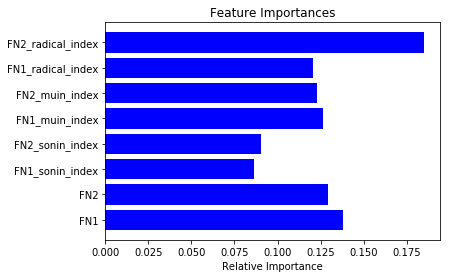

In [23]:
x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index']
#x_feature = ['FN1','FN2','FN1_radical_index','FN2_radical_index']


y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,1)

In [347]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('resampled_gender', 212711169),
 ('train_y', 6313704),
 ('moe_data_dict', 6291552),
 ('moe_additional_dict', 393312),
 ('specail_word_dict', 98400),
 ('Totalname_list', 72112),
 ('Taiwan_LastName_List', 12096),
 ('Taiwan_LastName_len1_List', 11184),
 ('Error_character', 4096),
 ('RandomForestClassifier', 2456),
 ('radical_list', 2064),
 ('mu_in_list', 1624),
 ('BalanceCascade', 1016),
 ('HanziConv', 1016),
 ('PCA', 1016),
 ('PrettyTable', 1016),
 ('Taiwan_LastName_len2_List', 976),
 ('son_in_list', 448),
 ('header', 272),
 ('sqrt', 192),
 ('square', 192),
 ('handle', 176),
 ('x_feature', 168),
 ('indices', 160),
 ('importances', 144),
 ('important_list', 144),
 ('column', 138),
 ('FN1bye', 136),
 ('FN1toFN2', 136),
 ('GetFirstName', 136),
 ('GetLastName', 136),
 ('GuessGender', 136),
 ('PrintException', 136),
 ('accuracy_score', 136),
 ('add_pin_in_column', 136),
 ('add_pin_in_index_column', 136),
 ('add_radical_column', 136),
 ('add_radical_index_column', 136),
 ('basic_RFClassifier

In [28]:
resampled_gender[resampled_gender.FirstName.apply(lambda x:len(x)==1)].iloc[0]

FirstName                           傑
LastName                            王
gender                              1
message                          2001
name                               王傑
userID               1114345485376859
FN1                                -1
FN2                               169
mgender                             1
FN1_sonin                          -1
FN1_muin                           -1
FN2_sonin                           j
FN2_muin                           ié
FN1_sonin_index                    -1
FN2_sonin_index                    12
FN1_muin_index                     -1
FN2_muin_index                    111
FN1_radical                        -1
FN2_radical                         人
FN1_radical_index                  -1
FN2_radical_index                   3
天格                                  5
人格                                 16
地格                                 13
外格                                  2
總格                                 36
Name: 19, dt

In [25]:
#FB_name_df[FB_name_df.FirstName.apply(lambda x:(x[0])==' ')].iloc[0]
FB_name_df[FB_name_df.FirstName.apply(lambda x:(x[0])==' ')].iloc[0]

NameError: name 'FB_name_df' is not defined

In [23]:
def FN1toFN2(row,column_name ):
    if len(row['FirstName'])!=1 and row['FirstName'][0]!=' ':
        return row[column_name]
    else :
        return row[column_name.replace('2','1')]

FN2_list = ['FN2','FN2_sonin_index','FN2_sonin','FN2_muin','FN2_radical','FN2_muin_index','FN2_radical_index']
for column in FN2_list:
    resampled_gender[column] =  resampled_gender.apply(lambda row: FN1toFN2(row,column),axis=1)

In [33]:
resampled_gender.columns.values

array(['FirstName', 'LastName', 'gender', 'message', 'name', 'userID',
       'FN1', 'FN2', 'mgender', 'FN1_sonin', 'FN1_muin', 'FN2_sonin',
       'FN2_muin', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index',
       'FN2_muin_index', 'FN1_radical', 'FN2_radical', 'FN1_radical_index',
       'FN2_radical_index', '天格', '人格', '地格', '外格', '總格'], dtype=object)

In [15]:
FN2_list = ['FN2_sonin','FN2_muin','FN2_radical']

In [24]:
for column in FN2_list:
    #Real_name_df[column] =  Real_name_df.apply(lambda row: FN1toFN2(row,column),axis=1)
    #FB_name_df[column] =  FB_name_df.apply(lambda row: FN1toFN2(row,column),axis=1)
    resampled_gender[column] =  resampled_gender.apply(lambda row: FN1toFN2(row,column),axis=1)

In [27]:
#FN_list = ['FN2','FN2_sonin_index','FN2_muin_index','FN2_radical_index']
def FN1bye(row,column_name):
    if len(row['FirstName'])!=1 and row['FirstName'][0]!=' ':
        return row[column_name]
    else:
        return -1
resampled_gender['FN1'] =  resampled_gender.apply(lambda row: FN1bye(row,'FN1'),axis=1)
resampled_gender['FN1_sonin_index'] =  resampled_gender.apply(lambda row: FN1bye(row,'FN1_sonin_index'),axis=1)
resampled_gender['FN1_muin_index'] =  resampled_gender.apply(lambda row: FN1bye(row,'FN1_muin_index'),axis=1)
resampled_gender['FN1_radical_index'] =  resampled_gender.apply(lambda row: FN1bye(row,'FN1_radical_index'),axis=1)

resampled_gender['FN1_sonin'] =  resampled_gender.apply(lambda row: FN1bye(row,'FN1_sonin'),axis=1)
resampled_gender['FN1_muin'] =  resampled_gender.apply(lambda row: FN1bye(row,'FN1_muin'),axis=1)
resampled_gender['FN1_radical'] =  resampled_gender.apply(lambda row: FN1bye(row,'FN1_radical'),axis=1)

In [20]:
# Real_name_df['FN1'] =  Real_name_df.apply(lambda row: FN1bye(row,'FN1'),axis=1)
# Real_name_df['FN1_sonin_index'] =  Real_name_df.apply(lambda row: FN1bye(row,'FN1_sonin_index'),axis=1)
# Real_name_df['FN1_muin_index'] =  Real_name_df.apply(lambda row: FN1bye(row,'FN1_muin_index'),axis=1)
# Real_name_df['FN1_radical_index'] =  Real_name_df.apply(lambda row: FN1bye(row,'FN1_radical_index'),axis=1)

# Real_name_df['FN1_sonin'] =  Real_name_df.apply(lambda row: FN1bye(row,'FN1_sonin'),axis=1)
# Real_name_df['FN1_muin'] =  Real_name_df.apply(lambda row: FN1bye(row,'FN1_muin'),axis=1)
# Real_name_df['FN1_radical'] =  Real_name_df.apply(lambda row: FN1bye(row,'FN1_radical'),axis=1)

# FB_name_df['FN1'] =  FB_name_df.apply(lambda row: FN1bye(row,'FN1'),axis=1)
# FB_name_df['FN1_sonin_index'] =  FB_name_df.apply(lambda row: FN1bye(row,'FN1_sonin_index'),axis=1)
# FB_name_df['FN1_muin_index'] =  FB_name_df.apply(lambda row: FN1bye(row,'FN1_muin_index'),axis=1)
# FB_name_df['FN1_radical_index'] =  FB_name_df.apply(lambda row: FN1bye(row,'FN1_radical_index'),axis=1)

FB_name_df['FN1_sonin'] =  FB_name_df.apply(lambda row: FN1bye(row,'FN1_sonin'),axis=1)
FB_name_df['FN1_muin'] =  FB_name_df.apply(lambda row: FN1bye(row,'FN1_muin'),axis=1)
FB_name_df['FN1_radical'] =  FB_name_df.apply(lambda row: FN1bye(row,'FN1_radical'),axis=1)

In [62]:
def make_nameto2(FN):
    if len(FN)==1:
        return ' '+FN
    else:
        return FN
resampled_gender['FirstName'] = resampled_gender.FirstName.apply(lambda x:make_nameto2(x))
resampled_gender['FirstName1'] = resampled_gender.FirstName.apply(lambda x:x[0])
resampled_gender['FirstName2'] = resampled_gender.FirstName.apply(lambda x:x[1])

In [18]:
#Real_name_df['FirstName'] = Real_name_df.FirstName.apply(lambda x:make_nameto2(x))
Real_name_df['FirstName1'] = Real_name_df.FirstName.apply(lambda x:x[0])
Real_name_df['FirstName2'] = Real_name_df.FirstName.apply(lambda x:x[1])

In [21]:
FB_name_df['FirstName1'] = FB_name_df.FirstName.apply(lambda x:x[0])
FB_name_df['FirstName2'] = FB_name_df.FirstName.apply(lambda x:x[1])

In [30]:
resampled_gender[resampled_gender.FirstName.apply(lambda x:len(x)==1)]

Empty DataFrame
Columns: [FirstName, LastName, gender, message, name, userID, FN1, FN2, mgender, FN1_sonin, FN1_muin, FN2_sonin, FN2_muin, FN1_sonin_index, FN2_sonin_index, FN1_muin_index, FN2_muin_index, FN1_radical, FN2_radical, FN1_radical_index, FN2_radical_index, 天格, 人格, 地格, 外格, 總格, FirstName1, FirstName2]
Index: []

[0 rows x 28 columns]

In [59]:
Path = './data_output/final/resampled_gender.csv'
resampled_gender = pd.read_csv(Path, dtype='str')

In [15]:
def GuessGender(name):
    name = '蕭'+name
    name_df = pd.DataFrame()
    name_df['name'] = [ name]


    name_df['LastName'] = name_df.name.apply(lambda x: (GetLastName(x)))
    name_df['FirstName'] = name_df.name.apply(lambda x: (GetFirstName(x)))
    name_df['FN1'] = name_df.FirstName.apply(lambda x: character_to_index(x,1))
    name_df['FN2'] = name_df.FirstName.apply(lambda x: character_to_index(x,2))

    name_df['FN1_sonin'] = name_df.FN1.apply(lambda x:  add_pin_in_column(x,'sonin') )
    name_df['FN1_muin'] = name_df.FN1.apply(lambda x:  add_pin_in_column(x,'muin') )

    name_df['FN2_sonin'] = name_df.FN2.apply(lambda x:  add_pin_in_column(x,'sonin') )
    name_df['FN2_muin'] = name_df.FN2.apply(lambda x:  add_pin_in_column(x,'muin') )
    name_df['FN1_sonin_index'] = name_df.FN1_sonin.apply(lambda x:  add_pin_in_index_column(x,'sonin') )
    name_df['FN2_sonin_index'] = name_df.FN2_sonin.apply(lambda x:  add_pin_in_index_column(x,'sonin') )

    name_df['FN1_muin_index'] = name_df.FN1_muin.apply(lambda x:  add_pin_in_index_column(x,'muin') )
    name_df['FN2_muin_index'] = name_df.FN2_muin.apply(lambda x:  add_pin_in_index_column(x,'muin') )

    name_df['FN1_radical'] = name_df.FN1.apply(lambda x:add_radical_column(x))
    name_df['FN2_radical'] = name_df.FN2.apply(lambda x:add_radical_column(x))

    name_df['FN1_radical_index'] = name_df.FN1_radical.apply(lambda x:add_radical_index_column(x))
    name_df['FN2_radical_index'] = name_df.FN2_radical.apply(lambda x:add_radical_index_column(x))

    x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index','FN2_muin_index',
                 'FN1_radical_index','FN2_radical_index']
    #x_feature = ['FN1','FN2','FN1_radical_index','FN2_radical_index']
    #print(name_df[x_feature])
    result = gender_predicton_model.predict(name_df[x_feature])
    if result =='0' or  result ==0:
        print('我猜',name[1:],'是:女生')
    if result =='1' or result ==1:
        print('我猜',name[1:],'是:男生')
    #print(gender_predicton_model.predict(name_df[x_feature]))

In [16]:
with open('./data_output/final/Totalname_list.txt', 'rb') as handle:
    Totalname_list = pickle.loads(handle.read())

In [22]:
gender_predicton_model.feature_importances_

array([ 0.13615834,  0.13057917,  0.08576468,  0.09055573,  0.12227055,
        0.12780267,  0.11097602,  0.19589284])

In [56]:
x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index']
#x_feature = ['FN1','FN2','FN1_radical_index','FN2_radical_index']


y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,10)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.996225972808
Test Accuracy  ::  0.914401356451


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.996366619784
Test Accuracy  ::  0.91497566045


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.996354899203
Test Accuracy  ::  0.913936443691


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 4
Train Accuracy ::  0.996319737459
Test Accuracy  ::  0.913362139693


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 5
Train Accuracy ::  0.995698546648
Test Accuracy  ::  0.917327572061


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 6
Train Accuracy ::  0.996108766995
Test Accuracy  ::  0.916589181207


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 7
Train Accuracy ::  0.996284575715
Test Accuracy  ::  0.917683093584


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 8
Train Accuracy ::  0.996061884669
Test Accuracy  ::  0.914182573976


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 9
Train Accuracy ::  0.996120487576
Test Accuracy  ::  0.916288355303


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 10
Train Accuracy ::  0.995686826067
Test Accuracy  ::  0.912705792266
Average Train Accuracy ::  0.996122831692
Average Test Accuracy  ::  0.915145216868


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  0.996436943272
Test Accuracy  ::  0.915030356068
Name 才溱
answer: 男 Classfier result: 女
Name 慶娟
answer: 男 Classfier result: 女
Name 敬元
answer: 女 Classfier result: 男
Name 承容
answer: 男 Classfier result: 女
Name 葉杰
answer: 男 Classfier result: 女
Name 子敏
answer: 男 Classfier result: 女
Name 曜萱
answer: 男 Classfier result: 女
Name 維竹
answer: 女 Classfier result: 男
Name 錒鈹
answer: 男 Classfier result: 女
Name 杰穎
answer: 男 Classfier result: 女
Name 靜葦
answer: 女 Classfier result: 男
Name 欣浩
answer: 男 Classfier result: 女
Name 仲禮
answer: 男 Classfier result: 女
Name 頌雅
answer: 女 Classfier result: 男
Name 聖喬
answer: 女 Classfier result: 男
Name 余恒
answer: 男 Classfier result: 女
Name 南眉
answer: 女 Classfier result: 男
Name 家汝
answer: 男 Classfier result: 女
Name 金蒿
answer: 男 Classfier result: 女
Name 玩火
answer: 男 Classfier result: 女
Name 晳勻
answer: 女 Classfier result: 男
Name 寶福
answer: 男 Classfier result: 女
Name 貴清
answer: 男 Classfier result: 女
Name 徵生
answer: 女 Classfier result: 男
Name 賊琪
answer: 男 Cl

answer: 男 Classfier result: 女
Name 自修
answer: 男 Classfier result: 女
Name 復陸
answer: 男 Classfier result: 女
Name 怡詔
answer: 男 Classfier result: 女
Name 賈京
answer: 女 Classfier result: 男
Name 鈺鑫
answer: 男 Classfier result: 女
Name 蕓華
answer: 女 Classfier result: 男
Name 東容
answer: 男 Classfier result: 女
Name 毓驊
answer: 男 Classfier result: 女
Name 小航
answer: 女 Classfier result: 男
Name 子贤
answer: 男 Classfier result: 女
Name 人瑋
answer: 女 Classfier result: 男
Name 迪悠
answer: 女 Classfier result: 男
Name 之立
answer: 男 Classfier result: 女
Name 晨櫻
answer: 男 Classfier result: 女
Name 澤芝
answer: 男 Classfier result: 女
Name 士育
answer: 男 Classfier result: 女
Name 靖滕
answer: 男 Classfier result: 女
Name 明瑾
answer: 女 Classfier result: 男
Name 秀献
answer: 男 Classfier result: 女
Name 伽嘉
answer: 女 Classfier result: 男
Name 肇華
answer: 男 Classfier result: 女
Name 怡麟
answer: 女 Classfier result: 男
Name 夏凝
answer: 男 Classfier result: 女
Name 行敏
answer: 男 Classfier result: 女
Name 魯藻
answer: 男 Classfier result: 女
Name 彥英
answer: 男 Cl

Name 又
answer: 女 Classfier result: 男
Name 端國
answer: 男 Classfier result: 女
Name 學如
answer: 男 Classfier result: 女
Name 碩才
answer: 男 Classfier result: 女
Name 航陳
answer: 女 Classfier result: 男
Name 徵麟
answer: 女 Classfier result: 男
Name 睏中
answer: 女 Classfier result: 男
Name 景安
answer: 男 Classfier result: 女
Name 亞
answer: 男 Classfier result: 女
Name 比飛
answer: 女 Classfier result: 男
Name 慶繽
answer: 女 Classfier result: 男
Name 致昕
answer: 女 Classfier result: 男
Name 舒苑
answer: 女 Classfier result: 男
Name 顥寶
answer: 男 Classfier result: 女
Name 婕菱
answer: 男 Classfier result: 女
Name 國靖
answer: 男 Classfier result: 女
Name 順涵
answer: 女 Classfier result: 男
Name 蘊庭
answer: 女 Classfier result: 男
Name 顈強
answer: 男 Classfier result: 女
Name 楷瑜
answer: 女 Classfier result: 男
Name 寶明
answer: 男 Classfier result: 女
Name 銘宣
answer: 女 Classfier result: 男
Name 靖敏
answer: 女 Classfier result: 男
Name 喻晰
answer: 男 Classfier result: 女
Name 重貞
answer: 女 Classfier result: 男
Name 靜儒
answer: 女 Classfier result: 男
Name 華鑫
answer

answer: 女 Classfier result: 男
Name 吟月
answer: 男 Classfier result: 女
Name 容辰
answer: 女 Classfier result: 男
Name 宜澄
answer: 女 Classfier result: 男
Name 念璋
answer: 女 Classfier result: 男
Name 瑟稀
answer: 男 Classfier result: 女
Name 傻傻
answer: 女 Classfier result: 男
Name 富湮
answer: 男 Classfier result: 女
Name 署君
answer: 男 Classfier result: 女
Name 鍚愉
answer: 女 Classfier result: 男
Name 代
answer: 男 Classfier result: 女
Name 小宙
answer: 男 Classfier result: 女
Name 俊惠
answer: 男 Classfier result: 女
Name 長禮
answer: 女 Classfier result: 男
Name 棻
answer: 女 Classfier result: 男
Name 廸威
answer: 男 Classfier result: 女
Name 夙楓
answer: 女 Classfier result: 男
Name 世袖
answer: 女 Classfier result: 男
Name 晉欣
answer: 女 Classfier result: 男
Name 曼旎
answer: 女 Classfier result: 男
Name 攸儒
answer: 男 Classfier result: 女
Name 義宣
answer: 男 Classfier result: 女
Name 公璞
answer: 男 Classfier result: 女
Name 志晴
answer: 男 Classfier result: 女
Name 呦豆
answer: 女 Classfier result: 男
Name 毓力
answer: 男 Classfier result: 女
Name 羽笙
answer: 女 Clas

Name 羣英
answer: 女 Classfier result: 男
Name 良雄
answer: 男 Classfier result: 女
Name 國珠
answer: 女 Classfier result: 男
Name 布鈴
answer: 男 Classfier result: 女
Name 宇遙
answer: 女 Classfier result: 男
Name 奇特
answer: 女 Classfier result: 男
Name 梅慶
answer: 女 Classfier result: 男
Name 一岑
answer: 男 Classfier result: 女
Name 欣翰
answer: 男 Classfier result: 女
Name 抗蘇
answer: 女 Classfier result: 男
Name 琮
answer: 女 Classfier result: 男
Name 宜楨
answer: 男 Classfier result: 女
Name 宇琳
answer: 女 Classfier result: 男
Name 韶
answer: 女 Classfier result: 男
Name 芳霖
answer: 男 Classfier result: 女
Name 貴明
answer: 女 Classfier result: 男
Name 子餓
answer: 女 Classfier result: 男
Name 瑞啓
answer: 男 Classfier result: 女
Name 菘任
answer: 男 Classfier result: 女
Name 蕊潼
answer: 女 Classfier result: 男
Name 美良
answer: 女 Classfier result: 男
Name 琮烜
answer: 男 Classfier result: 女
Name 竹佑
answer: 女 Classfier result: 男
Name 春琳
answer: 男 Classfier result: 女
Name 凱喬
answer: 男 Classfier result: 女
Name 市話
answer: 男 Classfier result: 女
Name 馨寧
answer

Name 惠年
answer: 男 Classfier result: 女
Name 齊蓀
answer: 男 Classfier result: 女
Name 輔儀
answer: 男 Classfier result: 女
Name 笠五
answer: 男 Classfier result: 女
Name 凌麟
answer: 男 Classfier result: 女
Name 閔岳
answer: 男 Classfier result: 女
Name 鎂泉
answer: 女 Classfier result: 男
Name 基瑤
answer: 男 Classfier result: 女
Name 纬庭
answer: 男 Classfier result: 女
Name 欽寧
answer: 女 Classfier result: 男
Name 子雲
answer: 男 Classfier result: 女
Name 家侃
answer: 男 Classfier result: 女
Name 幼非
answer: 男 Classfier result: 女
Name 藹侯
answer: 男 Classfier result: 女
Name 人紀
answer: 男 Classfier result: 女
Name 純青
answer: 男 Classfier result: 女
Name 建慧
answer: 男 Classfier result: 女
Name 庭華
answer: 男 Classfier result: 女
Name 富絜
answer: 女 Classfier result: 男
Name 靡維
answer: 男 Classfier result: 女
Name 心揚
answer: 女 Classfier result: 男
Name 日琳
answer: 男 Classfier result: 女
Name 耕綸
answer: 男 Classfier result: 女
Name 誉烜
answer: 男 Classfier result: 女
Name 瑞舟
answer: 男 Classfier result: 女
Name 東妹
answer: 女 Classfier result: 男
Name 貞亮
answ

Name 鐵軍
answer: 男 Classfier result: 女
Name 正惠
answer: 男 Classfier result: 女
Name 沙
answer: 男 Classfier result: 女
Name 加竹
answer: 男 Classfier result: 女
Name 同瑄
answer: 男 Classfier result: 女
Name 海琳
answer: 男 Classfier result: 女
Name 紹佳
answer: 女 Classfier result: 男
Name 琣遙
answer: 女 Classfier result: 男
Name 翊方
answer: 男 Classfier result: 女
Name 嶺馨
answer: 女 Classfier result: 男
Name 從惠
answer: 男 Classfier result: 女
Name 楮字
answer: 男 Classfier result: 女
Name 孝宇
answer: 女 Classfier result: 男
Name 隆藤
answer: 男 Classfier result: 女
Name 捏
answer: 男 Classfier result: 女
Name 博儀
answer: 男 Classfier result: 女
Name 明盷
answer: 男 Classfier result: 女
Name 嫣斐
answer: 女 Classfier result: 男
Name 韻霖
answer: 男 Classfier result: 女
Name 乃臻
answer: 男 Classfier result: 女
Name 威倫
answer: 男 Classfier result: 女
Name 政珀
answer: 女 Classfier result: 男
Name 襪子
answer: 女 Classfier result: 男
Name 靖泰
answer: 男 Classfier result: 女
Name 海法
answer: 女 Classfier result: 男
Name 復文
answer: 男 Classfier result: 女
Name 安恭
answer

answer: 女 Classfier result: 男
Name 呈卉
answer: 女 Classfier result: 男
Name 聯科
answer: 男 Classfier result: 女
Name 劍霓
answer: 女 Classfier result: 男
Name 二南
answer: 男 Classfier result: 女
Name 復裕
answer: 男 Classfier result: 女
Name 起端
answer: 男 Classfier result: 女
Name 倫瑄
answer: 男 Classfier result: 女
Name 鍾群
answer: 女 Classfier result: 男
Name 亞茄
answer: 男 Classfier result: 女
Name 韶文
answer: 女 Classfier result: 男
Name 昭世
answer: 女 Classfier result: 男
Name 走熊
answer: 男 Classfier result: 女
Name 錦豪
answer: 女 Classfier result: 男
Name 煜棋
answer: 男 Classfier result: 女
Name 財怡
answer: 男 Classfier result: 女
Name 魯比
answer: 女 Classfier result: 男
Name 昱崡
answer: 女 Classfier result: 男
Name 阿來
answer: 男 Classfier result: 女
Name 庭墉
answer: 男 Classfier result: 女
Name 张
answer: 女 Classfier result: 男
Name 智青
answer: 男 Classfier result: 女
Name 慰年
answer: 女 Classfier result: 男
Name 青平
answer: 男 Classfier result: 女
Name 佳愷
answer: 男 Classfier result: 女
Name 肇珩
answer: 女 Classfier result: 男
Name 北紅
answer: 女 Cla

Name 悅明
answer: 女 Classfier result: 男
Name 聲瑞
answer: 女 Classfier result: 男
Name 自美
answer: 男 Classfier result: 女
Name 冰清
answer: 女 Classfier result: 男
Name 嘉蒞
answer: 男 Classfier result: 女
Name 郁賀
answer: 男 Classfier result: 女
Name 安貧
answer: 男 Classfier result: 女
Name 縉儀
answer: 男 Classfier result: 女
Name 家咏
answer: 女 Classfier result: 男
Name 幸村
answer: 男 Classfier result: 女
Name 涓寧
answer: 女 Classfier result: 男
Name 宇萌
answer: 男 Classfier result: 女
Name 映逵
answer: 男 Classfier result: 女
Name 維連
answer: 男 Classfier result: 女
Name 代懷
answer: 男 Classfier result: 女
Name 洛克
answer: 女 Classfier result: 男
Name 唯慈
answer: 女 Classfier result: 男
Name 邦柱
answer: 女 Classfier result: 男
Name 錦臺
answer: 女 Classfier result: 男
Name 歌曼
answer: 男 Classfier result: 女
Name 桂武
answer: 男 Classfier result: 女
Name 博華
answer: 男 Classfier result: 女
Name 瑀宸
answer: 女 Classfier result: 男
Name 恩皓
answer: 男 Classfier result: 女
Name 斐然
answer: 男 Classfier result: 女
Name 凱象
answer: 男 Classfier result: 女
Name 均堅
answ

answer: 女 Classfier result: 男
Name 芳譚
answer: 男 Classfier result: 女
Name 到腰
answer: 女 Classfier result: 男
Name 曄敏
answer: 女 Classfier result: 男
Name 宇威
answer: 女 Classfier result: 男
Name 大業
answer: 男 Classfier result: 女
Name 欣廷
answer: 女 Classfier result: 男
Name 毓桓
answer: 女 Classfier result: 男
Name 郁沁
answer: 女 Classfier result: 男
Name 匡齊
answer: 女 Classfier result: 男
Name 生紙
answer: 女 Classfier result: 男
Name 汝柳
answer: 女 Classfier result: 男
Name 品誥
answer: 男 Classfier result: 女
Name 樹青
answer: 女 Classfier result: 男
Name 拉進
answer: 男 Classfier result: 女
Name 貞谷
answer: 女 Classfier result: 男
Name 家汝
answer: 男 Classfier result: 女
Name 安俊
answer: 男 Classfier result: 女
Name 桂
answer: 男 Classfier result: 女
Name 芳和
answer: 男 Classfier result: 女
Name 稔
answer: 男 Classfier result: 女
Name 瑀宸
answer: 女 Classfier result: 男
Name 厚衍
answer: 女 Classfier result: 男
Name 祥恩
answer: 男 Classfier result: 女
Name 秀男
answer: 男 Classfier result: 女
Name 非比
answer: 女 Classfier result: 男
Name 長南
answer: 女 Clas

Name 乃勇
answer: 女 Classfier result: 男
Name 驊陳
answer: 女 Classfier result: 男
Name 澤芝
answer: 男 Classfier result: 女
Name 慕雲
answer: 女 Classfier result: 男
Name 書念
answer: 男 Classfier result: 女
Name 兗君
answer: 男 Classfier result: 女
Name 謦鴻
answer: 女 Classfier result: 男
Name 延羲
answer: 女 Classfier result: 男
Name 饅頭
answer: 男 Classfier result: 女
Name 英原
answer: 女 Classfier result: 男
Name 聯瑞
answer: 男 Classfier result: 女
Name 容嘉
answer: 女 Classfier result: 男
Name 學寧
answer: 男 Classfier result: 女
Name 企垚
answer: 男 Classfier result: 女
Name 芳鳴
answer: 男 Classfier result: 女
Name 鐙緯
answer: 男 Classfier result: 女
Name 愼勤
answer: 男 Classfier result: 女
Name 文殷
answer: 女 Classfier result: 男
Name 凱亮
answer: 男 Classfier result: 女
Name 雪桐
answer: 女 Classfier result: 男
Name 澤國
answer: 女 Classfier result: 男
Name 汾瑱
answer: 女 Classfier result: 男
Name 祥雪
answer: 女 Classfier result: 男
Name 媛生
answer: 女 Classfier result: 男
Name 建榕
answer: 女 Classfier result: 男
Name 翎華
answer: 女 Classfier result: 男
Name 莊仁
answ

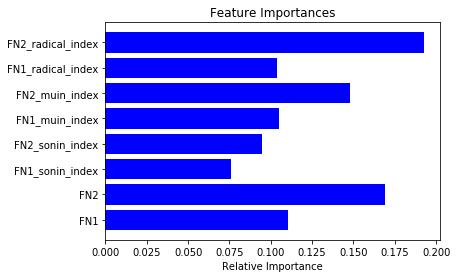

In [104]:
#放第二個
x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index']
#x_feature = ['FN1','FN2','FN1_radical_index','FN2_radical_index']


y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,1)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.996308016878
Test Accuracy  ::  0.916507137778
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']
[ 0.10270347  0.1362803   0.06715101  0.09410356  0.09364863  0.1427404
  0.09059178  0.1992857   0.07349515]


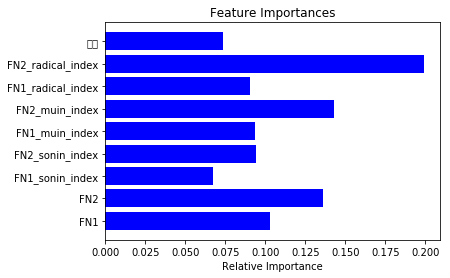

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.996565869667
Test Accuracy  ::  0.915139747306
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']
[ 0.10061225  0.1372312   0.061419    0.08736838  0.09839601  0.13910966
  0.09638325  0.20632847  0.07315181]


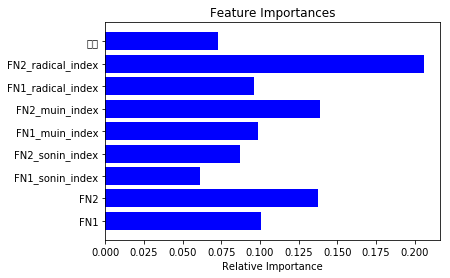

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.995991561181
Test Accuracy  ::  0.919050484056
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']
[ 0.09508178  0.15176605  0.06434126  0.09869958  0.09494364  0.14368497
  0.0813492   0.19869693  0.07143659]


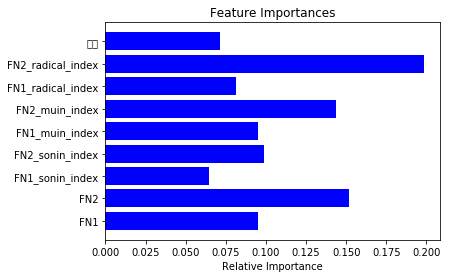

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 4
Train Accuracy ::  0.996518987342
Test Accuracy  ::  0.915413225401
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']
[ 0.10870179  0.13795423  0.0681781   0.09287922  0.09706657  0.13613274
  0.0921629   0.19307586  0.07384858]


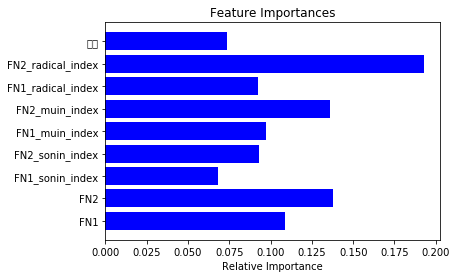

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 5
Train Accuracy ::  0.996460384435
Test Accuracy  ::  0.91839413663
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']
[ 0.10269168  0.1382739   0.06448216  0.09048952  0.08963435  0.13906276
  0.09318822  0.210382    0.0717954 ]


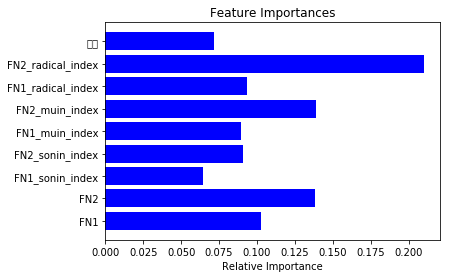

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 6
Train Accuracy ::  0.995956399437
Test Accuracy  ::  0.919952961768
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']
[ 0.09742634  0.1555184   0.06347773  0.0912937   0.0890852   0.14123193
  0.08761318  0.20455688  0.06979664]


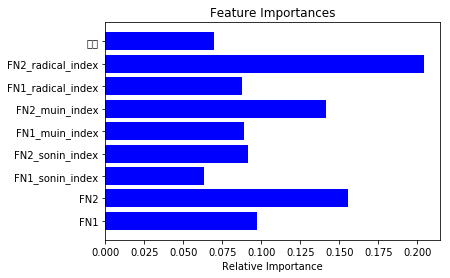

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 7
Train Accuracy ::  0.996460384435
Test Accuracy  ::  0.91399113931
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']
[ 0.10968972  0.13395642  0.06587217  0.08864874  0.09606704  0.12671446
  0.0985744   0.20621163  0.07426541]


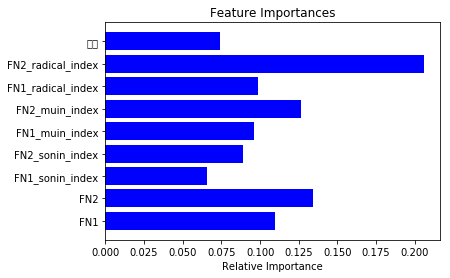

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 8
Train Accuracy ::  0.996085325832
Test Accuracy  ::  0.913936443691
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']
[ 0.10973349  0.13710527  0.06871056  0.08781646  0.10155639  0.1263052
  0.10780444  0.18506076  0.07590745]


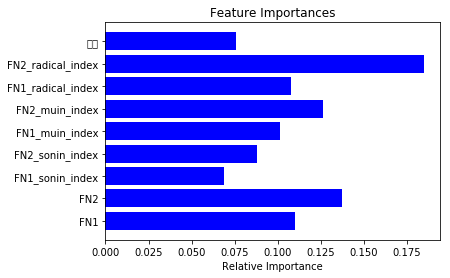

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 9
Train Accuracy ::  0.99633145804
Test Accuracy  ::  0.917765137013
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']
[ 0.0980263   0.13981027  0.06744273  0.09469029  0.09625477  0.14070362
  0.09123237  0.19674203  0.07509761]


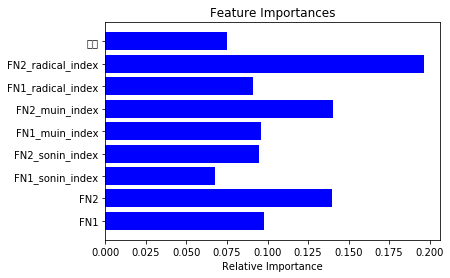

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 10
Train Accuracy ::  0.996179090483
Test Accuracy  ::  0.914510747689
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']
[ 0.1056738   0.12712936  0.0671525   0.09034093  0.1007265   0.13204368
  0.09815769  0.20600066  0.07277488]


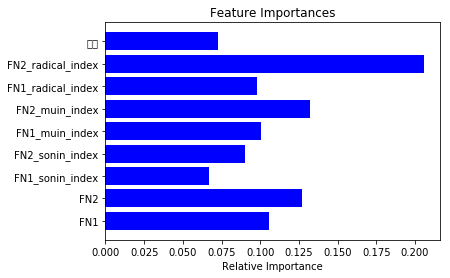

Average Train Accuracy ::  0.996285747773
Average Test Accuracy  ::  0.916466116064
[array([ 0.10270347,  0.1362803 ,  0.06715101,  0.09410356,  0.09364863,
        0.1427404 ,  0.09059178,  0.1992857 ,  0.07349515]), array([ 0.10061225,  0.1372312 ,  0.061419  ,  0.08736838,  0.09839601,
        0.13910966,  0.09638325,  0.20632847,  0.07315181]), array([ 0.09508178,  0.15176605,  0.06434126,  0.09869958,  0.09494364,
        0.14368497,  0.0813492 ,  0.19869693,  0.07143659]), array([ 0.10870179,  0.13795423,  0.0681781 ,  0.09287922,  0.09706657,
        0.13613274,  0.0921629 ,  0.19307586,  0.07384858]), array([ 0.10269168,  0.1382739 ,  0.06448216,  0.09048952,  0.08963435,
        0.13906276,  0.09318822,  0.210382  ,  0.0717954 ]), array([ 0.09742634,  0.1555184 ,  0.06347773,  0.0912937 ,  0.0890852 ,
        0.14123193,  0.08761318,  0.20455688,  0.06979664]), array([ 0.10968972,  0.13395642,  0.06587217,  0.08864874,  0.09606704,
        0.12671446,  0.0985744 ,  0.20621163,

In [120]:
#放第二個
x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index','地格']
#x_feature = ['FN1','FN2','FN1_radical_index','FN2_radical_index']


y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,10)

In [20]:
resampled_gender[resampled_gender.FirstName.apply(lambda x:len(x)==1)]

FirstName LastName gender message name             userID   FN1 FN2  \
19             傑        王      1    2001   王傑   1114345485376859   169  -1   
31             真        吳      1    2005   吳真   1400048723351167   653  -1   
45             凱        朱      1    1957   朱凱                NaN    82  -1   
52             韶        蔡      1    1954   蔡韶                NaN   697  -1   
65             力        古      1    1992   古力   1842139849372103   437  -1   
78             堅        王      1    1928   王堅                NaN   568  -1   
89             寧        奚      1    1950   奚寧                NaN   179  -1   
91             鈞        王      1    1958   王鈞                NaN   295  -1   
96             仰        信      1    1993   信仰   1288274101241770   933  -1   
99             高        高      1    2002   高高    245299589294621  1580  -1   
105            譽        毛      1    1998   毛譽   1255868521176685  1138  -1   
116            傑        蘇      1    1998   蘇傑    440228102976509   169  -1   
171            昇        王      1    1957   王昇                NaN   818  -1   
221            豪        洪      1    1981   洪豪   1869445113316513    60  -1   
281            益        李      1    1995   李益   2261434597215402   204  -1   
306            蘇        蘇      1    1991   蘇蘇   1494720633881139   924  -1   
320            龍        尹      1    2000   尹龍    796951880474272    69  -1   
335            勳        唐      1    1926   唐勳                NaN   117  -1   
345            康        鄭      1    1951   鄭康                NaN    37  -1   
348            浩        孫      1    1949   孫浩                NaN   234  -1   
354            璟        黃      1    1992   黃璟  10208118887869233    54  -1   
408            端        林      1    1958   林端                NaN   837  -1   
447            竹        秋      1    1980   秋竹  10208747117545794   621  -1   
473            兒        歐      1    1995   歐兒   1396259563728976    79  -1   
499            匡        羅      1    1948   羅匡                NaN  3669  -1   
512            飛        飛      1    1981   飛飛   1710226655670737   515  -1   
515            復        裘      1    1959   裘復                NaN  1608  -1   
526            杰        文      1    2000   文杰    677367995779857   248  -1   
528            宇        呂      1    2003   呂宇    404959496549710    10  -1   
546            柏        許      1    1940   許柏                NaN    47  -1   
...          ...      ...    ...     ...  ...                ...   ...  ..   
121276         黛        蔣      0    1947   蔣黛                NaN  2260  -1   
121378         平        丁      0    1929   丁平                NaN   644  -1   
121380         琳        文      0    1929   文琳                NaN   252  -1   
121382         萍        王      0    1929   王萍                NaN   226  -1   
121383         愫        王      0    1929   王愫                NaN  2027  -1   
121384         瑾        王      0    1929   王瑾                NaN   854  -1   
121420         珠        朱      0    1929   朱珠                NaN   596  -1   
121468         玟        李      0    1929   李玟                NaN   324  -1   
121501         蕙        周      0    1929   周蕙                NaN   323  -1   
121521         卿        林      0    1929   林卿                NaN   757  -1   
121522         國        林      0    1929   林國                NaN   436  -1   
121523         惜        林      0    1929   林惜                NaN  2214  -1   
121524         梅        林      0    1929   林梅                NaN   189  -1   
121552         茜        邵      0    1929   邵茜                NaN  1227  -1   
121612         元        張      0    1929   張元                NaN   109  -1   
121613         文        張      0    1929   張文                NaN    28  -1   
121614         惠        張      0    1929   張惠                NaN   106  -1   
121615         慧        張      0    1929   張慧                NaN   124  -1   
121645         培        曹      0    1929   曹培                NaN    58  -1   
121655         鸞        盛    

In [274]:
def vote_RFClassifier(data_df,x_feature,y_feature,Validation_times):

    #N fold cross-validation
    Train_accuracy_score=0
    Test_accuracy_score=0
    accuarcy_list =[]
    importances_list = []
    
    for i in range(Validation_times):
        classifier_list = []
        train_x, test_x, train_y, test_y = split_dataset(data_df, 0.7, x_feature, y_feature)

            
  
        for index,x_f in enumerate(x_feature):
            
            #train_x, test_x, train_y, test_y = split_dataset(data_df, 0.7, [x_f], y_feature)
            print('feature:',x_f)
            # Create random forest classifier instance
            trained_model = random_forest_classifier(train_x[x_f].reshape(-1,1), train_y)


            predictions = trained_model.predict(test_x[x_f].reshape(-1,1))
#             predictions_prob = trained_model.predict_proba(test_x)
#             print(predictions_prob)
            classifier_list.append(trained_model)
    
            # Train and Test Accuracy
            if(Validation_times!=1):
                print('Run times:',i+1)
            print ("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x[x_f].reshape(-1,1))))
            print ("Test Accuracy  :: ", accuracy_score(test_y, predictions))
            #print (" Confusion matrix\n ", confusion_matrix(test_y, predictions))
            accuarcy_list.append(accuracy_score(test_y, predictions))
        gender = 0
        correct=0
        prediction_list = []

        for index,x_f in enumerate(x_feature):
            #predictions_prob = classifier_list[i].predict_proba(test_x.iloc[i])
            prediction_list.append(classifier_list[index].predict_proba(test_x[x_f].reshape(-1,1)))
        
        for index,predictions in enumerate(prediction_list[0]):
            gender=0
            for x_f_index in range(len(x_feature)):
                #print(prediction_list[x_f_index][index])
                for index2,p in  enumerate(prediction_list[x_f_index][index]):
                    if index2==0:
                        gender =gender -float(p.item()) *accuarcy_list[x_f_index]
                    else:
                        gender=gender+float(p.item()) *accuarcy_list[x_f_index]

            if gender>0:
                gender='1'
            else:
                gender='0'
            #print(gender,type(gender))
            #print(test_y.iloc[i].mgender,type(test_y.iloc[i].mgender))
            if gender==test_y.iloc[index].mgender:
                correct+=1
        Test_accuracy_score+=    correct/len(test_y)
        print('Voting accuracy:',(correct/len(test_y)))
        
#         Train_accuracy_score+=accuracy_score(train_y, trained_model.predict(train_x))
#         Test_accuracy_score+= accuracy_score(test_y, predictions)
#         calculate_error( predictions, test_y )
    
        #validate_error( predictions,data_df, test_y,test_x )
        
#         importances = trained_model.feature_importances_
#         importances_list.append(importances)
#         #indices = np.argsort(importances)
#         print('Feature Importances')
 
# #         print(x_feature)
# #         print(importances)
# #         plt.title('Feature Importances')
# #         plt.barh(range(len(importances)), importances, color='b', align='center')
# #         plt.yticks(range(len(importances)), x_feature) ## removed [indices]
# #         plt.xlabel('Relative Importance')
# #         plt.show()
        
    if(Validation_times!=1):
        #Train_accuracy_score/=Validation_times
        Test_accuracy_score/=Validation_times
        #print ("Average Train Accuracy :: ", Train_accuracy_score)
        print ("Average Test Accuracy  :: ",Test_accuracy_score)
        #print(importances_list)
    return trained_model

In [359]:
#沒Weight的voting
x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index','地格','外格'] 
#0.8915932833780014
x_feature = ['FN1','FN2','FN2_muin_index','FN2_radical_index'] 
#0.896
# x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
#              'FN2_muin_index','FN1_radical_index','FN2_radical_index'] 
#0.8933
x_feature = ['FN1','FN2']
#0.914
#0.9
#x_feature = ['FN2']
#0.878

y_feature = ['mgender']

#gender_predicton_model = 
vote_RFClassifier(resampled_gender,x_feature,y_feature,1)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



feature: FN1


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Train Accuracy ::  0.817909048289
Test Accuracy  ::  0.805748509544
feature: FN2


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Train Accuracy ::  0.890084388186
Test Accuracy  ::  0.880927637696


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Voting accuracy: 0.9181480063446917


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=256, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [278]:
%%time
#有Weight的voting
x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index','地格','外格'] 
#0.8981
#x_feature = ['FN1','FN2','FN2_muin_index','FN2_radical_index'] 
#0.8983
# x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
#              'FN2_muin_index','FN1_radical_index','FN2_radical_index'] 
#0.90
#x_feature = ['FN1','FN2']
#0.914
#x_feature = ['FN2']
#0.878
# x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
#              'FN2_muin_index','FN1_radical_index','FN2_radical_index'] 
#0.8919
y_feature = ['mgender']

#gender_predicton_model = 
vote_RFClassifier(resampled_gender,x_feature,y_feature,5)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



feature: FN1


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 1
Train Accuracy ::  0.817170651664
Test Accuracy  ::  0.805502379259
feature: FN2


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 1
Train Accuracy ::  0.889545241444
Test Accuracy  ::  0.878821856369
feature: FN1_sonin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 1
Train Accuracy ::  0.643131739334
Test Accuracy  ::  0.642919652136
feature: FN2_sonin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 1
Train Accuracy ::  0.603293483357
Test Accuracy  ::  0.602089372641
feature: FN1_muin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 1
Train Accuracy ::  0.679735114862
Test Accuracy  ::  0.677268500793
feature: FN2_muin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 1
Train Accuracy ::  0.691713548992
Test Accuracy  ::  0.689575015041
feature: FN1_radical_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 1
Train Accuracy ::  0.687634786685
Test Accuracy  ::  0.687824755237
feature: FN2_radical_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 1
Train Accuracy ::  0.745768870136
Test Accuracy  ::  0.748044631625
feature: 地格


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 1
Train Accuracy ::  0.531458040319
Test Accuracy  ::  0.531860197998
feature: 外格


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 1
Train Accuracy ::  0.577062822316
Test Accuracy  ::  0.57673795329


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Voting accuracy: 0.8994968003062954
feature: FN1


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 2
Train Accuracy ::  0.819432723863
Test Accuracy  ::  0.8001148608
feature: FN2


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 2
Train Accuracy ::  0.890482887951
Test Accuracy  ::  0.877372422469
feature: FN1_sonin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 2
Train Accuracy ::  0.642944210033
Test Accuracy  ::  0.643357217087
feature: FN2_sonin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 2
Train Accuracy ::  0.600597749648
Test Accuracy  ::  0.608570803479
feature: FN1_muin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 2
Train Accuracy ::  0.678984997656
Test Accuracy  ::  0.679155499644
feature: FN2_muin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 2
Train Accuracy ::  0.692909048289
Test Accuracy  ::  0.687141060001
feature: FN1_radical_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 2
Train Accuracy ::  0.690307079231
Test Accuracy  ::  0.682054367445
feature: FN2_radical_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 2
Train Accuracy ::  0.748195030474
Test Accuracy  ::  0.743176721545
feature: 地格


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 2
Train Accuracy ::  0.531786216596
Test Accuracy  ::  0.531203850572
feature: 外格


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 2
Train Accuracy ::  0.578598218472
Test Accuracy  ::  0.573210085872


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Voting accuracy: 0.8954766723185473
feature: FN1


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 3
Train Accuracy ::  0.818659165495
Test Accuracy  ::  0.802111250889
feature: FN2


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 3
Train Accuracy ::  0.88890060947
Test Accuracy  ::  0.879669638462
feature: FN1_sonin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 3
Train Accuracy ::  0.64090482888
Test Accuracy  ::  0.64661160641
feature: FN2_sonin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 3
Train Accuracy ::  0.603082512893
Test Accuracy  ::  0.602827763496
feature: FN1_muin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 3
Train Accuracy ::  0.679676511955
Test Accuracy  ::  0.67743258765
feature: FN2_muin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 3
Train Accuracy ::  0.690951711205
Test Accuracy  ::  0.69157140513
feature: FN1_radical_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 3
Train Accuracy ::  0.688759962494
Test Accuracy  ::  0.685472843625
feature: FN2_radical_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 3
Train Accuracy ::  0.746718237225
Test Accuracy  ::  0.746431110868
feature: 地格


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 3
Train Accuracy ::  0.53015705579
Test Accuracy  ::  0.530520155336
feature: 外格


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 3
Train Accuracy ::  0.578516174402
Test Accuracy  ::  0.573374172729


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Voting accuracy: 0.8990318875458075
feature: FN1


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 4
Train Accuracy ::  0.817030004688
Test Accuracy  ::  0.80593994421
feature: FN2


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 4
Train Accuracy ::  0.889580403188
Test Accuracy  ::  0.879478203796
feature: FN1_sonin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 4
Train Accuracy ::  0.643741209564
Test Accuracy  ::  0.641497566045
feature: FN2_sonin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 4
Train Accuracy ::  0.601406469761
Test Accuracy  ::  0.606738500246
feature: FN1_muin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 4
Train Accuracy ::  0.67823488045
Test Accuracy  ::  0.680577585735
feature: FN2_muin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 4
Train Accuracy ::  0.690084388186
Test Accuracy  ::  0.694333533884
feature: FN1_radical_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 4
Train Accuracy ::  0.68854899203
Test Accuracy  ::  0.686047147623
feature: FN2_radical_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 4
Train Accuracy ::  0.74694092827
Test Accuracy  ::  0.746075589345
feature: 地格


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 4
Train Accuracy ::  0.532172995781
Test Accuracy  ::  0.530383416288
feature: 外格


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 4
Train Accuracy ::  0.576230661041
Test Accuracy  ::  0.57867964776


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Voting accuracy: 0.9007001039216759
feature: FN1


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 5
Train Accuracy ::  0.816104078762
Test Accuracy  ::  0.808237160203
feature: FN2


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 5
Train Accuracy ::  0.890506329114
Test Accuracy  ::  0.877263031231
feature: FN1_sonin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 5
Train Accuracy ::  0.642287857478
Test Accuracy  ::  0.644888694416
feature: FN2_sonin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 5
Train Accuracy ::  0.602613689639
Test Accuracy  ::  0.603538806542
feature: FN1_muin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 5
Train Accuracy ::  0.677578527895
Test Accuracy  ::  0.682027019636
feature: FN2_muin_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 5
Train Accuracy ::  0.692463666198
Test Accuracy  ::  0.688699885139
feature: FN1_radical_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 5
Train Accuracy ::  0.688842006564
Test Accuracy  ::  0.685336104578
feature: FN2_radical_index


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 5
Train Accuracy ::  0.747972339428
Test Accuracy  ::  0.743313460592
feature: 地格


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 5
Train Accuracy ::  0.53050867323
Test Accuracy  ::  0.529016025816
feature: 外格


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Run times: 5
Train Accuracy ::  0.578398968589
Test Accuracy  ::  0.573647650823


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



Voting accuracy: 0.8981020620248318
Average Test Accuracy  ::  0.8985615052234316
CPU times: user 1min 39s, sys: 132 ms, total: 1min 39s
Wall time: 1min 39s


In [23]:
#用attribute的組合看看
def vote_RFClassifier2(data_df,x_feature,x_feature_list,y_feature,Validation_times,mode):

    #N fold cross-validation
    Train_accuracy_score=0
    Test_accuracy_score=0
    accuarcy_list =[]
    importances_list = []
    
    for i in range(Validation_times):
        classifier_list = []
        train_x, test_x, train_y, test_y = split_dataset(data_df, 0.7, x_feature, y_feature)

  
        for index,x_f in enumerate(x_feature_list):
            
            print('feature:',x_f)
            # Create random forest classifier instance
            #print(train_x[x_f])
            trained_model = random_forest_classifier(train_x[x_f], train_y)


            predictions = trained_model.predict(test_x[x_f])
#             predictions_prob = trained_model.predict_proba(test_x)
#             print(predictions_prob)
            classifier_list.append(trained_model)
    
            # Train and Test Accuracy
            if(Validation_times!=1):
                print('Run times:',i+1)
            print ("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x[x_f])))
            print ("Test Accuracy  :: ", accuracy_score(test_y, predictions))
            #print (" Confusion matrix\n ", confusion_matrix(test_y, predictions))
            accuarcy_list.append(accuracy_score(test_y, predictions))
        gender = 0
        correct=0
        prediction_list = []

        for index,x_f in enumerate(x_feature_list):
            #predictions_prob = classifier_list[i].predict_proba(test_x.iloc[i])
            prediction_list.append(classifier_list[index].predict_proba(test_x[x_f]))
        
        for index,predictions in enumerate(prediction_list[0]):
            gender=0
            for x_f_index in range(len(x_feature_list)):
                #print(prediction_list[x_f_index][index])
                for index2,p in  enumerate(prediction_list[x_f_index][index]):
                    if index2==0:
                        if mode=='weight':
                            gender =gender -float(p.item())*accuarcy_list[x_f_index]*accuarcy_list[x_f_index]
                        else:
                            gender =gender -float(p.item())
                    else:
                        if mode=='weight':
                            gender =gender +float(p.item())*accuarcy_list[x_f_index]*accuarcy_list[x_f_index]
                        else:
                            gender =gender +float(p.item()) 

            if gender>0:
                gender='1'
            else:
                gender='0'
            #print(gender,type(gender))
            #print(test_y.iloc[i].mgender,type(test_y.iloc[i].mgender))
            if gender==test_y.iloc[index].mgender:
                correct+=1
        Test_accuracy_score+=    correct/len(test_y)
        print('Voting accuracy:',(correct/len(test_y)))
        
        
    if(Validation_times!=1):
        #Train_accuracy_score/=Validation_times
        Test_accuracy_score/=Validation_times
        #print ("Average Train Accuracy :: ", Train_accuracy_score)
        print ("Average Test Accuracy  :: ",Test_accuracy_score)
        #print(importances_list)
    return classifier_list

In [ ]:
x_feature_list = [['FN1'],['FN2']

In [47]:
%%time
#有Weight的voting
x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index','天格', 
             '人格', '地格', '外格', '總格']

#0.9128
x_feature_list = [['FN1','FN2'],['FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index'] ]
#0.9053
x_feature_list = [['FN1'],['FN2'],['FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index'] ]
#0.9149
x_feature_list = [[ 'heaven', 'man', 'earth', 'outside', 'total'],['FN1'],['FN2'],['FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index'] ]
#0.915

x_feature_list = [[ 'FN1','FN2', '地格', '外格'],
                  ['FN1','FN2','FN1_sonin_index','FN2_sonin_index'],
                  ['FN1','FN2','FN1_muin_index',
              'FN2_muin_index']  ,['FN1','FN2','FN1_radical_index','FN2_radical_index'] 
                  ,['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index','地格']]

#0.928
#0.931
# x_feature_list= [ ['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']
# ,['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']
# ,['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']
# ,['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']
# ,['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']]
#0.9285
#0.931
# x_feature_list = [
#     [ 'FN1', 'earth', 'outside'], [ 'FN2', 'earth', 'outside'],
#     ['FN1','FN1_sonin_index'],['FN2','FN2_sonin_index'],
#     ['FN1','FN1_muin_index']  ,['FN2','FN2_muin_index']  ,
#     ['FN1','FN1_radical_index'] ,['FN2','FN2_radical_index'] ,
#     ['FN1','FN1_sonin_index','FN1_muin_index','FN1_radical_index','earth', 'outside'],
#    ['FN2','FN2_sonin_index','FN2_muin_index','FN2_radical_index','earth', 'outside']
# ]
#0.923

y_feature = ['mgender']

#gender_predicton_model = 
voting_classifier_lsit = vote_RFClassifier2(resampled_gender,x_feature,x_feature_list,y_feature,1,'X')

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



feature: ['FN1', 'FN2', '地格', '外格']
Train Accuracy ::  1.0
Test Accuracy  ::  0.906279057048
feature: ['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  1.0
Test Accuracy  ::  0.904610840672
feature: ['FN1', 'FN2', 'FN1_muin_index', 'FN2_muin_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  1.0
Test Accuracy  ::  0.911693923317
feature: ['FN1', 'FN2', 'FN1_radical_index', 'FN2_radical_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  1.0
Test Accuracy  ::  0.918093310726
feature: ['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', '地格']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  1.0
Test Accuracy  ::  0.931411693923
Voting accuracy: 0.9314116939233168
CPU times: user 4min 25s, sys: 808 ms, total: 4min 26s
Wall time: 1min 39s


In [70]:
x_feature_list = [[ 'FN1','FN2', '地格', '外格'],
                  ['FN1','FN2','FN1_sonin_index','FN2_sonin_index'],
                  ['FN1','FN2','FN1_muin_index',
              'FN2_muin_index']  ,['FN1','FN2','FN1_radical_index','FN2_radical_index'] 
                  ,['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index','地格']]


def add_guess_gender_column(classifier_list):
    x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index','天格', 
             '人格', '地格', '外格', '總格']
    test_x = Real_name_df[ x_feature ]
    guessed_gender_list = []
    
    prediction_list = []
    for index,x_f in enumerate(x_feature_list):
    #predictions_prob = classifier_list[i].predict_proba(test_x.iloc[i])
        prediction_list.append(classifier_list[index].predict_proba(test_x[x_f]))
    
    for index,predictions in enumerate(prediction_list[0]):
        gender=0
        for x_f_index in range(len(x_feature_list)):
            #print(prediction_list[x_f_index][index])
            for index2,p in  enumerate(prediction_list[x_f_index][index]):
                if index2==0:
                    gender =gender -float(p.item())
                else:
                    gender =gender +float(p.item()) 

        if gender>0:
            gender='1'
        else:
            gender='0'
        guessed_gender_list.append(gender)
    return guessed_gender_list
    #FB['GuessedGender'] = predictions
guessed_gender = add_guess_gender_column(voting_classifier_lsit)
print(guessed_gender)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [66]:
print(len(guessed_gender))

731090


In [71]:
Real_name_df['GuessedGender'] = guessed_gender

In [72]:
Real_name_df

FirstName LastName gender message name   FN1   FN2 FN1_sonin FN1_muin  \
0              梓惠        翁    NaN    1987  翁梓惠   562   106         z        ǐ   
1              霈昇        林    NaN    1987  林霈昇   646   818         p       èi   
2              雨潔        莊    NaN    1987  莊雨潔    80   147         y        ǔ   
3              昆展        詹    NaN    1987  詹昆展    66    39         k       ūn   
4              彥豪        陳    NaN    1987  陳彥豪   208    60         y       àn   
5              婉婷        沈    NaN    1987  沈婉婷   696    90         w       ǎn   
6              靜緹        胡    NaN    1987  胡靜緹   217   758         j      ìng   
7              彥勳        賴    NaN    1987  賴彥勳   208   117         y       àn   
8              采妮        劉    NaN    1987  劉采妮   372   710         c       ǎi   
9              宇鋒        許    NaN    1987  許宇鋒    10   642         y        ǔ   
10             莉婷        黃    NaN    1987  黃莉婷   457    90         l        ì   
11             慧文        陳    NaN    1987  陳慧文   124    28        hu        ì   
12             佩君        蔡    NaN    1987  蔡佩君   116   153         p       èi   
13             易錦        呂    NaN    1987  呂易錦   994   458         y        ì   
14             彥方        陳    NaN    1987  陳彥方   208   392         y       àn   
15             幸儀        黃    NaN    1987  黃幸儀  1137     7         x      ìng   
16             冠毅        劉    NaN    1987  劉冠毅   164    40         g      uān   
17             鉦庭        林    NaN    1987  林鉦庭   952    46        zh      ēng   
18             志侑        陳    NaN    1987  陳志侑    68   144        zh        ì   
19             靜宜        吳    NaN    1987  吳靜宜   217    16         j      ìng   
20             育聖        周    NaN    1987  周育聖   108   482         y        ù   
21              瑞        余    NaN    1987   余瑞    -1   251        ru        ì   
22              維        王    NaN    1987   王維    -1   238         w       éi   
23             雨馨        段    NaN    1987  段雨馨    80   528         y        ǔ   
24             定遠        陳    NaN    1987  陳定遠   950   286         d      ìng   
25             銘昌        陳    NaN    1987  陳銘昌    44   369         m      íng   
26             欣諺        吳    NaN    1987  吳欣諺    78   401         x       īn   
27             灝泯        劉    NaN    1987  劉灝泯  1222  1411         h       ào   
28             銘雱        姜    NaN    1987  姜銘雱    44  3474         m      íng   
29             坊瑩        余    NaN    1987  余坊瑩  1704   658         f      āng   
...           ...      ...    ...     ...  ...   ...   ...       ...      ...   
1757420        月華        賴    0.0    1947  賴月華   706   123         y       uè   
1757421        淑貞        賴    0.0    1947  賴淑貞   348   635        sh        ú   
1757422        藹楚        錢    0.0    1947  錢藹楚  4044   409       NaN       ǎi   
1757423        汴宣        鮑    0.0    1947  鮑汴宣  4579   253         b      iàn   
1757424        筱安        龍    0.0    1947  龍筱安    23    20         x      iǎo   
1757425        美真        戴    0.0    1947  戴美真   140   653         m       ěi   
1757426        宏弘        謝    0.0    1947  謝宏弘    27   385         h      óng   
1757427        素貞        謝    0.0    1947  謝素貞   455   635         s        ù   
1757428        麗香        謝    0.0    1947  謝麗香   203   341         l        ì   
1757429        秀正        鍾    0.0    1947  鍾秀正    70   276         x       iù   
1757430        和美        鍾    0.0    1947  鍾和美   122   140         h        é   
1757431        金妹        鍾    0.0    1947  鍾金妹   280   126         j       īn   
1757432        裕美        鍾    0.0    1947  鍾裕美   493   140         y        ù   
1757433        燕琴        鍾    0.0    1947  鍾燕琴   298   429         y       àn   
1757434        玉英        簡    0.0    1947  簡玉英   211   388         y        ù   
1757435        素蘭        簡    0.0    1947  簡素蘭   455  1329         s        ù   
1757436        榮昌        藍    0.0    1947  藍榮昌     4   369         r      óng   
1757437        惠蓮        顏    0.0    19

In [68]:
FB_name_df['GuessedGender'] = guessed_gender

In [69]:
FB_name_df

name message             userID LastName FirstName   FN1   FN2  \
0        雷霆    2002   1465701136787816        雷         霆    -1   526   
1       黃海銘    1995   1484433631589977        黃        海銘   292    44   
2       陳志亮    1986   1328211283930764        陳        志亮    68   896   
3       林士傑    2001    296012147484045        林        士傑   130   169   
4       翁玉妹    2003   1895288067372189        翁        玉妹   211   126   
5       陳巧瓶    1981   1375688302454662        陳        巧瓶   178  1609   
6       林松青    1992   1434724669881548        林        松青   514   241   
7       王宥勝    1987    770763393073431        王        宥勝   558   156   
8       趙凱揚    1995   1295109403905407        趙        凱揚    82   110   
9       宋茜沄    1985   1388946507832568        宋        茜沄  1227  2092   
10      羅文泰    1972   1550108411680341        羅        文泰    28   350   
11      舒子芸    2003   1796381430689469        舒        子芸   114   237   
12      葉千豪    1987   1414173521972695        葉        千豪   258    60   
13       伍生    1999   1414155308648948        伍         生    -1    30   
14      林義盛    1986   1048578891941316        林        義盛   650   561   
15      張家琪    1991   1530311903655556        張        家琪    29   384   
16       張豪    1997   1498310573577623        張         豪    -1    60   
17      鍾舒涵    1983   1824362987888148        鍾        舒涵   170   312   
18      賴威龍    1983    477854192605371        賴        威龍   531    69   
19      林怡廷    2004    191504144677977        林        怡廷   250    22   
20      顏怡潔    2002    857511391053895        顏        怡潔   250   147   
21      施孟瑋    1991   1372801542742499        施        孟瑋   196   135   
22      謝濰謙    1995   1473081852712317        謝        濰謙  1480   115   
23      蔡東翰    1995   1656873247674637        蔡        東翰   219   257   
24      張俊仁    1997   1241082882665191        張        俊仁    18   214   
25       尤君    1990   1450388804979446        尤         君    -1   153   
26      張美珍    2002    644509159078343        張        美珍   140   184   
27      何品萱    1997   1175592212563514        何        品萱   134    17   
28      林楷森    1996   1389792611042167        林        楷森    14   408   
29      徐彩騏    1998   1287497291303871        徐        彩騏    21   799   
...     ...     ...                ...      ...       ...   ...   ...   
731060  葉哲勳    1993    135373783743474        葉        哲勳   167   117   
731061  何冠冠    2008    663809233818202        何        冠冠   164   164   
731062  邱呈淵    1999   1796707933690667        邱        呈淵   111   721   
731063  邱佳琪    2005    351041895348477        邱        佳琪   173   384   
731064   文文    1994   1627415850623340        文         文    -1    28   
731065  吳振宇    1999    803885343108754        吳        振宇   382    10   
731066  獨愛伱    1996   1847628045255322        獨        愛伱   698  3759   
731067  吳生黴    1993  10154921708526404        吳        生黴    30  3760   
731068  郭政豪    2002    268428420338176        郭        政豪   285    60   
731069  黃微明    1999    913839378766328        黃        微明   263   159   
731070   龍氏    1991    804370026412022        龍         氏    -1  2111   
731071  顏湘孟    2004    269052463597778        顏        湘孟    74   196   
731072  蘇子原    2004    321286998333924        蘇        子原   114   702   
731073  姚建成    1998   1475153592566945        姚        建成    43   113   
731074  王洛嵐    2002    869236136561686        王        洛嵐   453   633   
731075  呂學修    1993   1509603699107162        呂        學修   293   129   
731076  黃淨梅    2000    819266638243405        黃        淨梅   394   189   
731077  李佩甄    2003    686250614914764        李        佩甄   116   573   
731078  楊芷妍    2002    262056130954579        楊        芷妍   192   301   
731079   卓敏    2003    266400523853122        卓         敏    -1    59   
731080  蘭郁玲    1991   1921849904498074        蘭        郁玲   306   207   
731081  李绍俊    1996    502658706736741        李        绍俊  2797    18   
731082  吳祥嘉    1987   1870681616281658        吳        祥嘉   165  

In [351]:
x_feature_list = [['FN1','FN2'],['FN1','FN2'],['FN1','FN2'],['FN1','FN2'],['FN1','FN2']]
vote_RFClassifier2(resampled_gender,x_feature,x_feature_list,y_feature,5,'weight')

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



feature: ['FN1', 'FN2']
Run times: 1
Train Accuracy ::  0.999988279419
Test Accuracy  ::  0.892112891757
feature: ['FN1', 'FN2']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.999964838256
Test Accuracy  ::  0.893316195373
feature: ['FN1', 'FN2']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  1.0
Test Accuracy  ::  0.892523108899
feature: ['FN1', 'FN2']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.999988279419
Test Accuracy  ::  0.893097412897
feature: ['FN1', 'FN2']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  1.0
Test Accuracy  ::  0.892823934803
Voting accuracy: 0.8932614997538697
feature: ['FN1', 'FN2']


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  1.0
Test Accuracy  ::  0.892112891757
feature: ['FN1', 'FN2']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.999988279419
Test Accuracy  ::  0.892441065471
feature: ['FN1', 'FN2']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  1.0
Test Accuracy  ::  0.890800196904
feature: ['FN1', 'FN2']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.999976558837
Test Accuracy  ::  0.890636110048
feature: ['FN1', 'FN2']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  1.0
Test Accuracy  ::  0.891401848712
Voting accuracy: 0.8922222829951321
feature: ['FN1', 'FN2']


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.999976558837
Test Accuracy  ::  0.892577804518
feature: ['FN1', 'FN2']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  1.0
Test Accuracy  ::  0.892714543565
feature: ['FN1', 'FN2']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



KeyboardInterrupt: 

In [356]:
 x_feature_list= [ ['FN1'], ['FN2']]#1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth'], ['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth'
                  # ]]
vote_RFClassifier2(resampled_gender,x_feature,x_feature_list,y_feature,5,'X')

TypeError: unhashable type: 'list'

In [328]:
%%time
#沒Weight的voting
x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index','heaven', 'man', 'earth', 'outside', 'total']

#0.9128
x_feature_list = [['FN1','FN2'],['FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index'] ]
#0.9053
x_feature_list = [['FN1'],['FN2'],['FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index'] ]
#0.9142
x_feature_list = [[  'earth', 'outside'],['FN1'],['FN2'],['FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
              'FN2_muin_index'] ]
#0.916
# x_feature_list = [[ 'heaven', 'man', 'earth', 'outside', 'total'],['FN1'],['FN2'],['FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
#              'FN2_muin_index'] ]
#0.913
# x_feature_list = [[ 'heaven', 'man', 'earth', 'outside', 'total'],['FN1'],['FN2'],['FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
#              'FN2_muin_index'],['FN1_radical_index','FN2_radical_index'] ]
#0.9143
y_feature = ['mgender']


x_feature_list = [[ 'FN1','FN2', 'earth', 'outside'],['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
              'FN2_muin_index']  ,['FN1','FN2','FN1_radical_index','FN2_radical_index']]
#0.9227697861401302

x_feature_list = [[ 'FN1','FN2', 'earth', 'outside'],['FN1','FN2','FN1_sonin_index','FN2_sonin_index'],['FN1','FN2','FN1_muin_index',
              'FN2_muin_index']  ,['FN1','FN2','FN1_radical_index','FN2_radical_index'] ]
#0.9209
x_feature_list = [[ 'FN1','FN2', 'earth', 'outside'],['FN1','FN2','FN1_sonin_index','FN2_sonin_index'],['FN1','FN2','FN1_muin_index',
              'FN2_muin_index']  ,['FN1','FN2','FN1_radical_index','FN2_radical_index'] ,['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index','earth']]
#0.9271

#gender_predicton_model = 
vote_RFClassifier2(resampled_gender,x_feature,x_feature_list,y_feature,5,'x')

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



feature: ['FN1', 'FN2', 'earth', 'outside']
Run times: 1
Train Accuracy ::  0.993541959681
Test Accuracy  ::  0.893699064705
feature: ['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.993401312705
Test Accuracy  ::  0.887026199201
feature: ['FN1', 'FN2', 'FN1_muin_index', 'FN2_muin_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.994292076887
Test Accuracy  ::  0.899989060876
feature: ['FN1', 'FN2', 'FN1_radical_index', 'FN2_radical_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.994432723863
Test Accuracy  ::  0.907755838757
feature: ['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.996542428504
Test Accuracy  ::  0.91297927036
Voting accuracy: 0.9264343926051524
feature: ['FN1', 'FN2', 'earth', 'outside']


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.993647444913
Test Accuracy  ::  0.896160367555
feature: ['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.993729488983
Test Accuracy  ::  0.895558715747
feature: ['FN1', 'FN2', 'FN1_muin_index', 'FN2_muin_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.994338959212
Test Accuracy  ::  0.900453973637
feature: ['FN1', 'FN2', 'FN1_radical_index', 'FN2_radical_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.993717768401
Test Accuracy  ::  0.908357490565
feature: ['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.996225972808
Test Accuracy  ::  0.917026746158
Voting accuracy: 0.9279658699338184
feature: ['FN1', 'FN2', 'earth', 'outside']


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.993483356774
Test Accuracy  ::  0.893617021277
feature: ['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.99413970933
Test Accuracy  ::  0.896762019362
feature: ['FN1', 'FN2', 'FN1_muin_index', 'FN2_muin_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.993776371308
Test Accuracy  ::  0.89884045288
feature: ['FN1', 'FN2', 'FN1_radical_index', 'FN2_radical_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.994526488514
Test Accuracy  ::  0.906990100093
feature: ['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.996108766995
Test Accuracy  ::  0.91740961549
Voting accuracy: 0.928184652409342
feature: ['FN1', 'FN2', 'earth', 'outside']


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 4
Train Accuracy ::  0.993624003751
Test Accuracy  ::  0.893999890609
feature: ['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 4
Train Accuracy ::  0.993295827473
Test Accuracy  ::  0.889241371766
feature: ['FN1', 'FN2', 'FN1_muin_index', 'FN2_muin_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 4
Train Accuracy ::  0.993776371308
Test Accuracy  ::  0.897062845266
feature: ['FN1', 'FN2', 'FN1_radical_index', 'FN2_radical_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 4
Train Accuracy ::  0.993987341772
Test Accuracy  ::  0.905513318383
feature: ['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 4
Train Accuracy ::  0.996190811064
Test Accuracy  ::  0.915385877591
Voting accuracy: 0.9265711316523546
feature: ['FN1', 'FN2', 'earth', 'outside']


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 5
Train Accuracy ::  0.993307548054
Test Accuracy  ::  0.897172236504
feature: ['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 5
Train Accuracy ::  0.992334739803
Test Accuracy  ::  0.885002461303
feature: ['FN1', 'FN2', 'FN1_muin_index', 'FN2_muin_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 5
Train Accuracy ::  0.993858415377
Test Accuracy  ::  0.901547886014
feature: ['FN1', 'FN2', 'FN1_radical_index', 'FN2_radical_index']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 5
Train Accuracy ::  0.994186591655
Test Accuracy  ::  0.907427665044
feature: ['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth']


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 5
Train Accuracy ::  0.996225972808
Test Accuracy  ::  0.916288355303
Voting accuracy: 0.9267625663184379
Average Test Accuracy  ::  0.927183722583821
CPU times: user 1min 33s, sys: 84 ms, total: 1min 33s
Wall time: 1min 33s


In [306]:
header = ['FirstName', 'LastName', 'gender', 'message', 'name', 'userID',
       'FN1', 'FN2', 'mgender', 'FN1_sonin', 'FN1_muin', 'FN2_sonin',
       'FN2_muin', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index',
       'FN2_muin_index', 'FN1_radical', 'FN2_radical', 'FN1_radical_index',
       'FN2_radical_index', 'heaven', 'man', 'earth', 'outside', 'total']
resampled_gender = resampled_gender.rename(columns ={ '天格' : 'heaven','人格':'man','地格':'earth','外格':'outside','總格':'total'})
#resampled_gender.columns.values

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.995710267229
Test Accuracy  ::  0.915057703878
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.10964606  0.14779199  0.08101441  0.10257759  0.10437127  0.14471292
  0.10587099  0.20401478]


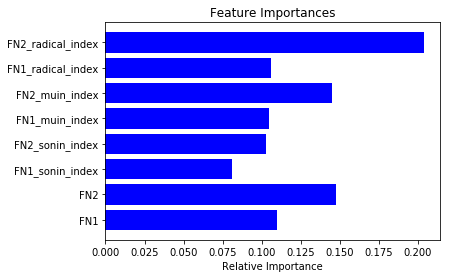

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.996343178622
Test Accuracy  ::  0.913252748455
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.11694243  0.16043192  0.07387465  0.09920225  0.10751465  0.14780887
  0.10269015  0.1915351 ]


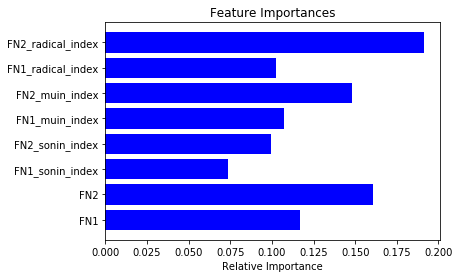

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.995897796531
Test Accuracy  ::  0.911830662364
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.12082182  0.15175359  0.07463875  0.09649966  0.11763443  0.13854299
  0.1125581   0.18755066]


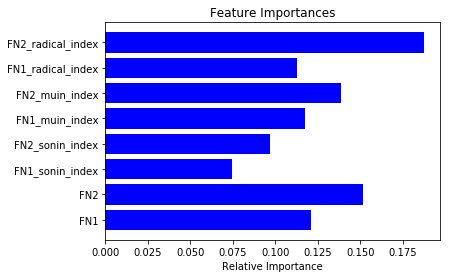

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 4
Train Accuracy ::  0.99650726676
Test Accuracy  ::  0.912869879123
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.1098827   0.15223117  0.07778506  0.10228738  0.1054917   0.14270093
  0.10514003  0.20448103]


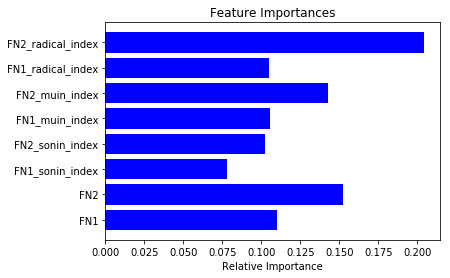

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 5
Train Accuracy ::  0.995991561181
Test Accuracy  ::  0.915167095116
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.12030253  0.14649065  0.07934696  0.10084694  0.1090174   0.13859017
  0.11217452  0.19323083]


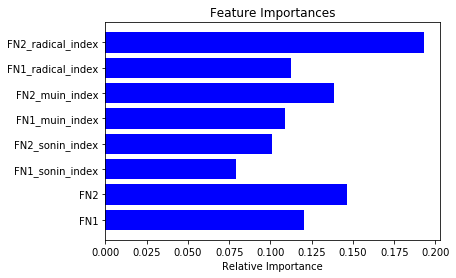

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 6
Train Accuracy ::  0.996425222691
Test Accuracy  ::  0.909424055133
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.11087252  0.14659971  0.07754416  0.09492355  0.10905694  0.14344693
  0.11377992  0.20377627]


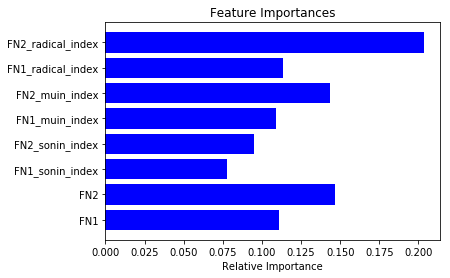

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 7
Train Accuracy ::  0.996132208158
Test Accuracy  ::  0.916561833397
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.1118349   0.15576219  0.07509471  0.10103525  0.10316803  0.14253698
  0.09768659  0.21288135]


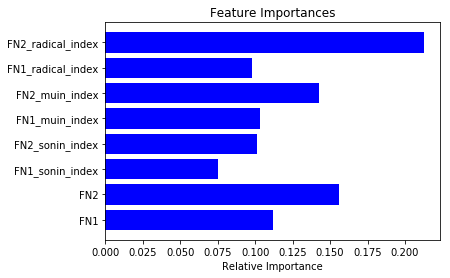

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 8
Train Accuracy ::  0.99580403188
Test Accuracy  ::  0.915905485971
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.11758865  0.15774512  0.07421469  0.10351179  0.10957514  0.1385953
  0.10094313  0.19782618]


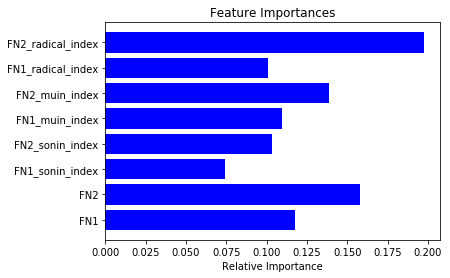

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



KeyboardInterrupt: 

In [288]:
#放第二個
x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index']
#x_feature = ['FN1','FN2','FN1_radical_index','FN2_radical_index']


y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,10)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.995757149555
Test Accuracy  ::  0.918968440628
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth']
[ 0.09097379  0.14504959  0.06245767  0.09417674  0.08433369  0.1465798
  0.07758046  0.22843805  0.07041021]


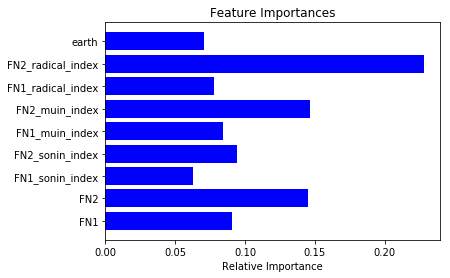

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.996225972808
Test Accuracy  ::  0.916069572827
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth']
[ 0.10168421  0.14135795  0.07025716  0.08782338  0.09951915  0.13412873
  0.09722577  0.19321657  0.07478709]


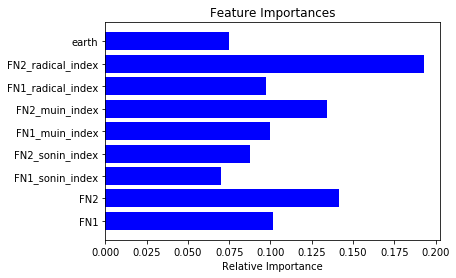

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.996050164088
Test Accuracy  ::  0.915139747306
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth']
[ 0.10731991  0.13228028  0.07142611  0.09101356  0.09628137  0.13652564
  0.09606586  0.19639449  0.07269278]


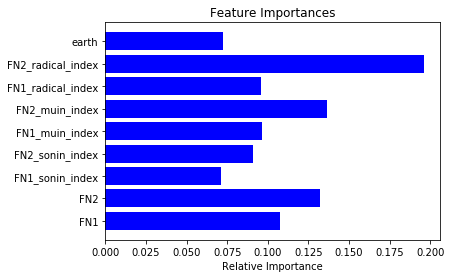

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 4
Train Accuracy ::  0.996343178622
Test Accuracy  ::  0.918038615107
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth']
[ 0.09320768  0.15169995  0.06368011  0.08884565  0.09284437  0.14085821
  0.08425711  0.21267038  0.07193654]


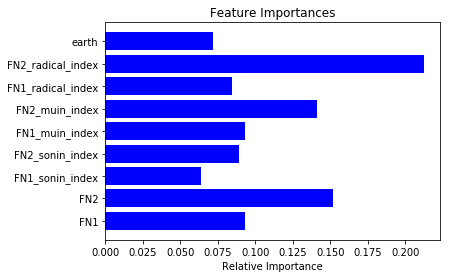

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 5
Train Accuracy ::  0.99658931083
Test Accuracy  ::  0.916862659301
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth']
[ 0.0965112   0.14575353  0.06123824  0.09276044  0.09159975  0.13042962
  0.09450817  0.21483879  0.07236027]


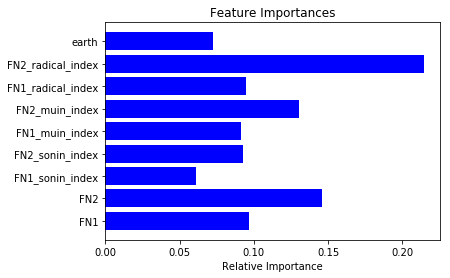

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 6
Train Accuracy ::  0.996225972808
Test Accuracy  ::  0.916261007493
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth']
[ 0.09946437  0.13355483  0.0652052   0.09004948  0.10561312  0.13864961
  0.08586573  0.20806775  0.07352991]


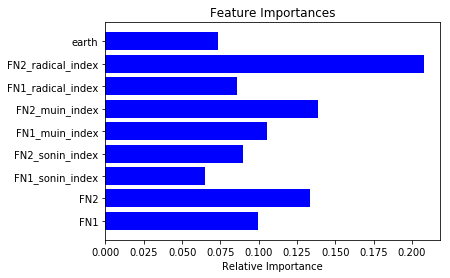

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 7
Train Accuracy ::  0.996460384435
Test Accuracy  ::  0.913580922168
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth']
[ 0.10704397  0.13093373  0.07270946  0.08958214  0.10418333  0.14061959
  0.09078581  0.18990597  0.074236  ]


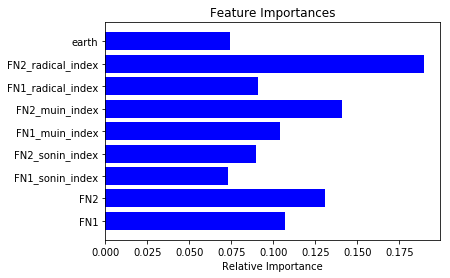

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 8
Train Accuracy ::  0.996577590248
Test Accuracy  ::  0.914127878357
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth']
[ 0.10408393  0.13170643  0.06914045  0.09300166  0.09581384  0.13844821
  0.1040679   0.18810234  0.07563525]


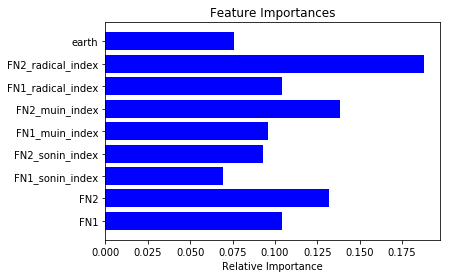

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 9
Train Accuracy ::  0.996202531646
Test Accuracy  ::  0.91546792102
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth']
[ 0.10011308  0.13928296  0.06425026  0.09067264  0.09054263  0.1389864
  0.08691045  0.21724811  0.07199347]


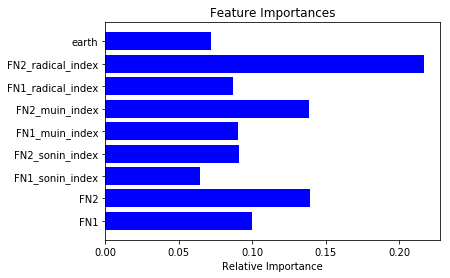

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 10
Train Accuracy ::  0.996073605251
Test Accuracy  ::  0.913362139693
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index', 'earth']
[ 0.10087141  0.1380494   0.06877178  0.08929864  0.10263216  0.13726835
  0.10377229  0.18600822  0.07332776]


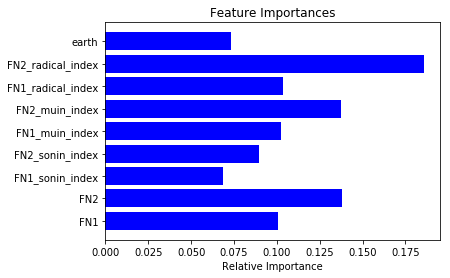

Average Train Accuracy ::  0.996250586029
Average Test Accuracy  ::  0.91578789039
[array([ 0.09097379,  0.14504959,  0.06245767,  0.09417674,  0.08433369,
        0.1465798 ,  0.07758046,  0.22843805,  0.07041021]), array([ 0.10168421,  0.14135795,  0.07025716,  0.08782338,  0.09951915,
        0.13412873,  0.09722577,  0.19321657,  0.07478709]), array([ 0.10731991,  0.13228028,  0.07142611,  0.09101356,  0.09628137,
        0.13652564,  0.09606586,  0.19639449,  0.07269278]), array([ 0.09320768,  0.15169995,  0.06368011,  0.08884565,  0.09284437,
        0.14085821,  0.08425711,  0.21267038,  0.07193654]), array([ 0.0965112 ,  0.14575353,  0.06123824,  0.09276044,  0.09159975,
        0.13042962,  0.09450817,  0.21483879,  0.07236027]), array([ 0.09946437,  0.13355483,  0.0652052 ,  0.09004948,  0.10561312,
        0.13864961,  0.08586573,  0.20806775,  0.07352991]), array([ 0.10704397,  0.13093373,  0.07270946,  0.08958214,  0.10418333,
        0.14061959,  0.09078581,  0.18990597, 

In [324]:
#放第二個
x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index','earth']
#x_feature = ['FN1','FN2','FN1_radical_index','FN2_radical_index']


y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,10)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.995616502579
Test Accuracy  ::  0.914756877974
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.13751942  0.1372954   0.08636594  0.09022586  0.12655071  0.12551042
  0.11435018  0.18218207]


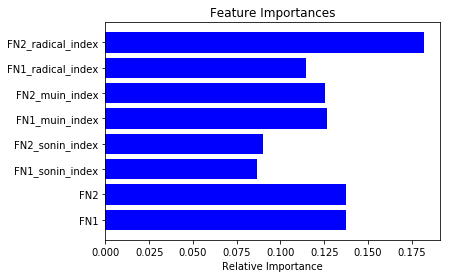

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.9959798406
Test Accuracy  ::  0.916807963682
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.13691278  0.14170947  0.08483964  0.08703207  0.1184671   0.12583254
  0.11468027  0.19052613]


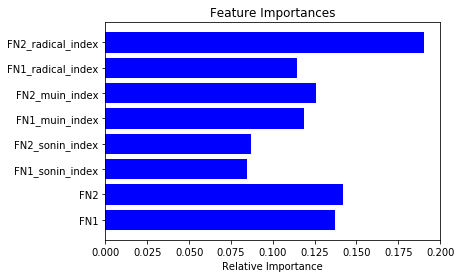

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.996343178622
Test Accuracy  ::  0.911666575507
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.13901257  0.12669537  0.08772808  0.08826029  0.12487517  0.11909114
  0.12809184  0.18624554]


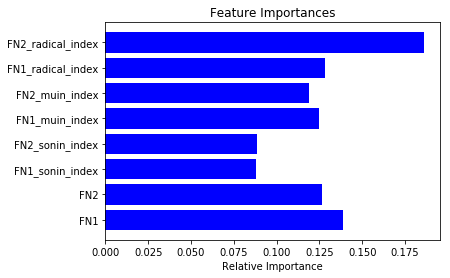

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 4
Train Accuracy ::  0.996108766995
Test Accuracy  ::  0.915686703495
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.14165196  0.12837181  0.08636201  0.08726767  0.12365727  0.11667514
  0.12358202  0.19243212]


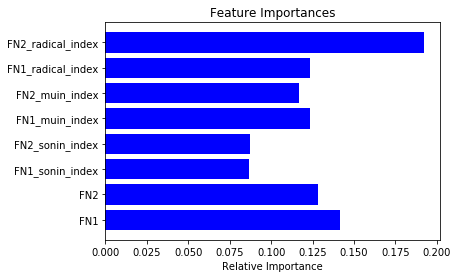

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 5
Train Accuracy ::  0.996190811064
Test Accuracy  ::  0.914920964831
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.13410813  0.1311323   0.08955888  0.08933751  0.12560786  0.11896147
  0.12779754  0.18349633]


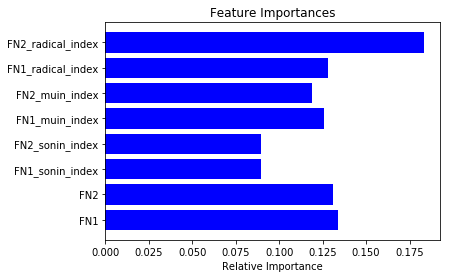

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 6
Train Accuracy ::  0.996554149086
Test Accuracy  ::  0.912049444839
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.14419474  0.12740688  0.08180594  0.09369799  0.12635269  0.12349953
  0.12331078  0.17973145]


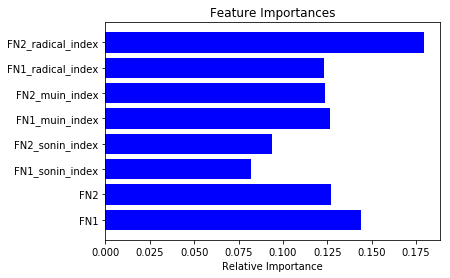

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 7
Train Accuracy ::  0.99580403188
Test Accuracy  ::  0.911885357983
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.13937726  0.13816685  0.08889201  0.0879632   0.13332989  0.11580976
  0.12909367  0.16736735]


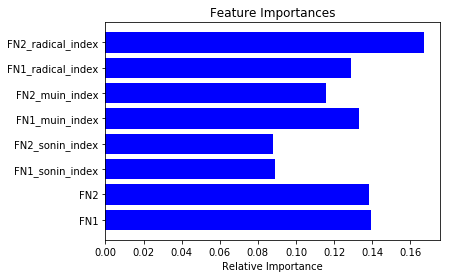

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 8
Train Accuracy ::  0.996378340366
Test Accuracy  ::  0.912924574742
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.13277483  0.13304944  0.08607767  0.08762386  0.12753025  0.12798415
  0.12200322  0.18295658]


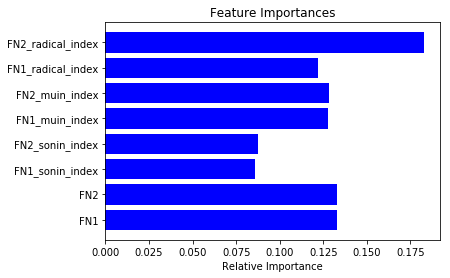

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 9
Train Accuracy ::  0.995780590717
Test Accuracy  ::  0.912049444839
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.14246816  0.1247809   0.08671216  0.09157398  0.13163014  0.1196529
  0.13127928  0.17190248]


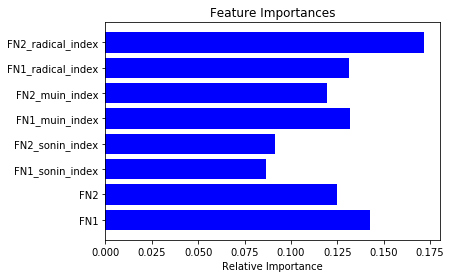

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 10
Train Accuracy ::  0.996296296296
Test Accuracy  ::  0.910764097796
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.1405618   0.12751528  0.09103526  0.08288744  0.12979573  0.1193778
  0.12032431  0.18850238]


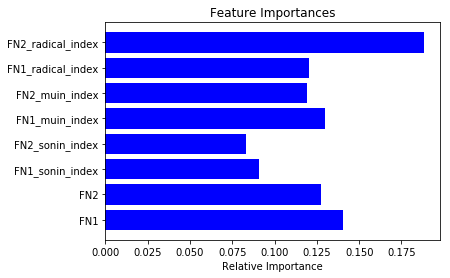

Average Train Accuracy ::  0.99610525082
Average Test Accuracy  ::  0.913351200569
[array([ 0.13751942,  0.1372954 ,  0.08636594,  0.09022586,  0.12655071,
        0.12551042,  0.11435018,  0.18218207]), array([ 0.13691278,  0.14170947,  0.08483964,  0.08703207,  0.1184671 ,
        0.12583254,  0.11468027,  0.19052613]), array([ 0.13901257,  0.12669537,  0.08772808,  0.08826029,  0.12487517,
        0.11909114,  0.12809184,  0.18624554]), array([ 0.14165196,  0.12837181,  0.08636201,  0.08726767,  0.12365727,
        0.11667514,  0.12358202,  0.19243212]), array([ 0.13410813,  0.1311323 ,  0.08955888,  0.08933751,  0.12560786,
        0.11896147,  0.12779754,  0.18349633]), array([ 0.14419474,  0.12740688,  0.08180594,  0.09369799,  0.12635269,
        0.12349953,  0.12331078,  0.17973145]), array([ 0.13937726,  0.13816685,  0.08889201,  0.0879632 ,  0.13332989,
        0.11580976,  0.12909367,  0.16736735]), array([ 0.13277483,  0.13304944,  0.08607767,  0.08762386,  0.12753025,
    

In [66]:
#放第一個
x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index']
#x_feature = ['FN1','FN2','FN1_radical_index','FN2_radical_index']


y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,10)

[ 0.11720402  0.16231961  0.07476416  0.0992065   0.10525079  0.14279952
  0.10544986  0.19300554]


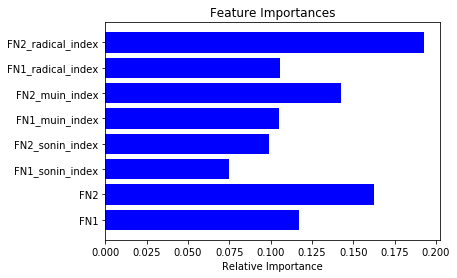

In [51]:
#放第二個的
features=   ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index','FN2_muin_index',
                 'FN1_radical_index','FN2_radical_index']
importances = gender_predicton_model.feature_importances_
#indices = np.argsort(importances)
print(importances)
plt.title('Feature Importances')
plt.barh(range(len(importances)), importances, color='b', align='center')
plt.yticks(range(len(importances)), features) ## removed [indices]
plt.xlabel('Relative Importance')
plt.show()

Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.13615834  0.13057917  0.08576468  0.09055573  0.12227055  0.12780267
  0.11097602  0.19589284]


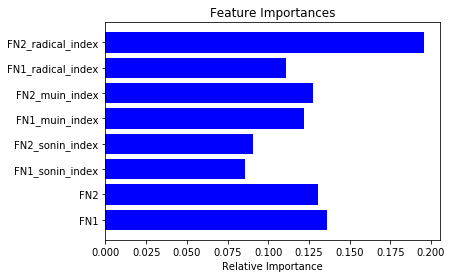

In [55]:
#放第一個的
features=   ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index','FN2_muin_index',
                 'FN1_radical_index','FN2_radical_index']
importances = gender_predicton_model.feature_importances_
#indices = np.argsort(importances)
print('Feature Importances')
print(features)
print(importances)
plt.title('Feature Importances')
plt.barh(range(len(importances)), importances, color='b', align='center')
plt.yticks(range(len(importances)), features) ## removed [indices]
plt.xlabel('Relative Importance')
plt.show()

Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.13231569  0.12803783  0.0892056   0.09253698  0.12554092  0.12422704
  0.12793383  0.18020212]


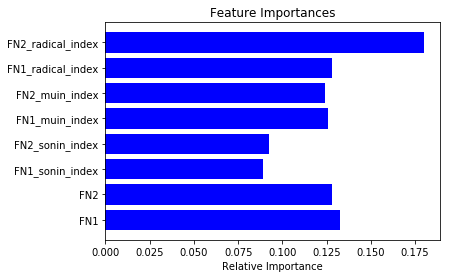

In [61]:
#放第一個的
features=   ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index','FN2_muin_index',
                 'FN1_radical_index','FN2_radical_index']
importances = gender_predicton_model.feature_importances_
#indices = np.argsort(importances)
print('Feature Importances')
print(features)
print(importances)
plt.title('Feature Importances')
plt.barh(range(len(importances)), importances, color='b', align='center')
plt.yticks(range(len(importances)), features) ## removed [indices]
plt.xlabel('Relative Importance')
plt.show()

In [50]:
gender_predicton_model.feature_importances_

array([ 0.11720402,  0.16231961,  0.07476416,  0.0992065 ,  0.10525079,
        0.14279952,  0.10544986,  0.19300554])

In [17]:
GuessGender('琳鴻')
GuessGender('鴻琳')


我猜 琳鴻 是:男生
我猜 鴻琳 是:女生


/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [19]:
with open('./data_output/final/moe_data_dict.txt', 'rb') as handle:
    moe_data_dict = pickle.loads(handle.read())

In [69]:
with open('./data_output/final/prob/gender_x_feature', 'rb') as handle:
    x_feature2 = pickle.loads(handle.read())

In [52]:
import pickle
filename = './data_output/final/gender_predicton_model.sav'
gender_predicton_model = pickle.load(open(filename, 'rb'))

In [70]:
print(len(x_feature),len(x_feature2))

7484 7484


In [67]:
# # save the model to disk
filename = './data_output/final/prob/gender_predicton_model.sav'
pickle.dump(gender_predicton_model, open(filename, 'wb'))

In [68]:
filename = './data_output/final/prob/gender_x_feature'
pickle.dump(x_feature,open(filename, 'wb'))

In [592]:
#moe pandas

moe_df = pd.DataFrame()
xls = pd.ExcelFile( '../moedict-data-master/dict_revised/dict_revised_1.xls')
moe_df = xls.parse(0)
print(len(moe_df))
xls = pd.ExcelFile( '../moedict-data-master/dict_revised/dict_revised_2.xls')
moe_df =  pd.concat((moe_df, xls.parse(0)))
print(len(moe_df))
xls = pd.ExcelFile( '../moedict-data-master/dict_revised/dict_revised_3.xls')
moe_df =  pd.concat((moe_df, xls.parse(0)))
print(len(moe_df))

KeyboardInterrupt: 

# Make complete Real_name_df

In [388]:
Real_name_df = pd.concat( [List_name_df,School_df,HS_gender_df])

In [313]:
resampled_gender.columns.values

array(['FirstName', 'LastName', 'gender', 'message', 'name', 'userID',
       'FN1', 'FN2', 'mgender', 'FN1_sonin', 'FN1_muin', 'FN2_sonin',
       'FN2_muin', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index',
       'FN2_muin_index', 'BirthYear', 'FN1_radical', 'FN2_radical',
       'FN1_radical_index', 'FN2_radical_index'], dtype=object)

In [10]:
#FN1 . FN2
Real_name_df['FN1'] = Real_name_df.FirstName.apply(lambda x: character_to_index(x,1))
Real_name_df['FN2'] = Real_name_df.FirstName.apply(lambda x: character_to_index(x,2))

NameError: name 'Real_name_df' is not defined

In [597]:
unkown_dict={}

In [598]:
#'FN1_sonin', 'FN1_muin', 'FN2_sonin','FN2_muin', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index',
#'FN2_muin_index', 'BirthYear', 'FN1_radical', 'FN2_radical','FN1_radical_index', 'FN2_radical_index'
Real_name_df['FN1_sonin'] = Real_name_df.FN1.apply(lambda x:  add_pin_in_column(x,'sonin') )
Real_name_df['FN1_muin'] = Real_name_df.FN1.apply(lambda x:  add_pin_in_column(x,'muin') )

Real_name_df['FN2_sonin'] = Real_name_df.FN2.apply(lambda x:  add_pin_in_column(x,'sonin') )
Real_name_df['FN2_muin'] = Real_name_df.FN2.apply(lambda x:  add_pin_in_column(x,'muin') )

In [599]:
unkown_list = sorted(unkown_dict.items(), key=operator.itemgetter(1),)
unkown_list.reverse()
print(unkown_list)

[]


# 補齊字典

In [606]:
count=0
for c in unkown_list:
    if c[0] not in moe_data_dict and is_chinese(c[0])==False:
        count+=unkown_dict[c[0]]

        print(count)

In [605]:
#子音.母音
Real_name_df['FN1_sonin_index'] = Real_name_df.FN1_sonin.apply(lambda x:  add_pin_in_index_column(x,'sonin') )
Real_name_df['FN2_sonin_index'] = Real_name_df.FN2_sonin.apply(lambda x:  add_pin_in_index_column(x,'sonin') )

Real_name_df['FN1_muin_index'] = Real_name_df.FN1_muin.apply(lambda x:  add_pin_in_index_column(x,'muin') )
Real_name_df['FN2_muin_index'] = Real_name_df.FN2_muin.apply(lambda x:  add_pin_in_index_column(x,'muin') )

In [135]:
#加上從1940~2010每5年一區間的欄位
def year_to_range(start,rang,year):
    y = int((year - start)/ rang)
    #2010
    if y==14:
        y=13
    return y

In [607]:
#部首

Real_name_df['BirthYear'] = Real_name_df.message.apply(lambda x: year_to_range(1940,5,x))

Real_name_df['FN1_radical'] = Real_name_df.FN1.apply(lambda x:add_radical_column(x))
Real_name_df['FN2_radical'] = Real_name_df.FN2.apply(lambda x:add_radical_column(x))

Real_name_df['FN1_radical_index'] = Real_name_df.FN1_radical.apply(lambda x:add_radical_index_column(x))
Real_name_df['FN2_radical_index'] = Real_name_df.FN2_radical.apply(lambda x:add_radical_index_column(x))
Real_name_df

FirstName LastName  gender  message name   FN1   FN2 FN1_sonin FN1_muin  \
0            梓惠        翁     NaN     1987  翁梓惠   562   106         z        ǐ   
1            霈昇        林     NaN     1987  林霈昇   646   818         p       èi   
2            雨潔        莊     NaN     1987  莊雨潔    80   147         y        ǔ   
3            昆展        詹     NaN     1987  詹昆展    66    39         k       ūn   
4            彥豪        陳     NaN     1987  陳彥豪   208    60         y       àn   
5            婉婷        沈     NaN     1987  沈婉婷   696    90         w       ǎn   
6            靜緹        胡     NaN     1987  胡靜緹   217   758         j      ìng   
7            彥勳        賴     NaN     1987  賴彥勳   208   117         y       àn   
8            采妮        劉     NaN     1987  劉采妮   372   710         c       ǎi   
9            宇鋒        許     NaN     1987  許宇鋒    10   642         y        ǔ   
10           莉婷        黃     NaN     1987  黃莉婷   457    90         l        ì   
11           慧文        陳     NaN     1987  陳慧文   124    28        hu        ì   
12           佩君        蔡     NaN     1987  蔡佩君   116   153         p       èi   
13           易錦        呂     NaN     1987  呂易錦   994   458         y        ì   
14           彥方        陳     NaN     1987  陳彥方   208   392         y       àn   
15           幸儀        黃     NaN     1987  黃幸儀  1137     7         x      ìng   
16           冠毅        劉     NaN     1987  劉冠毅   164    40         g      uān   
17           鉦庭        林     NaN     1987  林鉦庭   952    46        zh      ēng   
18           志侑        陳     NaN     1987  陳志侑    68   144        zh        ì   
19           靜宜        吳     NaN     1987  吳靜宜   217    16         j      ìng   
20           育聖        周     NaN     1987  周育聖   108   482         y        ù   
21            瑞        余     NaN     1987   余瑞   251    -1        ru        ì   
22            維        王     NaN     1987   王維   238    -1         w       éi   
23           雨馨        段     NaN     1987  段雨馨    80   528         y        ǔ   
24           定遠        陳     NaN     1987  陳定遠   950   286         d      ìng   
25           銘昌        陳     NaN     1987  陳銘昌    44   369         m      íng   
26           欣諺        吳     NaN     1987  吳欣諺    78   401         x       īn   
27           灝泯        劉     NaN     1987  劉灝泯  1222  1411         h       ào   
28           銘雱        姜     NaN     1987  姜銘雱    44  3474         m      íng   
29           坊瑩        余     NaN     1987  余坊瑩  1704   658         f      āng   
...         ...      ...     ...      ...  ...   ...   ...       ...      ...   
28566        月華        賴     0.0     1929  賴月華   706   123         y       uè   
28567        淑貞        賴     0.0     1929  賴淑貞   348   635        sh        ú   
28568        藹楚        錢     0.0     1929  錢藹楚  4044   409                 ǎi   
28569        汴宣        鮑     0.0     1929  鮑汴宣  4579   253         b      iàn   
28570        筱安        龍     0.0     1929  龍筱安    23    20         x      iǎo   
28571        美真        戴     0.0     1929  戴美真   140   653         m       ěi   
28573        宏弘        謝     0.0     1929  謝宏弘    27   385         h      óng   
28574        素貞        謝     0.0     1929  謝素貞   455   635         s        ù   
28575        麗香        謝     0.0     1929  謝麗香   203   341         l        ì   
28576        秀正        鍾     0.0     1929  鍾秀正    70   276         x       iù   
28577        和美        鍾     0.0     1929  鍾和美   122   140         h        é   
28578        金妹        鍾     0.0     1929  鍾金妹   280   126         j       īn   
28579        裕美        鍾     0.0     1929  鍾裕美   493   140         y        ù   
28580        燕琴        鍾     0.0     1929  鍾燕琴   298   429         y       àn   
28581        玉英        簡     0.0     1929  簡玉英   211   388         y        ù   
28582        素蘭        簡     0.0     1929  簡素蘭   455  1329         s        ù   
28583        榮昌        藍     0.0     1929  藍榮昌     4   369         r      óng   
28584        惠蓮        顏     0.0     

In [615]:
Real_name_df['BirthYear'] = Real_name_df.message.apply(lambda x: year_to_range(1940,5,x))


In [702]:
#make cname complete
# cname_df['LastName'] = cname_df.name.apply(lambda x: (GetLastName(x)))
# cname_df['FirstName'] = cname_df.name.apply(lambda x: (GetFirstName(x)))
# cname_df['FN1'] = cname_df.FirstName.apply(lambda x: character_to_index(x,1))
# cname_df['FN2'] = cname_df.FirstName.apply(lambda x: character_to_index(x,2))

# cname_df['FN1_sonin'] = cname_df.FN1.apply(lambda x:  add_pin_in_column(x,'sonin') )
# cname_df['FN1_muin'] = cname_df.FN1.apply(lambda x:  add_pin_in_column(x,'muin') )

# cname_df['FN2_sonin'] = cname_df.FN2.apply(lambda x:  add_pin_in_column(x,'sonin') )
# cname_df['FN2_muin'] = cname_df.FN2.apply(lambda x:  add_pin_in_column(x,'muin') )
# cname_df['FN1_sonin_index'] = cname_df.FN1_sonin.apply(lambda x:  add_pin_in_index_column(x,'sonin') )
# cname_df['FN2_sonin_index'] = cname_df.FN2_sonin.apply(lambda x:  add_pin_in_index_column(x,'sonin') )

# cname_df['FN1_muin_index'] = cname_df.FN1_muin.apply(lambda x:  add_pin_in_index_column(x,'muin') )
# cname_df['FN2_muin_index'] = cname_df.FN2_muin.apply(lambda x:  add_pin_in_index_column(x,'muin') )

# cname_df['FN1_radical'] = cname_df.FN1.apply(lambda x:add_radical_column(x))
# cname_df['FN2_radical'] = cname_df.FN2.apply(lambda x:add_radical_column(x))

# cname_df['FN1_radical_index'] = cname_df.FN1_radical.apply(lambda x:add_radical_index_column(x))
# cname_df['FN2_radical_index'] = cname_df.FN2_radical.apply(lambda x:add_radical_index_column(x))
cname_df.message = cname_df.message.apply(lambda x: int(x))
cname_df['BirthYear'] = cname_df.message.apply(lambda x: year_to_range(1940,5,x))
cname_df

name  message             userID LastName FirstName   FN1   FN2  \
0        雷霆     2002   1465701136787816        雷         霆   526    -1   
1       黃海銘     1995   1484433631589977        黃        海銘   292    44   
2       陳志亮     1986   1328211283930764        陳        志亮    68   896   
3       林士傑     2001    296012147484045        林        士傑   130   169   
4       翁玉妹     2003   1895288067372189        翁        玉妹   211   126   
5       陳巧瓶     1981   1375688302454662        陳        巧瓶   178  1609   
6       林松青     1992   1434724669881548        林        松青   514   241   
7       王宥勝     1987    770763393073431        王        宥勝   558   156   
8       趙凱揚     1995   1295109403905407        趙        凱揚    82   110   
9       宋茜沄     1985   1388946507832568        宋        茜沄  1227  2092   
10      羅文泰     1972   1550108411680341        羅        文泰    28   350   
11      舒子芸     2003   1796381430689469        舒        子芸   114   237   
12      葉千豪     1987   1414173521972695        葉        千豪   258    60   
13       伍生     1999   1414155308648948        伍         生    30    -1   
14      林義盛     1986   1048578891941316        林        義盛   650   561   
15      張家琪     1991   1530311903655556        張        家琪    29   384   
16       張豪     1997   1498310573577623        張         豪    60    -1   
17      鍾舒涵     1983   1824362987888148        鍾        舒涵   170   312   
18      賴威龍     1983    477854192605371        賴        威龍   531    69   
19      林怡廷     2004    191504144677977        林        怡廷   250    22   
20      顏怡潔     2002    857511391053895        顏        怡潔   250   147   
21      施孟瑋     1991   1372801542742499        施        孟瑋   196   135   
22      謝濰謙     1995   1473081852712317        謝        濰謙  1480   115   
23      蔡東翰     1995   1656873247674637        蔡        東翰   219   257   
24      張俊仁     1997   1241082882665191        張        俊仁    18   214   
25       尤君     1990   1450388804979446        尤         君   153    -1   
26      張美珍     2002    644509159078343        張        美珍   140   184   
27      何品萱     1997   1175592212563514        何        品萱   134    17   
28      林楷森     1996   1389792611042167        林        楷森    14   408   
29      徐彩騏     1998   1287497291303871        徐        彩騏    21   799   
...     ...      ...                ...      ...       ...   ...   ...   
731060  葉哲勳     1993    135373783743474        葉        哲勳   167   117   
731061  何冠冠     2008    663809233818202        何        冠冠   164   164   
731062  邱呈淵     1999   1796707933690667        邱        呈淵   111   721   
731063  邱佳琪     2005    351041895348477        邱        佳琪   173   384   
731064   文文     1994   1627415850623340        文         文    28    -1   
731065  吳振宇     1999    803885343108754        吳        振宇   382    10   
731066  獨愛伱     1996   1847628045255322        獨        愛伱   698  3759   
731067  吳生黴     1993  10154921708526404        吳        生黴    30  3760   
731068  郭政豪     2002    268428420338176        郭        政豪   285    60   
731069  黃微明     1999    913839378766328        黃        微明   263   159   
731070   龍氏     1991    804370026412022        龍         氏  2111    -1   
731071  顏湘孟     2004    269052463597778        顏        湘孟    74   196   
731072  蘇子原     2004    321286998333924        蘇        子原   114   702   
731073  姚建成     1998   1475153592566945        姚        建成    43   113   
731074  王洛嵐     2002    869236136561686        王        洛嵐   453   633   
731075  呂學修     1993   1509603699107162        呂        學修   293   129   
731076  黃淨梅     2000    819266638243405        黃        淨梅   394   189   
731077  李佩甄     2003    686250614914764        李        佩甄   116   573   
731078  楊芷妍     2002    262056130954579        楊        芷妍   192   301   
731079   卓敏     2003    266400523853122        卓         敏    59    -1   
731080  蘭郁玲     1991   1921849904498074        蘭        郁玲   306   207   
731081  李绍俊     1996    502658706736741        李        绍俊  2797    18   
731082  吳祥嘉

In [613]:
def fix_error(year):
    if year<1940:
        return year+18
    else:
        return year
Real_name_df['message'] = Real_name_df.message.apply(lambda x:fix_error(x))

In [705]:
def add_guess_gender_column():
    x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index','FN2_muin_index',
                 'FN1_radical_index','FN2_radical_index']
    test_x = cname_df[ x_feature ]
    predictions = gender_predicton_model.predict(test_x)
    #Real_name_df['GuessedGender'] = predictions
    cname_df['GuessedGender'] = predictions
add_guess_gender_column()


In [73]:
#Use real gender():
def real_gender(row):
    if row['gender']==1 or row['gender']==0 or row['gender']=='1' or row['gender']=='0':
        return int(row['gender'])
    else:
        return row['GuessedGender']
        
Real_name_df['GuessedGender'] = Real_name_df.apply(lambda row:real_gender(row),axis=1)
#cname_df['GuessedGender'] = cname_df.apply(lambda row:real_gender(row),axis=1)

In [78]:
save_df_to_csv(Real_name_df , './data_output/final/0.93/' ,'Real_name_df')

In [76]:
save_df_to_csv(resampled_gender , './data_output/final/0.93/' ,'resampled_gender')

In [77]:
save_df_to_csv(FB_name_df , './data_output/final/0.93/' ,'cname_df')

In [42]:
def wrtie_csv_df(row,File_csv,columns):
    output_string = ''
   
    row_len = len(columns)
    for index,i in enumerate(columns) :
        if index != (row_len-1):
            output_string+=(str(row[i])+',')
        else:
            output_string+=(str(row[i]))
    output_string+=('\n')
    File_csv.write(output_string)
    
def save_df_to_csv(data_df,path,FileName):
    
    File_csv =  open(path+FileName+'.csv','w')
    
    output_string = ''
    row_len = len(data_df.columns.values)
    for index,i in enumerate(data_df.columns.values): 
        if index != (row_len-1):
            output_string+=(i+',')
        else:
            output_string+=(i)
    output_string+='\n'   
    File_csv.write(output_string)
    
    
    data_df.apply(lambda row: wrtie_csv_df(row,File_csv,data_df.columns.values) ,axis=1)
    File_csv.close()

In [37]:
#計算三才五格
from mylib.fortune_calculator import Get_stroke
from mylib.fortune_calculator import get_stroke_state
from mylib.fortune_calculator import get_talent_state
from mylib.fortune_calculator import get_talent_type
from mylib.fortune_calculator import test_name_Fortune_telling
from mylib.fortune_calculator import stroke_earth
from mylib.fortune_calculator import stroke_heaven
from mylib.fortune_calculator import stroke_man
from mylib.fortune_calculator import stroke_outside
from mylib.fortune_calculator import stroke_total

In [38]:
    #resampled_gender['天格'] = resampled_gender.LastName.apply(lambda x:stroke_heaven(x))


In [56]:
# Real_name_df['天格'] = Real_name_df.LastName.apply(lambda x:stroke_heaven(x))
# Real_name_df['人格'] = Real_name_df.apply(lambda row:stroke_man(row),axis=1)
# Real_name_df['地格'] = Real_name_df.FirstName.apply(lambda x:stroke_earth(x))
# Real_name_df['外格'] = Real_name_df.apply(lambda row:stroke_outside(row),axis=1)
Real_name_df['總格'] = Real_name_df.apply(lambda row:strok_total(row),axis=1)


FB_name_df['天格'] = FB_name_df.LastName.apply(lambda x:stroke_heaven(x))
FB_name_df['人格'] = FB_name_df.apply(lambda row:stroke_man(row),axis=1)
FB_name_df['地格'] = FB_name_df.FirstName.apply(lambda x:stroke_earth(x))
FB_name_df['外格'] = FB_name_df.apply(lambda row:stroke_outside(row),axis=1)
FB_name_df['總格'] = FB_name_df.apply(lambda row:strok_total(row),axis=1)

In [39]:
#resampled_gender['人格'] = resampled_gender.apply(lambda row:stroke_man(row),axis=1)
#resampled_gender['地格'] = resampled_gender.FirstName.apply(lambda x:stroke_earth(x))
#resampled_gender['總格'] = resampled_gender.apply(lambda row:strok_total(row),axis=1)

In [689]:
x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index','FN2_muin_index','FN1_radical_index','FN2_radical_index',
             '總格','天格','人格','地格','外格']
y_feature = ['mgender']

basic_RFClassifier(resampled_gender,x_feature,y_feature,3)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 1
Train Accuracy ::  0.995827473043
Test Accuracy  ::  0.905130449051


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 2
Train Accuracy ::  0.996015002344
Test Accuracy  ::  0.906552535142


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Run times: 3
Train Accuracy ::  0.996390060947
Test Accuracy  ::  0.905841492096
Average Train Accuracy ::  0.996077512111
Average Test Accuracy  ::  0.905841492096


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#試著 category後看看

In [42]:
len(resampled_gender.dtypes)

28

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  1.0
Test Accuracy  ::  0.927391565936
Feature Importances
['FN1', 'FN2', 'FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.13450955  0.1314528   0.08502598  0.09050985  0.12532008  0.12582192
  0.11924053  0.18811929]


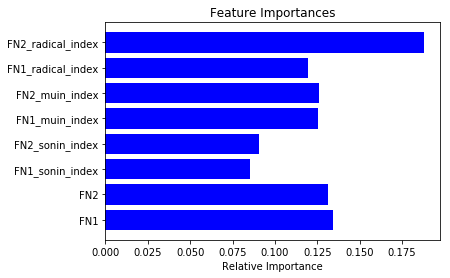

In [26]:
x_feature = ['FN1','FN2','FN1_sonin_index','FN2_sonin_index','FN1_muin_index',
             'FN2_muin_index','FN1_radical_index','FN2_radical_index']
#x_feature = ['FN1','FN2','FN1_radical_index','FN2_radical_index']


y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,1)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  0.823851383029
Test Accuracy  ::  0.792074604824
Feature Importances
['FN1_radical_index', 'FN2_radical_index']
[ 0.39767394  0.60232606]


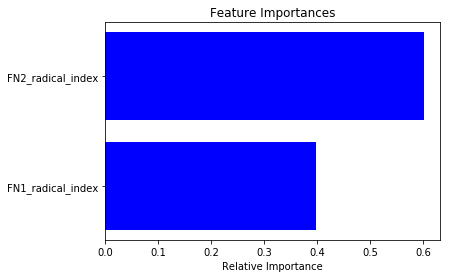

In [28]:
#精簡版測試，但是為啥classifier吃str type..
x_feature = ['LastName','FN2_radical_index']
y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,1)

In [32]:
resampled_gender

FirstName LastName gender message name            userID   FN1   FN2  \
0             民任        吳      1    1947  吳民任               NaN   335   297   
1             昭呈        劉      1    1965  劉昭呈               NaN   462   111   
2             恩田        莊      1    1959  莊恩田               NaN    86   202   
3             呈祥        林      1    1951  林呈祥               NaN   111   165   
4             碧山        廖      1    1944  廖碧山               NaN  1287   447   
5             進國        徐      1    1962  徐進國               NaN   474   436   
6             正鎰        林      1    1969  林正鎰               NaN   276  1868   
7             中柱        吳      1    1958  吳中柱               NaN   321  2039   
8             漢瀛        楊      1    1952  楊漢瀛               NaN   575  2353   
9             浚輝        張      1    1994  張浚輝  1742571835772284   502   315   
10            蘭娣        白      1    1993  白蘭娣  1897631213807925  1329  1465   
11            傳懷        陳      1    1964  陳傳懷               NaN   720   930   
12            希宇        陳      1    1962  陳希宇               NaN   610    10   
13            智彭        林      1    1956  林智彭               NaN   336  2104   
14            庭宇        劉      1    1994  劉庭宇  1362260720509643    46    10   
15            宥霖        陳      1    1990  陳宥霖  1540332902646407   558   143   
16            國建        謝      1    1948  謝國建               NaN   436    43   
17            志穎        林      1    1994  林志穎  1682859848409878    68   154   
18            守國        史      1    1947  史守國               NaN   422   436   
19             傑        王      1    2001   王傑  1114345485376859   169    -1   
20            蓬欽        王      1    1958  王蓬欽               NaN  2606  1272   
21            義傑        黃      1    1994  黃義傑  1293926820685819   650   169   
22            楷誌        王      1    1996  王楷誌  1264702423599040    14   220   
23            德興        郭      1    1944  郭德興               NaN   142   504   
24            昭明        陳      1    1926  陳昭明               NaN   462   159   
25            子毅        李      1    2004  李子毅   808085149340727   114    40   
26            惟揚        李      1    1997  李惟揚  1339604809456798   490   110   
27            存隆        何      1    1954  何存隆               NaN   577   141   
28            建璋        吳      1    1984  吳建璋  1458346484237558    43   584   
29            尚正        裘      1    1930  裘尚正               NaN   636   276   
...          ...      ...    ...     ...  ...               ...   ...   ...   
121856        月華        賴      0    1929  賴月華               NaN   706   123   
121857        淑貞        賴      0    1929  賴淑貞               NaN   348   635   
121858        藹楚        錢      0    1929  錢藹楚               NaN  4044   409   
121859        汴宣        鮑      0    1929  鮑汴宣               NaN  4579   253   
121860        筱安        龍      0    1929  龍筱安               NaN    23    20   
121861        美真        戴      0    1929  戴美真               NaN   140   653   
121862        宏弘        謝      0    1929  謝宏弘               NaN    27   385   
121863        素貞        謝      0    1929  謝素貞               NaN   455   635   
121864        麗香        謝      0    1929  謝麗香               NaN   203   341   
121865        秀正        鍾      0    1929  鍾秀正               NaN    70   276   
121866        和美        鍾      0    1929  鍾和美               NaN   122   140   
121867        金妹        鍾      0    1929  鍾金妹               NaN   280   126   
121868        裕美        鍾      0    1929  鍾裕美               NaN   493   140   
121869        燕琴        鍾      0    1929  鍾燕琴               NaN   298   429   
121870        玉英        簡      0    1929  簡玉英               NaN   211   388   
121871        素蘭        簡      0    1929  簡素蘭               NaN   455  1329   
121872        榮昌        藍      0    1929  藍榮昌               NaN     4   369   
121873        惠蓮        顏      0    1929  顏惠蓮               NaN   106   496   
121874        紫玲        羅      0    1929  羅紫玲            

In [78]:
x_feature = ['FirstName1','FirstName2']
y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,1)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



ValueError: could not convert string to float: '鴻'

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  0.837257142857
Test Accuracy  ::  0.780933333333
Feature Importances
['FN1_radical_index_cat', 'FN2_radical_index_cat']
[ 0.4233819  0.5766181]


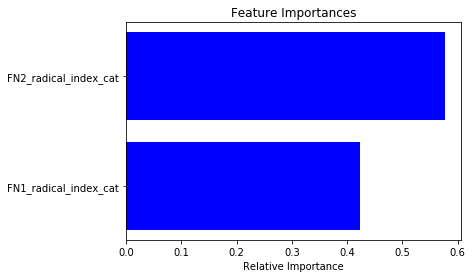

In [39]:
x_feature = ['FN1_radical_index_cat','FN2_radical_index_cat']
y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(pd,x_feature,y_feature,1)

In [46]:
df = resampled_gender.sample(50000)

In [31]:
#check_memory_usage():
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
object_size = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
for index,obj in enumerate(object_size):
    if index>10:
        break
    print('FileName:',obj[0],'FileSize:',obj[1]/1000000,'MB')

FileName: resampled_gender FileSize: 232.201769 MB
FileName: moe_data_dict FileSize: 6.291552 MB
FileName: moe_additional_dict FileSize: 0.393312 MB
FileName: specail_word_dict FileSize: 0.0984 MB
FileName: Totalname_list FileSize: 0.072112 MB
FileName: Taiwan_LastName_List FileSize: 0.012096 MB
FileName: Taiwan_LastName_len1_List FileSize: 0.011184 MB
FileName: Error_character FileSize: 0.004096 MB
FileName: radical_list FileSize: 0.002064 MB
FileName: mu_in_list FileSize: 0.001624 MB
FileName: BalanceCascade FileSize: 0.001016 MB


In [98]:
#使用word to vector
from gensim.models import word2vec
#moe_model = word2vec.Word2Vec.load("./data_output/dict_to_vector/只用萌典/moe_med250_4.model.bin")
#moe_model = word2vec.Word2Vec.load("./data_output/moe/1/moe_med250_5.model.bin")
moe_model = word2vec.Word2Vec.load("./data_output/moe/moe_med250_6.model.bin")

In [99]:
%%time 

def add_word_vector(word,n):
    if word in moe_model.wv:
        return moe_model.wv[word][n]
    else:
        return 0
    

x_feature=[]
FirstName1_list = resampled_gender.FirstName1.tolist()
FirstName2_list = resampled_gender.FirstName2.tolist()

for i in range(0,250):
    tmp1_list=[]
    tmp2_list=[]
    for word in FirstName1_list:
        tmp1_list.append(add_word_vector(word,i))
    for word in FirstName2_list:
        tmp2_list.append(add_word_vector(word,i))

    
    resampled_gender['FN1_wv_'+str(i)] = tmp1_list
    resampled_gender['FN2_wv_'+str(i)] = tmp2_list
    
    x_feature.append('FN1_wv_'+str(i))
    x_feature.append('FN2_wv_'+str(i))


CPU times: user 3min 32s, sys: 116 ms, total: 3min 32s
Wall time: 3min 33s


In [34]:
resampled_gender = pd.get_dummies(resampled_gender, columns=["FN2_radical"])
resampled_gender = pd.get_dummies(resampled_gender, columns=["FN1_radical"])
resampled_gender = pd.get_dummies(resampled_gender, columns=["FN1_sonin"])
resampled_gender = pd.get_dummies(resampled_gender, columns=["FN2_sonin"])
resampled_gender =  pd.get_dummies(resampled_gender, columns=["FN1_muin"])
resampled_gender = pd.get_dummies(resampled_gender, columns=["FN2_muin"])
resampled_gender = pd.get_dummies(resampled_gender, columns=["FirstName1"])
resampled_gender = pd.get_dummies(resampled_gender, columns=["FirstName2"])

In [108]:
for index, x in enumerate(resampled_gender.columns.values):
    if 'FirstName' in x and '_' in x:
        x_feature.append(x)
        #x_feature.remove(x)
print(len(x_feature))

7242


7242


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



Train Accuracy ::  1.0
Test Accuracy  ::  0.935842039053
Feature Importances
['FN1_wv_0', 'FN2_wv_0', 'FN1_wv_1', 'FN2_wv_1', 'FN1_wv_2', 'FN2_wv_2', 'FN1_wv_3', 'FN2_wv_3', 'FN1_wv_4', 'FN2_wv_4', 'FN1_wv_5', 'FN2_wv_5', 'FN1_wv_6', 'FN2_wv_6', 'FN1_wv_7', 'FN2_wv_7', 'FN1_wv_8', 'FN2_wv_8', 'FN1_wv_9', 'FN2_wv_9', 'FN1_wv_10', 'FN2_wv_10', 'FN1_wv_11', 'FN2_wv_11', 'FN1_wv_12', 'FN2_wv_12', 'FN1_wv_13', 'FN2_wv_13', 'FN1_wv_14', 'FN2_wv_14', 'FN1_wv_15', 'FN2_wv_15', 'FN1_wv_16', 'FN2_wv_16', 'FN1_wv_17', 'FN2_wv_17', 'FN1_wv_18', 'FN2_wv_18', 'FN1_wv_19', 'FN2_wv_19', 'FN1_wv_20', 'FN2_wv_20', 'FN1_wv_21', 'FN2_wv_21', 'FN1_wv_22', 'FN2_wv_22', 'FN1_wv_23', 'FN2_wv_23', 'FN1_wv_24', 'FN2_wv_24', 'FN1_wv_25', 'FN2_wv_25', 'FN1_wv_26', 'FN2_wv_26', 'FN1_wv_27', 'FN2_wv_27', 'FN1_wv_28', 'FN2_wv_28', 'FN1_wv_29', 'FN2_wv_29', 'FN1_wv_30', 'FN2_wv_30', 'FN1_wv_31', 'FN2_wv_31', 'FN1_wv_32', 'FN2_wv_32', 'FN1_wv_33', 'FN2_wv_33', 'FN1_wv_34', 'FN2_wv_34', 'FN1_wv_35', 'FN2_wv_35', 'FN1_w

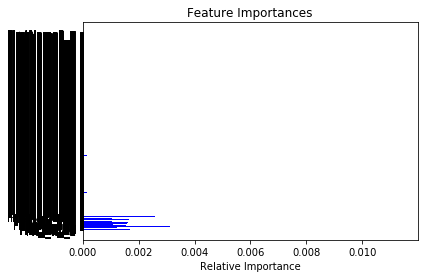

In [37]:
#x_feature = []
#字
y_feature = 'mgender'


gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,1)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  1.0
Test Accuracy  ::  0.932232128207
Feature Importances
['FirstName1_ ', 'FirstName1_一', 'FirstName1_丁', 'FirstName1_七', 'FirstName1_三', 'FirstName1_上', 'FirstName1_不', 'FirstName1_丕', 'FirstName1_世', 'FirstName1_丘', 'FirstName1_丙', 'FirstName1_东', 'FirstName1_丝', 'FirstName1_丞', 'FirstName1_並', 'FirstName1_丫', 'FirstName1_中', 'FirstName1_丰', 'FirstName1_丸', 'FirstName1_丹', 'FirstName1_为', 'FirstName1_主', 'FirstName1_丽', 'FirstName1_乂', 'FirstName1_乃', 'FirstName1_久', 'FirstName1_义', 'FirstName1_之', 'FirstName1_乎', 'FirstName1_乐', 'FirstName1_乓', 'FirstName1_乘', 'FirstName1_乙', 'FirstName1_九', 'FirstName1_也', 'FirstName1_书', 'FirstName1_乾', 'FirstName1_亂', 'FirstName1_予', 'FirstName1_事', 'FirstName1_二', 'FirstName1_于', 'FirstName1_云', 'FirstName1_互', 'FirstName1_五', 'FirstName1_井', 'FirstName1_亘', 'FirstName1_亙', 'FirstName1_些', 'FirstName1_亜', 'FirstName1_亞', 'FirstName1_交', 'FirstName1_亥', 'FirstName1_亦', 'FirstName1_亨', 'FirstName1_享', 'FirstName1_京', 'FirstName

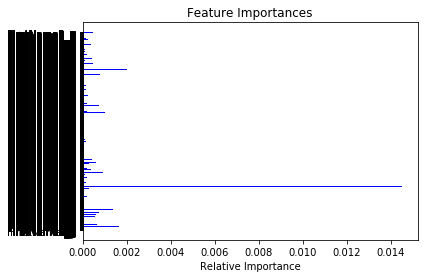

In [48]:
y_feature = ['mgender']
gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,1)

In [52]:
fi = gender_predicton_model.feature_importances_.tolist()
print(x_feature[fi.index(max(fi))])

FirstName1_淑


In [109]:
#部首
for index, x in enumerate(resampled_gender.columns.values):
    if 'FN1_radical_' in x or 'FN2_radical_' in x:
        x_feature.append(x)
print(len(x_feature))

#發音
for index, x in enumerate(resampled_gender.columns.values):
    if 'FN1_muin_' in x or 'FN2_muin_' in x or 'FN1_sonin_' in x or 'FN2_sonin_' in x:
        x_feature.append(x)
print(len(x_feature))


7657
7981


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  1.0
Test Accuracy  ::  0.937100038287
Feature Importances
['FirstName1_ ', 'FirstName1_一', 'FirstName1_丁', 'FirstName1_七', 'FirstName1_三', 'FirstName1_上', 'FirstName1_不', 'FirstName1_丕', 'FirstName1_世', 'FirstName1_丘', 'FirstName1_丙', 'FirstName1_东', 'FirstName1_丝', 'FirstName1_丞', 'FirstName1_並', 'FirstName1_丫', 'FirstName1_中', 'FirstName1_丰', 'FirstName1_丸', 'FirstName1_丹', 'FirstName1_为', 'FirstName1_主', 'FirstName1_丽', 'FirstName1_乂', 'FirstName1_乃', 'FirstName1_久', 'FirstName1_义', 'FirstName1_之', 'FirstName1_乎', 'FirstName1_乐', 'FirstName1_乓', 'FirstName1_乘', 'FirstName1_乙', 'FirstName1_九', 'FirstName1_也', 'FirstName1_书', 'FirstName1_乾', 'FirstName1_亂', 'FirstName1_予', 'FirstName1_事', 'FirstName1_二', 'FirstName1_于', 'FirstName1_云', 'FirstName1_互', 'FirstName1_五', 'FirstName1_井', 'FirstName1_亘', 'FirstName1_亙', 'FirstName1_些', 'FirstName1_亜', 'FirstName1_亞', 'FirstName1_交', 'FirstName1_亥', 'FirstName1_亦', 'FirstName1_亨', 'FirstName1_享', 'FirstName1_京', 'FirstName

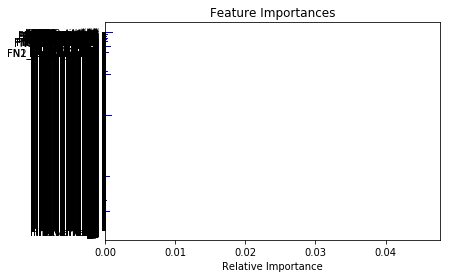

CPU times: user 20min 24s, sys: 12.7 s, total: 20min 36s
Wall time: 8min 59s


In [55]:
%%time
gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,1)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  1.0
Test Accuracy  ::  0.938631515616
Feature Importances
['FirstName1_ ', 'FirstName1_一', 'FirstName1_丁', 'FirstName1_七', 'FirstName1_三', 'FirstName1_上', 'FirstName1_不', 'FirstName1_丕', 'FirstName1_世', 'FirstName1_丘', 'FirstName1_丙', 'FirstName1_东', 'FirstName1_丝', 'FirstName1_丞', 'FirstName1_並', 'FirstName1_丫', 'FirstName1_中', 'FirstName1_丰', 'FirstName1_丸', 'FirstName1_丹', 'FirstName1_为', 'FirstName1_主', 'FirstName1_丽', 'FirstName1_乂', 'FirstName1_乃', 'FirstName1_久', 'FirstName1_义', 'FirstName1_之', 'FirstName1_乎', 'FirstName1_乐', 'FirstName1_乓', 'FirstName1_乘', 'FirstName1_乙', 'FirstName1_九', 'FirstName1_也', 'FirstName1_书', 'FirstName1_乾', 'FirstName1_亂', 'FirstName1_予', 'FirstName1_事', 'FirstName1_二', 'FirstName1_于', 'FirstName1_云', 'FirstName1_互', 'FirstName1_五', 'FirstName1_井', 'FirstName1_亘', 'FirstName1_亙', 'FirstName1_些', 'FirstName1_亜', 'FirstName1_亞', 'FirstName1_交', 'FirstName1_亥', 'FirstName1_亦', 'FirstName1_亨', 'FirstName1_享', 'FirstName1_京', 'FirstName

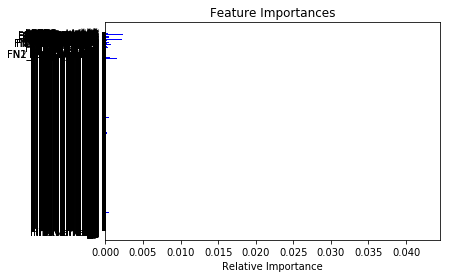

CPU times: user 20min 3s, sys: 13.9 s, total: 20min 17s
Wall time: 8min 58s


In [27]:
%%time
x_feature.append('地格')
x_feature.append('外格')
x_feature.append('總格')
y_feature = ['mgender']
gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,1)

In [110]:
%%time
x_feature.append('地格')
# x_feature.append('外格')
# x_feature.append('總格')

y_feature = ['mgender']
gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,1)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  1.0
Test Accuracy  ::  0.935732647815
男 昌桂 0.47265625 0.52734375 Real name
男 珍平 0.47265625 0.52734375 Real name
男 亮穎 0.48828125 0.51171875 Real name
男 雪峰 0.3671875 0.6328125 Real name
男 展如 0.21875 0.78125 Real name
男 晞文 0.33984375 0.66015625 FB
女 右昕 0.52734375 0.47265625 FB
女 鵠霙 0.5859375 0.4140625 FB
男 聆墀 0.43359375 0.56640625 Real name
男 善鈺 0.3046875 0.6953125 Real name
女 禹杜 0.5390625 0.4609375 Real name
男 祖驊 0.0703125 0.9296875 Real name
女 雲晴 0.87109375 0.12890625 Real name
女 一岑 0.83203125 0.16796875 Real name
男 改應 0.359375 0.640625 FB
女 惠鑫 0.80078125 0.19921875 Real name
女 夏凝 0.640625 0.359375 FB
男 柏騫 0.24609375 0.75390625 FB
女 秀璣 0.80859375 0.19140625 Real name
男 哎沁 0.171875 0.828125 FB
男 亞明 0.37890625 0.62109375 Real name
男 仪刘 0.359375 0.640625 FB
男 芳明 0.4921875 0.5078125 Real name
女  隻 0.50390625 0.49609375 FB
女 騰芠 0.8671875 0.1328125 FB
男 振振 0.0703125 0.9296875 Real name
女 能白 0.54296875 0.45703125 Real name
男 依宸 0.3359375 0.6640625 FB
女 笛笛 0.52734375 0.472656

男 孟釗 0.33984375 0.66015625 FB
男 承琰 0.3046875 0.6953125 Real name
女 郁雲 0.8359375 0.1640625 Real name
女 可向 0.65625 0.34375 Real name
男 慶洮 0.296875 0.703125 Real name
女 意淨 0.765625 0.234375 FB
男 妊凡 0.359375 0.640625 FB
男 振璉 0.32421875 0.67578125 Real name
女  蔣 0.60546875 0.39453125 FB
男 佳星 0.40234375 0.59765625 FB
男 好威 0.19921875 0.80078125 FB
女  帆 0.8125 0.1875 Real name
男 錦柏 0.2578125 0.7421875 Real name
男 玟廷 0.46875 0.53125 FB
男 永宜 0.40625 0.59375 Real name
女 孟斐 0.6171875 0.3828125 Real name
男 銘春 0.36328125 0.63671875 Real name
男 坤縉 0.01171875 0.98828125 FB
女 翼如 0.578125 0.421875 Real name
男 燕星 0.44921875 0.55078125 Real name
女 籃菁 0.78515625 0.21484375 FB
男 沂霖 0.28125 0.71875 FB
男 韋衣 0.4453125 0.5546875 FB
女 玉和 0.76171875 0.23828125 Real name
女 朝馨 0.9609375 0.0390625 Real name
男 新仁 0.07421875 0.92578125 Real name
女 秋露 0.6796875 0.3203125 FB
女 俞僅 0.859375 0.140625 FB
女 世琦 0.51171875 0.48828125 Real name
女 堃蘭 0.99609375 0.00390625 Real name
男 罔市 0.359375 0.640625 Real name
男 金廈 0.4296875

男 白松 0.16796875 0.83203125 Real name
男 扌丁 0.03125 0.96875 FB
女 經文 0.55859375 0.44140625 Real name
男 期期 0.234375 0.765625 FB
女 慶能 0.6484375 0.3515625 Real name
男 承眞 0.078125 0.921875 FB
男 倍稜 0.4765625 0.5234375 FB
男 霈林 0.359375 0.640625 FB
男 文徵 0.23046875 0.76953125 Real name
男 新均 0.1015625 0.8984375 Real name
女 德涵 0.55078125 0.44921875 Real name
女 曉立 0.6640625 0.3359375 Real name
女 以倫 0.70703125 0.29296875 Real name
女 宸荃 0.52734375 0.47265625 FB
女 冰韩 0.77734375 0.22265625 FB
男 昇咲 0.08984375 0.91015625 FB
男 重德 0.0546875 0.9453125 Real name
女 利禎 0.55078125 0.44921875 FB
男 齁齁 0.30078125 0.69921875 FB
男 在喫 0.45703125 0.54296875 FB
男 明曲 0.375 0.625 Real name
女 雅棠 0.66015625 0.33984375 Real name
女 正英 0.61328125 0.38671875 Real name
男 冬成 0.21875 0.78125 Real name
女 懿語 0.7421875 0.2578125 FB
女  結 0.51953125 0.48046875 FB
男  槳 0.48046875 0.51953125 FB
男 思湖 0.35546875 0.64453125 Real name
女 玟諴 0.53515625 0.46484375 FB
女 向塋 0.5234375 0.4765625 Real name
女 顧馨 0.74609375 0.25390625 Real name
男 延禕 0

男 宥諭 0.4296875 0.5703125 FB
女 晨光 0.7109375 0.2890625 Real name
男 家枚 0.46875 0.53125 Real name
男 傳錦 0.36328125 0.63671875 Real name
女 槿雲 0.83203125 0.1640625 FB
男 韓允 0.390625 0.60546875 FB
男 緣桑 0.3515625 0.64453125 FB
女 嘉俞 0.54296875 0.453125 Real name
男 華李 0.39453125 0.6015625 Real name
男  府 0.3984375 0.59765625 FB
男 慶渝 0.36328125 0.6328125 Real name
女 雨楓 0.7265625 0.26953125 FB
女 照琳 0.8359375 0.16015625 Real name
男 小程 0.28515625 0.7109375 FB
男 斌孔 0.41796875 0.578125 FB
男 昌耀 0.08203125 0.9140625 Real name
男 秀松 0.45703125 0.5390625 Real name
男 克卿 0.3984375 0.59765625 Real name
女 律光 0.70703125 0.2890625 Real name
女 心瀚 0.515625 0.48046875 FB
男 曼柏 0.4453125 0.55078125 Real name
女 雅棠 0.66015625 0.33984375 Real name
女 秀麒 0.69921875 0.30078125 Real name
女 財欣 0.56640625 0.43359375 Real name
男  完 0.4140625 0.5859375 Real name
女 健蓉 0.64453125 0.35546875 Real name
男 孟辰 0.32421875 0.67578125 FB
女 暟涵 1.0 0.0 FB
女 雄君 0.5625 0.4375 Real name
男 襄國 0.1796875 0.8203125 Real name
男  晝 0.49609375 0.503906

男 囿囿 0.4453125 0.5546875 FB
男 亦恩 0.42578125 0.57421875 FB
男 淳宇 0.31640625 0.68359375 Real name
女 海若 0.7265625 0.26953125 Real name
女 里屏 0.5234375 0.46875 Real name
女 秀峯 0.75390625 0.23828125 Real name
男 鈺家 0.21484375 0.78125 FB
女 彩璍 0.984375 0.01171875 FB
男 必問 0.203125 0.796875 FB
男 子聿 0.3828125 0.6171875 FB
女 清桂 0.54296875 0.45703125 Real name
男 以澄 0.24609375 0.75390625 FB
女 涵清 0.53125 0.46875 Real name
男 錦瀛 0.44140625 0.5546875 Real name
男 鴻湘 0.3671875 0.62890625 Real name
男 嘉勵 0.48046875 0.515625 Real name
男 信如 0.28125 0.71484375 Real name
男 智園 0.3046875 0.6875 Real name
男 咏諭 0.44140625 0.55859375 FB
男 菁煜 0.453125 0.546875 Real name
女 碩卿 0.546875 0.453125 Real name
男 珉赫 0.296875 0.703125 FB
男 芯霖 0.421875 0.578125 FB
男 境文 0.36328125 0.63671875 FB
男 佳叡 0.38671875 0.61328125 FB
女 靖之 0.875 0.12109375 Real name
女 沙宣 0.6875 0.30859375 FB
男 可莘 0.48046875 0.515625 FB
男 櫻王 0.35546875 0.63671875 FB
男 元樂 0.375 0.6171875 Real name
男 右昀 0.45703125 0.53515625 FB
女 文彤 0.69140625 0.30078125 Real na

男 百東 0.1875 0.80859375 FB
男 夜合 0.421875 0.57421875 Real name
女 大綏 0.82421875 0.171875 Real name
女 聰雅 0.7578125 0.23828125 Real name
女 日琳 0.6875 0.30859375 Real name
女  倜 0.5546875 0.44140625 Real name
女 竹閔 0.54296875 0.453125 FB
女 士榆 0.51953125 0.47265625 Real name
女 奇緣 0.68359375 0.30859375 FB
男 新芛 0.20703125 0.79296875 FB
男 聲銀 0.4609375 0.5390625 Real name
女 南旋 0.5546875 0.4453125 Real name
男 家暐 0.3125 0.6875 FB
女 剛屏 0.98828125 0.01171875 Real name
女 蘊琴 0.89453125 0.10546875 Real name
女 升圓 0.578125 0.41796875 Real name
女 如雲 0.66796875 0.328125 Real name
男 紀亘 0.421875 0.57421875 FB
男 邦復 0.16796875 0.828125 Real name
女 鐵璧 0.56640625 0.4296875 Real name
女 和庭 0.87109375 0.125 Real name
女 英和 0.5859375 0.41015625 Real name
男 童又 0.4921875 0.5 FB
女 育禎 0.54296875 0.44921875 FB
男 位禔 0.28125 0.71484375 FB
女 又恩 0.53125 0.46484375 FB
男 運錦 0.41015625 0.58984375 FB
男 受恩 0.34765625 0.6484375 Real name
女 元琳 0.671875 0.328125 Real name
女 鈺鳳 0.83203125 0.16796875 FB
女 程喻 0.5234375 0.4765625 FB
男 筑今 0.3

男 澤鵑 0.4140625 0.578125 FB
男 皓廷 0.17578125 0.8203125 FB
男 影台 0.4140625 0.5859375 Real name
男 欲弟 0.47265625 0.52734375 Real name
女 資然 0.78125 0.21875 FB
男 明一 0.33984375 0.66015625 Real name
男  崑 0.23046875 0.76171875 Real name
女 奕萍 0.79296875 0.1953125 Real name
女  株 0.5234375 0.46484375 Real name
男 源鴻 0.1328125 0.85546875 FB
女 乙馨 0.80859375 0.171875 FB
男 如台 0.296875 0.69140625 Real name
男 胖丁 0.33203125 0.65625 FB
男 芝遠 0.47265625 0.51953125 Real name
男 昌桂 0.46875 0.52734375 Real name
女 家為 0.50390625 0.48828125 FB
男 剛明 0.25390625 0.7421875 Real name
女  鏞 0.49609375 0.4921875 Real name
男 延華 0.39453125 0.6015625 Real name
男 贊青 0.453125 0.546875 Real name
男 令白 0.40625 0.59375 Real name
男 雯宇 0.16015625 0.83984375 Real name
女 多奇 0.52734375 0.47265625 FB
男 永瑤 0.49609375 0.50390625 Real name
男 玉德 0.3671875 0.62890625 Real name
女 潮音 0.5703125 0.421875 Real name
女 業晞 0.58984375 0.40625 Real name
男 國培 0.15234375 0.83984375 Real name
男 利平 0.25390625 0.73828125 Real name
男 永申 0.23046875 0.76171875 R

男 享莒 0.30859375 0.67578125 Real name
男 信貿 0.22265625 0.76171875 FB
女 宇諠 0.5234375 0.4609375 FB
女  邑 0.7734375 0.21484375 FB
男 瑞晨 0.3828125 0.60546875 FB
男 孔德 0.15234375 0.83203125 Real name
男 碧泉 0.40234375 0.5859375 Real name
男 景章 0.1015625 0.88671875 Real name
女 欣晴 0.8984375 0.08203125 Real name
女 晏禾 0.53515625 0.43359375 FB
男 大山 0.15625 0.82421875 FB
男 昕廷 0.2265625 0.75390625 FB
女 美剛 0.9453125 0.0390625 Real name
女  羊 0.55859375 0.421875 FB
女 中涵 0.51953125 0.46484375 FB
男 娟玄 0.46875 0.515625 Real name
女 旻笠 0.53515625 0.45703125 FB
男 罐頭 0.3828125 0.609375 FB
男 名園 0.359375 0.6328125 Real name
女 悅樂 0.57421875 0.4140625 FB
男 獅郎 0.30078125 0.6875 FB
男 肇鼎 0.12890625 0.86328125 Real name
女  马 0.62890625 0.36328125 FB
男 紹瓚 0.2421875 0.75 Real name
男  遷 0.41796875 0.57421875 Real name
男 罔市 0.35546875 0.6328125 Real name
男 時間 0.3046875 0.68359375 FB
男 俊朧 0.12890625 0.85546875 FB
女 以棠 0.49609375 0.48828125 Real name
女 曼硕 0.94921875 0.03515625 FB
女 雅彤 0.91015625 0.0859375 FB
男 熙慶 0.2265625 0.769

['FN1_wv_0', 'FN2_wv_0', 'FN1_wv_1', 'FN2_wv_1', 'FN1_wv_2', 'FN2_wv_2', 'FN1_wv_3', 'FN2_wv_3', 'FN1_wv_4', 'FN2_wv_4', 'FN1_wv_5', 'FN2_wv_5', 'FN1_wv_6', 'FN2_wv_6', 'FN1_wv_7', 'FN2_wv_7', 'FN1_wv_8', 'FN2_wv_8', 'FN1_wv_9', 'FN2_wv_9', 'FN1_wv_10', 'FN2_wv_10', 'FN1_wv_11', 'FN2_wv_11', 'FN1_wv_12', 'FN2_wv_12', 'FN1_wv_13', 'FN2_wv_13', 'FN1_wv_14', 'FN2_wv_14', 'FN1_wv_15', 'FN2_wv_15', 'FN1_wv_16', 'FN2_wv_16', 'FN1_wv_17', 'FN2_wv_17', 'FN1_wv_18', 'FN2_wv_18', 'FN1_wv_19', 'FN2_wv_19', 'FN1_wv_20', 'FN2_wv_20', 'FN1_wv_21', 'FN2_wv_21', 'FN1_wv_22', 'FN2_wv_22', 'FN1_wv_23', 'FN2_wv_23', 'FN1_wv_24', 'FN2_wv_24', 'FN1_wv_25', 'FN2_wv_25', 'FN1_wv_26', 'FN2_wv_26', 'FN1_wv_27', 'FN2_wv_27', 'FN1_wv_28', 'FN2_wv_28', 'FN1_wv_29', 'FN2_wv_29', 'FN1_wv_30', 'FN2_wv_30', 'FN1_wv_31', 'FN2_wv_31', 'FN1_wv_32', 'FN2_wv_32', 'FN1_wv_33', 'FN2_wv_33', 'FN1_wv_34', 'FN2_wv_34', 'FN1_wv_35', 'FN2_wv_35', 'FN1_wv_36', 'FN2_wv_36', 'FN1_wv_37', 'FN2_wv_37', 'FN1_wv_38', 'FN2_wv_38', 'FN1_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  1.0
Test Accuracy  ::  0.9359787781
女 宙序 0.62109375 0.37890625 FB
男 薏安 0.47265625 0.52734375 FB
男 梓婷 0.4921875 0.5078125 FB
女 海涵 0.76953125 0.23046875 Real name
男 芳名 0.36328125 0.63671875 FB
女 齊雙 0.95703125 0.04296875 Real name
男 榮培 0.14453125 0.85546875 Real name
女 祖紋 0.62109375 0.37890625 Real name
男 祐萌 0.45703125 0.54296875 FB
男 家妡 0.26953125 0.73046875 FB
男 得群 0.296875 0.703125 Real name
男 千堡 0.29296875 0.70703125 FB
男 張婷 0.2109375 0.7890625 FB
女 博慈 0.53125 0.46875 Real name
女 仲慈 0.671875 0.328125 FB
女  颱 0.82421875 0.17578125 FB
男 立娓 0.47265625 0.52734375 Real name
男 稼胤 0.23828125 0.76171875 FB
男 瀛之 0.09765625 0.90234375 Real name
女 闪烁 0.640625 0.359375 FB
男 控控 0.41015625 0.58984375 FB
女 曉金 0.609375 0.390625 Real name
女 那個 0.953125 0.046875 FB
男 小隻 0.4609375 0.5390625 FB
女 堂慧 0.76171875 0.23828125 Real name
男 彥誼 0.49609375 0.50390625 FB
女 灯華 0.6875 0.3125 Real name
女 秀奎 0.53515625 0.46484375 Real name
女 怡瑋 0.62109375 0.37890625 FB
女 眼睛 0.57421875 0.42578125 FB
男

男 妞尹 0.3671875 0.6328125 FB
女 古雨 0.63671875 0.36328125 Real name
女 铭涵 0.95703125 0.04296875 FB
女 笑臉 0.640625 0.359375 FB
女 方渝 0.75390625 0.24609375 Real name
女 芳亭 0.8359375 0.1640625 Real name
男 德純 0.16796875 0.83203125 Real name
男 哲伃 0.40234375 0.59765625 Real name
男 相如 0.4609375 0.5390625 Real name
女 鬍子 0.71875 0.28125 FB
男 振璉 0.3828125 0.6171875 Real name
女 琪珉 0.640625 0.359375 Real name
男 秀吉 0.42578125 0.57421875 Real name
女 武誼 0.52734375 0.47265625 Real name
男 利豪 0.12109375 0.87890625 FB
男 捲捲 0.4453125 0.5546875 FB
女 俞華 0.7265625 0.2734375 FB
男 枚紘 0.2109375 0.7890625 FB
女 剴筌 0.95703125 0.04296875 FB
男 治林 0.2109375 0.7890625 Real name
男 锦亮 0.14453125 0.85546875 FB
男 文台 0.18359375 0.81640625 Real name
女 少陵 0.515625 0.484375 Real name
男 陽騰 0.31640625 0.68359375 FB
男 遊遊 0.375 0.625 FB
女 羿鋐 1.0 0.0 FB
女 侑華 0.6875 0.3125 FB
男 又緯 0.11328125 0.88671875 Real name
男 宥林 0.26953125 0.73046875 FB
男 伽嘉 0.453125 0.546875 FB
女 傳恩 0.5078125 0.4921875 FB
男 飲和 0.484375 0.515625 Real name
男 定文 0.3671

女 英樑 0.52734375 0.47265625 Real name
女 武馨 0.55078125 0.44921875 Real name
男 企恒 0.15234375 0.84765625 FB
男 御殤 0.42578125 0.57421875 FB
男 俊茵 0.4453125 0.5546875 Real name
女 耀芳 0.69140625 0.30859375 Real name
女 家環 0.5078125 0.4921875 Real name
男 妡亞 0.4453125 0.5546875 FB
男 聖斐 0.44140625 0.55859375 Real name
男 櫻閣 0.40625 0.59375 Real name
男 宛展 0.33984375 0.66015625 FB
男 鎧銓 0.25 0.75 FB
男 艾益 0.31640625 0.68359375 FB
男 福玎 0.47265625 0.52734375 Real name
女  樱 0.875 0.125 FB
女 少齡 0.65234375 0.34765625 Real name
男 暮季 0.41015625 0.58984375 Real name
男 七逃 0.40625 0.59375 FB
女 詩晨 0.5234375 0.4765625 FB
男 學先 0.25390625 0.74609375 Real name
男 瑋粘 0.453125 0.546875 FB
女 宣光 0.80859375 0.19140625 Real name
女 穗一 0.6328125 0.3671875 Real name
男 寶猜 0.48828125 0.51171875 Real name
男 楣輝 0.12890625 0.87109375 Real name
男 平明 0.2265625 0.7734375 Real name
男 大飛 0.34765625 0.65234375 Real name
男 雲方 0.2578125 0.7421875 Real name
女 熙聞 0.515625 0.484375 Real name
男 未來 0.48046875 0.51953125 FB
女 雙寧 0.6875 0.3125 Real

男 伶信 0.3671875 0.6328125 Real name
男 傳恆 0.3203125 0.6796875 Real name
男 玳瑋 0.26171875 0.73828125 FB
男 联伟 0.08984375 0.91015625 FB
女 祖瑜 0.515625 0.484375 Real name
女 來呢 0.63671875 0.36328125 FB
男 玉良 0.4296875 0.5703125 Real name
男 錦勉 0.46484375 0.53515625 Real name
男 譯賢 0.2734375 0.7265625 FB
男 辰曦 0.4609375 0.5390625 Real name
女 暐穎 0.6953125 0.3046875 FB
女 羽夜 0.7421875 0.2578125 FB
女 妙五 0.859375 0.140625 Real name
男 炎耀 0.05859375 0.94140625 FB
女  麃 0.50390625 0.49609375 Real name
男 葉湄 0.19140625 0.80859375 FB
女 敬容 0.5859375 0.4140625 Real name
男 蘭育 0.4765625 0.5234375 FB
男 彥諺 0.16015625 0.83984375 FB
男 培陞 0.25 0.75 FB
女 源錦 0.5078125 0.4921875 Real name
女 方嵐 0.7890625 0.2109375 FB
女 十卿 0.6015625 0.3984375 Real name
女 靜浩 0.5 0.5 Real name
女 天藍 0.515625 0.484375 FB
男 謙和 0.046875 0.953125 Real name
男 東昀 0.17578125 0.82421875 Real name
女 炫誼 0.66015625 0.33984375 FB
男 汀邑 0.33984375 0.66015625 FB
女 英穗 0.5 0.5 Real name
女 曙雁 0.75390625 0.24609375 Real name
女 光恩 0.5078125 0.4921875 Real name
男 孟

男  苛 0.46875 0.52734375 FB
男 偉凰 0.3203125 0.67578125 Real name
男 永菽 0.33984375 0.65234375 Real name
男 翊奮 0.31640625 0.67578125 Real name
男 品倫 0.41796875 0.578125 Real name
女 月娉 0.8828125 0.11328125 Real name
女 皢兒 0.96484375 0.03125 FB
女 暐方 0.84375 0.14453125 FB
男 敏誠 0.203125 0.7890625 Real name
男 芃林 0.48046875 0.515625 FB
男 虹瑋 0.4140625 0.578125 FB
女 以琦 0.76953125 0.22265625 Real name
男 潼星 0.40234375 0.58984375 FB
女 難有 0.7421875 0.25 FB
男 睿靚 0.484375 0.50390625 FB
男 璦維 0.19140625 0.80078125 FB
男 若奚 0.4375 0.5546875 Real name
男 魯比 0.4453125 0.55078125 FB
男 隱南 0.39453125 0.60546875 Real name
女 智君 0.6171875 0.37890625 Real name
男 興與 0.0 0.99609375 FB
男 維諮 0.41796875 0.578125 FB
男 海雯 0.375 0.62109375 Real name
男 紜陳 0.37890625 0.62109375 FB
男 嗣明 0.2265625 0.7734375 Real name
男 耀鑫 0.12890625 0.87109375 FB
男 甄洹 0.4765625 0.515625 FB
男 靜山 0.41015625 0.58984375 Real name
女 秀繼 0.55078125 0.44921875 Real name
女 安沂 0.69140625 0.30859375 FB
女 良秀 0.6875 0.3125 Real name
男 芷耀 0.40234375 0.59765625 FB

男 奇群 0.296875 0.6953125 Real name
男 麥問 0.359375 0.6328125 FB
男 俊穗 0.34375 0.65234375 Real name
男 琍輝 0.0 0.99609375 Real name
男 蘇林 0.296875 0.69140625 FB
女 騰烽 0.7578125 0.2421875 FB
女  痕 0.63671875 0.36328125 FB
女 育任 0.63671875 0.36328125 FB
女 炎秋 0.55859375 0.44140625 Real name
男 惟惟 0.31640625 0.68359375 FB
男 小聖 0.2734375 0.7265625 FB
女 曉煬 0.55859375 0.4375 Real name
男 娮嶽 0.13671875 0.859375 FB
男 家葆 0.4296875 0.56640625 Real name
男 大舜 0.0 0.99609375 Real name
男 家玟 0.2734375 0.72265625 FB
男 青億 0.29296875 0.703125 FB
女 又恩 0.50390625 0.48828125 FB
男 喬閔 0.4375 0.5625 FB
男 憲端 0.33203125 0.66796875 Real name
女 祐菘 0.578125 0.421875 FB
女 馨寧 0.984375 0.015625 Real name
男 雲方 0.2578125 0.73828125 Real name
男 律律 0.375 0.62109375 FB
女 寶晨 0.5078125 0.484375 FB
男 偉佳 0.4609375 0.53125 FB
女 筱羚 0.99609375 0.0 FB
女 沛湘 0.7109375 0.28515625 Real name
女 宇多 0.55859375 0.44140625 FB
男 迪達 0.1796875 0.81640625 FB
男 珺奕 0.2109375 0.78125 FB
女 會棋 0.6796875 0.3125 Real name
男 翹楚 0.39453125 0.6015625 Real name
女 孟暐 0

女  然 0.66015625 0.33203125 Real name
男 華恭 0.13671875 0.85546875 Real name
女 慕燕 0.7265625 0.265625 Real name
女  淯 0.8359375 0.15625 FB
女 秋荇 0.71484375 0.28125 FB
女 蘭娣 0.8203125 0.17578125 FB
男 志瑛 0.48046875 0.515625 Real name
女 乙華 0.625 0.37109375 FB
男 惠人 0.42578125 0.5703125 Real name
男 若栩 0.421875 0.578125 FB
男 景貽 0.375 0.625 FB
男 心維 0.30859375 0.69140625 Real name
男 少定 0.43359375 0.56640625 Real name
女 錦能 0.70703125 0.2890625 Real name
男 正基 0.10546875 0.890625 Real name
女  玖 0.81640625 0.1796875 Real name
女  轩 0.546875 0.44921875 FB
男 小台 0.48828125 0.50390625 Real name
男 溪明 0.37890625 0.6171875 Real name
女 晏初 0.671875 0.32421875 Real name
男 丞唐 0.26171875 0.73828125 FB
女 錦儀 0.7109375 0.28515625 Real name
男 容碩 0.375 0.62109375 Real name
女 昀宸 0.625 0.3671875 FB
男 士京 0.29296875 0.69921875 Real name
男 小翼 0.4140625 0.578125 FB
女 玟棋 0.6796875 0.3125 FB
女 智亭 0.5 0.4921875 FB
男 思呈 0.3203125 0.671875 FB
女 剛捷 0.546875 0.44921875 Real name
女 天敏 0.5859375 0.40625 Real name
女 址噹 0.6484375 0.34375 

女 錕鋙 0.50390625 0.484375 Real name
男 悟亞 0.33984375 0.6484375 FB
女 怡順 0.84765625 0.140625 Real name
女 可曼 0.98046875 0.0 FB
男 安享 0.30078125 0.6875 FB
女 维强 0.63671875 0.35546875 FB
男 珠湖 0.43359375 0.5546875 Real name
男 國璐 0.1484375 0.8515625 Real name
女 譽鑫 0.80859375 0.19140625 FB
女 秋涵 0.89453125 0.10546875 FB
男 仪林 0.48046875 0.515625 FB
男 畇熹 0.37109375 0.6171875 FB
男 綠濤 0.34375 0.64453125 Real name
男 競凱 0.1328125 0.85546875 FB
男 台林 0.2734375 0.71875 Real name
男 忠釗 0.08984375 0.8984375 Real name
男 嫺吳 0.375 0.609375 FB
男 金圳 0.17578125 0.80859375 Real name
男 巾哲 0.23828125 0.74609375 Real name
男 學婷 0.265625 0.73046875 Real name
女 笑笑 0.515625 0.4765625 FB
女 妤洵 0.8203125 0.171875 FB
男 佩群 0.48046875 0.51171875 Real name
女 希米 0.65234375 0.3359375 FB
女 凌侑 0.59375 0.3984375 FB
男 悉明 0.296875 0.6953125 Real name
女 嘉雲 0.640625 0.3515625 Real name
男 汶育 0.421875 0.5703125 FB
男 翔飛 0.2578125 0.734375 Real name
男 闐德 0.2109375 0.78125 Real name
男 芳遠 0.421875 0.57421875 Real name
男 伊孝 0.44140625 0.55078125 

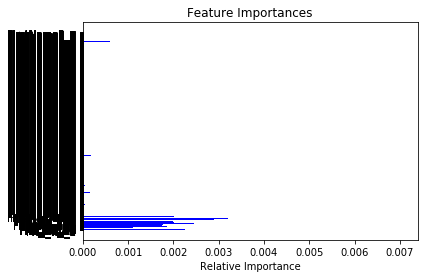

CPU times: user 12min 49s, sys: 11.8 s, total: 13min 1s
Wall time: 6min 26s


In [103]:
%%time
#放名字回來
#x_feature.append('地格')
# x_feature.append('外格')
# x_feature.append('總格')
print(x_feature)
y_feature = ['mgender']
gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,1)

In [106]:
%%time
#放名字回來
#x_feature.append('地格')
# x_feature.append('外格')
# x_feature.append('總格')

y_feature = ['mgender']
gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,1)

['FN1_wv_0', 'FN2_wv_0', 'FN1_wv_1', 'FN2_wv_1', 'FN1_wv_2', 'FN2_wv_2', 'FN1_wv_3', 'FN2_wv_3', 'FN1_wv_4', 'FN2_wv_4', 'FN1_wv_5', 'FN2_wv_5', 'FN1_wv_6', 'FN2_wv_6', 'FN1_wv_7', 'FN2_wv_7', 'FN1_wv_8', 'FN2_wv_8', 'FN1_wv_9', 'FN2_wv_9', 'FN1_wv_10', 'FN2_wv_10', 'FN1_wv_11', 'FN2_wv_11', 'FN1_wv_12', 'FN2_wv_12', 'FN1_wv_13', 'FN2_wv_13', 'FN1_wv_14', 'FN2_wv_14', 'FN1_wv_15', 'FN2_wv_15', 'FN1_wv_16', 'FN2_wv_16', 'FN1_wv_17', 'FN2_wv_17', 'FN1_wv_18', 'FN2_wv_18', 'FN1_wv_19', 'FN2_wv_19', 'FN1_wv_20', 'FN2_wv_20', 'FN1_wv_21', 'FN2_wv_21', 'FN1_wv_22', 'FN2_wv_22', 'FN1_wv_23', 'FN2_wv_23', 'FN1_wv_24', 'FN2_wv_24', 'FN1_wv_25', 'FN2_wv_25', 'FN1_wv_26', 'FN2_wv_26', 'FN1_wv_27', 'FN2_wv_27', 'FN1_wv_28', 'FN2_wv_28', 'FN1_wv_29', 'FN2_wv_29', 'FN1_wv_30', 'FN2_wv_30', 'FN1_wv_31', 'FN2_wv_31', 'FN1_wv_32', 'FN2_wv_32', 'FN1_wv_33', 'FN2_wv_33', 'FN1_wv_34', 'FN2_wv_34', 'FN1_wv_35', 'FN2_wv_35', 'FN1_wv_36', 'FN2_wv_36', 'FN1_wv_37', 'FN2_wv_37', 'FN1_wv_38', 'FN2_wv_38', 'FN1_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  1.0
Test Accuracy  ::  0.925018475357
女  水 0.5390625 0.4609375 FB
女 祐妤 0.703125 0.296875 FB
女 椲珹 0.64453125 0.35546875 FB
女 暐家 0.57421875 0.42578125 FB
男 妤周 0.2734375 0.7265625 FB
女 盈任 0.67578125 0.32421875 FB
女 修君 0.6875 0.3125 FB
男 棋安 0.35546875 0.64453125 FB
女 宣至 0.9140625 0.0859375 FB
女  尹 0.859375 0.140625 FB
女 鈺棠 0.7421875 0.2578125 FB
男 婕廷 0.43359375 0.56640625 FB
女 至絜 0.94140625 0.05859375 FB
男 于凡 0.4609375 0.5390625 FB
男 金宸 0.3046875 0.6953125 FB
男 吟軒 0.40234375 0.59765625 FB
女 彦积 0.921875 0.078125 FB
女  耶 0.59375 0.40625 FB
女 晉伊 0.62890625 0.37109375 FB
男 靖玄 0.4296875 0.5703125 FB
男 漢玄 0.2734375 0.7265625 FB
女 書鋐 0.80859375 0.19140625 FB
男 宥諭 0.32421875 0.67578125 FB
男 沅沅 0.3359375 0.6640625 FB
男 冰顏 0.48828125 0.51171875 FB
女 致頤 0.515625 0.484375 FB
男 胤齊 0.4921875 0.5078125 FB
女 立葳 0.5625 0.4375 FB
男 叡逸 0.19140625 0.80859375 FB
女 抹茶 0.68359375 0.31640625 FB
男 易十 0.36328125 0.63671875 FB
女  顿 0.8515625 0.1484375 FB
女 驛筑 0.7109375 0.2890625 FB
女 雙華 0.5546875 

男 柏蓉 0.21875 0.78125 FB
女 重汶 0.5078125 0.4921875 FB
女 郁殷 0.53125 0.46875 FB
女 莉嬿 1.0 0.0 FB
男 鬼龍 0.2265625 0.7734375 FB
女 壹月 0.734375 0.265625 FB
女 富張 0.5234375 0.4765625 FB
女 江衣 0.55859375 0.44140625 FB
女 順樺 0.91796875 0.08203125 FB
男 嫈廷 0.21484375 0.78515625 FB
女 鈞鏵 0.71484375 0.28515625 FB
女 纬庭 0.921875 0.078125 FB
男  後 0.37890625 0.62109375 FB
女 飄邈 0.51171875 0.48828125 FB
男 芫綸 0.40234375 0.59765625 FB
男 虹辰 0.44921875 0.55078125 FB
女 嘉鸣 0.53515625 0.46484375 FB
女 振瑄 0.515625 0.484375 Real name
女  涛 0.8515625 0.1484375 FB
女  羲 0.58203125 0.41796875 FB
女 松耘 0.64453125 0.35546875 FB
男 景榮 0.046875 0.953125 Real name
男 泳恩 0.41796875 0.58203125 FB
男 景吾 0.3046875 0.6953125 FB
男 令安 0.390625 0.609375 FB
女  奐 0.57421875 0.42578125 FB
女  望 0.8515625 0.1484375 FB
男 尉晨 0.328125 0.671875 FB
女 亞鑫 0.98828125 0.01171875 FB
女 立葳 0.5625 0.4375 FB
女  燚 0.8515625 0.1484375 FB
男 連忠 0.0 1.0 Real name
男 凱汝 0.4765625 0.5234375 FB
女 金蔥 0.53515625 0.46484375 FB
男 波利 0.49609375 0.50390625 FB
男 凱淯 0.4765625 0.

女 友溫 0.5390625 0.4609375 FB
女 庭榛 0.890625 0.109375 FB
女 君樺 0.66796875 0.33203125 FB
男 立豪 0.0 1.0 FB
女 豆乾 0.57421875 0.42578125 FB
男 淨強 0.2734375 0.7265625 FB
男 吉汪 0.41796875 0.58203125 FB
男 元賓 0.1875 0.8125 FB
女 籃球 0.69921875 0.30078125 FB
女 汶珊 0.9296875 0.0703125 FB
女 侑其 0.69921875 0.30078125 FB
男 得勤 0.046875 0.953125 FB
女 必夢 0.63671875 0.36328125 FB
女 金錚 0.52734375 0.47265625 FB
女 愷胡 0.5234375 0.4765625 FB
女 蓉林 0.5546875 0.4453125 FB
女 思玲 0.984375 0.015625 FB
男 詩平 0.34765625 0.65234375 FB
男 價水 0.47265625 0.52734375 FB
男 子聿 0.4609375 0.5390625 FB
男 品倫 0.3984375 0.6015625 Real name
男 泳辛 0.265625 0.734375 FB
男 個斳 0.36328125 0.63671875 FB
女 煜曦 0.640625 0.359375 FB
男 佑昌 0.1484375 0.8515625 FB
男 豆桑 0.41015625 0.58984375 FB
女 超然 0.91796875 0.08203125 Real name
男 玫鈞 0.33203125 0.66796875 FB
男 桂誠 0.16015625 0.83984375 FB
男 紫培 0.3984375 0.6015625 FB
女 攏共 0.5625 0.4375 FB
女 宙蓉 0.89453125 0.10546875 FB
男 予辰 0.4921875 0.5078125 FB
男 世雯 0.21875 0.78125 FB
女  彦 0.61328125 0.38671875 FB
男 明艳 0.00390

男 婕倫 0.31640625 0.68359375 FB
女 敏恩 0.5546875 0.4453125 FB
女  洧 0.5234375 0.4765625 FB
女 綠橙 0.51953125 0.48046875 FB
女 凌霄 0.54296875 0.45703125 Real name
女 青曄 0.52734375 0.47265625 FB
女 介盈 0.6015625 0.3984375 FB
女 諭昀 0.6015625 0.39453125 FB
女 橙瑢 0.6484375 0.34765625 FB
男 政萱 0.48828125 0.51171875 FB
女 翌炘 0.70703125 0.29296875 FB
女 伃慧 0.98828125 0.01171875 FB
男 君廷 0.23828125 0.76171875 FB
男 瑀辰 0.47265625 0.52734375 FB
男 譯晨 0.45703125 0.54296875 FB
男 芊文 0.4453125 0.55078125 FB
女 其燊 0.88671875 0.11328125 FB
女 嗚浪 0.88671875 0.11328125 FB
男 婌延 0.1015625 0.8984375 FB
男 柴犬 0.46484375 0.53515625 FB
男 尹承 0.28125 0.71875 FB
男 况舞 0.20703125 0.79296875 FB
女 艾晞 0.79296875 0.203125 FB
女 秀安 0.609375 0.38671875 FB
男 微明 0.26171875 0.734375 FB
女 娟許 0.68359375 0.3125 FB
女  衍 0.49609375 0.49609375 Real name
女 蘇含 0.7265625 0.265625 FB
男 姿宇 0.38671875 0.60546875 FB
女 用愛 0.73828125 0.2578125 FB
女 芊槮 0.734375 0.2578125 FB
女  淯 0.85546875 0.140625 FB
女 久淳 0.69921875 0.29296875 FB
女 孟椿 0.515625 0.4765625 FB
男 風陸 

In [73]:
FB_name_list = resampled_gender[ resampled_gender['userID'].apply(lambda x:type(x)!=float)].FirstName.tolist()

In [74]:
Real_name_list = resampled_gender[ resampled_gender['userID'].apply(lambda x:type(x)==float)].FirstName.tolist()

In [75]:
Only_in_FB_name_list= list(set(FB_name_list) - set(Real_name_list) )

In [77]:
print(len(Only_in_FB_name_list),Only_in_FB_name_list)

26757 ['宇宏', '正浩', '泉培', '聖富', '筱臻', '仲頤', '欣蕙', '子畫', '大巧', '芽芽', '鼎為', '到腰', '芷羽', '君寧', '云婷', '譽曜', '采婕', '丞希', '依齡', '特凜', '緯林', '葛格', '瀅好', '宜玟', '奕珊', '米雅', '如芯', '尚修', '旨健', '裘裘', '妍孜', '蕾兒', '吵了', '凱澤', '虹雯', '铜森', '瑀翼', ' 函', '官逸', '以宣', '小蝶', '怡農', '淳溱', '彥宸', '煜杰', '晉煜', '羽湘', '淑渝', '佳芮', '旼潔', '琨友', '湘辜', '宇嫻', '筱平', '孟瑄', '小薰', '曉余', '逸逸', '奕慈', '均隆', ' 深', '格升', '洸維', '于芬', '邱澤', '品融', '穎童', '熊雄', '怡頻', '育祥', '玉璇', '毓廷', '鼎俊', '又瑋', '嘉榆', '玄龍', '米奇', '志宸', '綵宜', '素汝', '英彰', '塏尚', '昱涵', '于芳', '杰少', '宛非', '翊翔', '吟夙', '思清', '偉洛', '詠昀', '佐晟', '秉紘', '敏綉', '啟揚', '冠杰', '定鏞', '裕展', '尹瑄', '芷婕', '義連', '肉圓', '辰宇', '薇如', '之名', '億情', '倫綱', '學鉦', '厚頤', '詠淇', '瑀霜', '軒綾', '冠佑', '宇丞', '祐欣', '群弦', '銘冠', '勁毅', '羅亞', '昕翰', '軒芷', '兆翔', '盈臻', '筱珺', '雯欣', '幸樓', '亭如', '廷廷', '惠宣', '嘉状', '曉雷', '慧柔', '榆倢', '昱愷', '靜妘', '有肜', ' 后', '水心', '祖荣', '舒芸', '瑄兒', '秀音', '心屏', '汶伶', '堃林', '冠瑩', '潘潘', '勢棠', '文逢', '聖爐', '意蓉', '嘉蔓', '羽周', '旻烜', '雅鈞', '逸捷', '葡萄', '緯緯', '郁宸', '耕綸', '高德', '雅棉', '琮堡', '泗鸿', '蔚穎', '喬涵

In [49]:
#'外格', '總格', '地格', '外格', '總格'
x_feature.remove('外格')
print(x_feature)

['FN1_wv_0', 'FN2_wv_0', 'FN1_wv_1', 'FN2_wv_1', 'FN1_wv_2', 'FN2_wv_2', 'FN1_wv_3', 'FN2_wv_3', 'FN1_wv_4', 'FN2_wv_4', 'FN1_wv_5', 'FN2_wv_5', 'FN1_wv_6', 'FN2_wv_6', 'FN1_wv_7', 'FN2_wv_7', 'FN1_wv_8', 'FN2_wv_8', 'FN1_wv_9', 'FN2_wv_9', 'FN1_wv_10', 'FN2_wv_10', 'FN1_wv_11', 'FN2_wv_11', 'FN1_wv_12', 'FN2_wv_12', 'FN1_wv_13', 'FN2_wv_13', 'FN1_wv_14', 'FN2_wv_14', 'FN1_wv_15', 'FN2_wv_15', 'FN1_wv_16', 'FN2_wv_16', 'FN1_wv_17', 'FN2_wv_17', 'FN1_wv_18', 'FN2_wv_18', 'FN1_wv_19', 'FN2_wv_19', 'FN1_wv_20', 'FN2_wv_20', 'FN1_wv_21', 'FN2_wv_21', 'FN1_wv_22', 'FN2_wv_22', 'FN1_wv_23', 'FN2_wv_23', 'FN1_wv_24', 'FN2_wv_24', 'FN1_wv_25', 'FN2_wv_25', 'FN1_wv_26', 'FN2_wv_26', 'FN1_wv_27', 'FN2_wv_27', 'FN1_wv_28', 'FN2_wv_28', 'FN1_wv_29', 'FN2_wv_29', 'FN1_wv_30', 'FN2_wv_30', 'FN1_wv_31', 'FN2_wv_31', 'FN1_wv_32', 'FN2_wv_32', 'FN1_wv_33', 'FN2_wv_33', 'FN1_wv_34', 'FN2_wv_34', 'FN1_wv_35', 'FN2_wv_35', 'FN1_wv_36', 'FN2_wv_36', 'FN1_wv_37', 'FN2_wv_37', 'FN1_wv_38', 'FN2_wv_38', 'FN1_

# 丟男女機率到FB和real name去

In [29]:
Real_name_df[Real_name_df.FirstName.apply(lambda x:len(x)==1)]

Empty DataFrame
Columns: [FirstName, LastName, gender, message, name, FN1, FN2, FN1_sonin, FN1_muin, FN2_sonin, FN2_muin, FN1_sonin_index, FN2_sonin_index, FN1_muin_index, FN2_muin_index, BirthYear, FN1_radical, FN2_radical, FN1_radical_index, FN2_radical_index, GuessedGender, 天格, 人格, 地格, 外格, 總格, FN12PY1, FN12PY2, FN12PY3, FN12PY4, FN12PY5, FN12PY6, FN12PY7, FN12PY8, FN12PY9, FN12PY10, BFN12P]
Index: []

[0 rows x 37 columns]

In [23]:
def one_hot_encodeing(df):
    df = pd.get_dummies(df, columns=["FN2_radical"])
    df = pd.get_dummies(df, columns=["FN1_radical"])
    df = pd.get_dummies(df, columns=["FN1_sonin"])
    df = pd.get_dummies(df, columns=["FN2_sonin"])
    df =  pd.get_dummies(df, columns=["FN1_muin"])
    df = pd.get_dummies(df, columns=["FN2_muin"])
    df = pd.get_dummies(df, columns=["FirstName1"])
    df = pd.get_dummies(df, columns=["FirstName2"])
    return df

In [24]:
print(len(FB_name_df.columns.values))

36


In [25]:
print(len(FB_name_df))

164822


In [26]:
part1 = FB_name_df.iloc[:60000]
part2 = FB_name_df.iloc[60000:120000]
part3 = FB_name_df.iloc[120000:]


In [44]:
part1 = Real_name_df.iloc[:60000]

In [57]:
part2 = Real_name_df.iloc[60000:120000]
part3 = Real_name_df.iloc[120000:180000]
part4 = Real_name_df.iloc[180000:240000]
part5 = Real_name_df.iloc[240000:]

In [35]:
a =[1,2,3,4,5]
print(a[:2])
print(a[2:4])

[1, 2]
[3, 4]


In [35]:
part3 = one_hot_encodeing(part3)

In [58]:
part5 = one_hot_encodeing(part5)

In [26]:
Real_name_df = one_hot_encodeing(Real_name_df)

In [36]:
#check_memory_usage():
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
object_size = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
for index,obj in enumerate(object_size):
    if index>10:
        break
    print('FileName:',obj[0],'FileSize:',obj[1]/1000000,'MB')

FileName: part2 FileSize: 1628.853171 MB
FileName: part1 FileSize: 1608.328043 MB
FileName: FB_name_df FileSize: 333.875789 MB
FileName: part3 FileSize: 296.469801 MB
FileName: predictions1 FileSize: 0.960112 MB
FileName: predictions2 FileSize: 0.960112 MB
FileName: x_feature FileSize: 0.063112 MB
FileName: Taiwan_LastName_List FileSize: 0.012096 MB
FileName: Taiwan_LastName_len1_List FileSize: 0.011184 MB
FileName: Error_character FileSize: 0.004096 MB
FileName: BalanceCascade FileSize: 0.001016 MB


In [37]:
def dummuy_complete(df,x_feature):
    c=0
    complete_list = []
    for f in x_feature:
        if f not in df.columns.values:
            print(f)
            complete_list.append(f)
            c+=1
    for f in complete_list:
        df[f] = 0
    print(c)
    return df
part3 = dummuy_complete(part3,x_feature)

FirstName1_丘
FirstName1_丝
FirstName1_並
FirstName1_为
FirstName1_乂
FirstName1_义
FirstName1_乓
FirstName1_乘
FirstName1_书
FirstName1_亂
FirstName1_事
FirstName1_互
FirstName1_五
FirstName1_亙
FirstName1_些
FirstName1_亜
FirstName1_交
FirstName1_亥
FirstName1_什
FirstName1_仪
FirstName1_仴
FirstName1_价
FirstName1_仿
FirstName1_伈
FirstName1_伎
FirstName1_伏
FirstName1_传
FirstName1_伴
FirstName1_伸
FirstName1_佈
FirstName1_住
FirstName1_佔
FirstName1_佟
FirstName1_佲
FirstName1_佷
FirstName1_佺
FirstName1_侒
FirstName1_侯
FirstName1_侶
FirstName1_俠
FirstName1_俶
FirstName1_俽
FirstName1_倅
FirstName1_候
FirstName1_倛
FirstName1_倡
FirstName1_倧
FirstName1_倨
FirstName1_倬
FirstName1_倸
FirstName1_值
FirstName1_假
FirstName1_偊
FirstName1_做
FirstName1_傅
FirstName1_傾
FirstName1_僖
FirstName1_僥
FirstName1_僪
FirstName1_價
FirstName1_儁
FirstName1_儂
FirstName1_儉
FirstName1_儲
FirstName1_儿
FirstName1_兌
FirstName1_兗
FirstName1_兟
FirstName1_兢
FirstName1_兩
FirstName1_兪
FirstName1_兴
FirstName1_具
FirstName1_兼
FirstName1_冀
FirstName1_冊
FirstName1_冏

FirstName2_嚎
FirstName2_嚕
FirstName2_嚜
FirstName2_囝
FirstName2_囡
FirstName2_困
FirstName2_固
FirstName2_園
FirstName2_土
FirstName2_圩
FirstName2_圭
FirstName2_坂
FirstName2_坏
FirstName2_坣
FirstName2_坦
FirstName2_坻
FirstName2_垂
FirstName2_型
FirstName2_垻
FirstName2_埔
FirstName2_埕
FirstName2_域
FirstName2_埤
FirstName2_執
FirstName2_堆
FirstName2_堙
FirstName2_堦
FirstName2_堪
FirstName2_報
FirstName2_堺
FirstName2_塀
FirstName2_塋
FirstName2_塎
FirstName2_塗
FirstName2_塘
FirstName2_塞
FirstName2_塡
FirstName2_塦
FirstName2_填
FirstName2_墀
FirstName2_墇
FirstName2_墘
FirstName2_墩
FirstName2_墻
FirstName2_壁
FirstName2_壇
FirstName2_壐
FirstName2_壞
FirstName2_壢
FirstName2_壩
FirstName2_夭
FirstName2_失
FirstName2_奐
FirstName2_契
FirstName2_奚
FirstName2_奛
FirstName2_奢
FirstName2_奧
FirstName2_奮
FirstName2_女
FirstName2_奶
FirstName2_妁
FirstName2_妅
FirstName2_妊
FirstName2_妌
FirstName2_妠
FirstName2_妶
FirstName2_妻
FirstName2_姀
FirstName2_始
FirstName2_姑
FirstName2_姣
FirstName2_姫
FirstName2_姳
FirstName2_娉
FirstName2_娓
FirstName2_娕

FirstName2_菽
FirstName2_萃
FirstName2_萤
FirstName2_萮
FirstName2_萸
FirstName2_萼
FirstName2_著
FirstName2_葱
FirstName2_葴
FirstName2_葸
FirstName2_蒎
FirstName2_蒐
FirstName2_蒓
FirstName2_蒞
FirstName2_蒲
FirstName2_蒸
FirstName2_蓀
FirstName2_蓂
FirstName2_蓄
FirstName2_蓋
FirstName2_蓒
FirstName2_蓝
FirstName2_蓴
FirstName2_蔗
FirstName2_蔭
FirstName2_蕃
FirstName2_蕉
FirstName2_蕖
FirstName2_蕣
FirstName2_蕤
FirstName2_薊
FirstName2_薌
FirstName2_薐
FirstName2_薔
FirstName2_薙
FirstName2_薫
FirstName2_藏
FirstName2_藕
FirstName2_藜
FirstName2_藤
FirstName2_藹
FirstName2_藻
FirstName2_蘊
FirstName2_蘑
FirstName2_蘚
FirstName2_蘢
FirstName2_蘩
FirstName2_虒
FirstName2_處
FirstName2_虞
FirstName2_虢
FirstName2_虧
FirstName2_虫
FirstName2_虬
FirstName2_虯
FirstName2_蚧
FirstName2_蛋
FirstName2_蛙
FirstName2_蜀
FirstName2_蜓
FirstName2_蝓
FirstName2_蝕
FirstName2_蝗
FirstName2_蝟
FirstName2_蟢
FirstName2_蟬
FirstName2_蟹
FirstName2_蟻
FirstName2_蟾
FirstName2_蠔
FirstName2_蠡
FirstName2_血
FirstName2_衎
FirstName2_術
FirstName2_衞
FirstName2_表
FirstName2_衾

In [38]:
#predictions1 = gender_predicton_model.predict_proba(part1[ x_feature ])
predictions3 = gender_predicton_model.predict_proba(part3[ x_feature ])

# predictions5 = gender_predicton_model.predict_proba(part5[ x_feature ])

In [39]:
prediction_female_list = []
prediction_male_list = []
for p in predictions1:
    prediction_female_list.append(p[0])
    prediction_male_list.append(p[1])

for p in predictions2:
    prediction_female_list.append(p[0])
    prediction_male_list.append(p[1])

for p in predictions3:
    prediction_female_list.append(p[0])
    prediction_male_list.append(p[1])

# for p in predictions4:
#     prediction_female_list.append(p[0])
#     prediction_male_list.append(p[1])

# for p in predictions5:
#     prediction_female_list.append(p[0])
#     prediction_male_list.append(p[1])

In [64]:
Real_name_df['Female_prob'] =prediction_female_list
Real_name_df['Male_prob'] = prediction_male_list

In [40]:
FB_name_df['Female_prob'] =prediction_female_list
FB_name_df['Male_prob'] = prediction_male_list
FB_name_df

name message             userID LastName FirstName   FN1   FN2  \
0       張家琪    1984   1216132381818443        張        家琪    29   384   
1       涂銘峰    1983   1381624175192111        涂        銘峰    44   233   
2       歐昱成    1980   1442601205791441        歐        昱成    97   113   
3       陳識中    1981   1326044517484585        陳        識中  1953   321   
4       蕭愷煊    1982   1618333278236754        蕭        愷煊   430  1405   
5       張耕耀    1983   1592555917430952        張        耕耀  1679    12   
6       胡小芳    1984   1384729524883556        胡        小芳    53   246   
7       張朝棟    1982   1401915713162397        張        朝棟   863  1281   
8       卓裕偉    1984   1850214341671212        卓        裕偉   493    56   
9        唐妍    1984   1476513412441945        唐         妍    -1   301   
10      林健銘    1983   1709674789050490        林        健銘   334    44   
11      林羣羣    1983    276663382803715        林        羣羣  2674  2674   
12      陳冠彰    1982  10210885207438009        陳        冠彰   164   692   
13      楊菁菁    1980   1674071469271867        楊        菁菁   137   137   
14      潘芷薰    1982   1432393790145254        潘        芷薰   192   913   
15      江宜倫    1984   1484663904909887        江        宜倫    16   510   
16      黃致誠    1984   1511595995526318        黃        致誠   444    73   
17      李昆泉    1983    629163233941307        李        昆泉    66   845   
18      曾志偉    1982    505839943137122        曾        志偉    68    56   
19       柯妮    1982    424110021259092        柯         妮    -1   710   
20      李慶長    1981   1371568382864451        李        慶長   269   332   
21      徐嘉祥    1984   1847086658650071        徐        嘉祥     6   165   
22      曾哲也    1981   1655562364454356        曾        哲也   167   958   
23      蔡怡玲    1982   1097257827045501        蔡        怡玲   250   207   
24      劉育豪    1984  10207840379521241        劉        育豪   108    60   
25      蕭淑惠    1981    826306230876858        蕭        淑惠   348   106   
26      陳明志    1984   1422850191070437        陳        明志   159    68   
27      林庚翰    1980   1705546102793645        林        庚翰  1171   257   
28      謝政彬    1984   1498133746884336        謝        政彬   285   544   
29      蔡慶堂    1981   1760723833944871        蔡        慶堂   269   748   
...     ...     ...                ...      ...       ...   ...   ...   
164792  楊秉叡    1978   1958691217679341        楊        秉叡   307  1164   
164793  李沂靜    1976   1379001755551699        李        沂靜   460   217   
164794  陳宏名    1978   1963076180374955        陳        宏名    27   112   
164795  童心緣    1977    494892300890652        童        心緣   228   871   
164796  張立恆    1978    516607078691631        張        立恆    83    11   
164797  洪志鵬    1979   1603410919703236        洪        志鵬    68   718   
164798  廖勝基    1977    271563533333536        廖        勝基   156  1254   
164799  王慧慧    1979   1838901339460143        王        慧慧   124   124   
164800  陳冠兆    1977   1443902165701036        陳        冠兆   164   827   
164801  李榮嵐    1975   1667618006590349        李        榮嵐     4   633   
164802  李筱茹    1975   1909520312707633        李        筱茹    23   107   
164803  蕭妤珍    1979    502161140122065        蕭        妤珍   193   184   
164804  陳麗如    1978   1717084871921079        陳        麗如   203   177   
164805   溫楨    1978    373503576402432        溫         楨    -1   740   
164806  陳乃菁    1978   1566179490070807        陳        乃菁   749   137   
164807   加士    1978   1610447205642477        加         士    -1   130   
164808  白翔安    1979   1606259309397166        白        翔安   289    20   
164809  蔡永康    1977   1226207097484022        蔡        永康   550    37   
164810  朱阩鳳    1977   1634532986559854        朱        阩鳳  3740   598   
164811  艾莉絲    1976    508873899472825        艾        莉絲   457  1133   
164812  邱小菁    1978   1821406404543912        邱        小菁    53   137   
164813   吳晴    1976    907904036039528        吳         晴    -1    24   
164814  施昱成    1975   1467147570047305        施        昱成    97  

In [70]:
save_df_to_csv(Real_name_df , './data_output/final/prob/' ,'resampled_Real_data_df')

In [43]:
save_df_to_csv(FB_name_df , './data_output/final/prob/' ,'resampled_FB_data_df')

In [65]:
Real_name_df

FirstName LastName gender message name   FN1   FN2 FN1_sonin FN1_muin  \
0             秀珠        吳    NaN    1947  吳秀珠    70   596         x       iù   
1             豐博        林    NaN    1945  林豐博   277    72         f      ēng   
2             義勝        康    1.0    1945  康義勝   650   156         y        ì   
3              麗        吳    0.0    1946   吳麗    -1   203        -1       -1   
4             淡浪        張    NaN    1948  張淡浪  1008   104         d       àn   
5             世慶        林    1.0    1947  林世慶   537   269        sh        ì   
6             秀藝        林    NaN    1946  林秀藝    70   867         x       iù   
7             麗凰        陳    0.0    1949  陳麗凰   203  1443         l        ì   
8             翰祥        袁    NaN    1945  袁翰祥   257   165         h       àn   
9              林        吳    1.0    1946   吳林    -1    96        -1       -1   
10            惠芹        梅    NaN    1945  梅惠芹   106   645        hu        ì   
11            明華        康    0.0    1947  康明華   159   123         m      íng   
12            鴻錦        方    1.0    1948  方鴻錦   222   458         h      óng   
13            培珍        李    NaN    1945  李培珍    58   184         p       éi   
14            竹玲        陳    0.0    1946  陳竹玲   621   207        zh        ú   
15             南       曾江    NaN    1946  曾江南    -1   743        -1       -1   
16            昭祥        吳    NaN    1949  吳昭祥   462   165        zh       āo   
17            垂光        林    NaN    1948  林垂光  2415   413       chu        í   
18            文山        楊    NaN    1945  楊文山    28   447         w       én   
19            燿達        陳    NaN    1945  陳燿達  1232   361         y       ào   
20            漢清        許    NaN    1947  許漢清   575   195         h       àn   
21            天聲        古    NaN    1949  古天聲   643   825         t      iān   
22            宇立        孫    1.0    1948  孫宇立    10    83         y        ǔ   
23            兩才        劉    NaN    1947  劉兩才  1845  1151         l     iǎng   
24            玉儀        崔    NaN    1949  崔玉儀   211     7         y        ù   
25            天順        林    1.0    1946  林天順   643   796         t      iān   
26            忠國        薛    1.0    1948  薛忠國    32   436        zh      ōng   
27            照容        邱    0.0    1947  邱照容  1276   187        zh       ào   
28            慈欣        郭    0.0    1946  郭慈欣   121    78         c        í   
29            瑩瑩        陳    0.0    1949  陳瑩瑩   658   658         y      íng   
...          ...      ...    ...     ...  ...   ...   ...       ...      ...   
320750        志豐        陳    NaN    1974  陳志豐    68   277        zh        ì   
320751        東敏        陳    NaN    1974  陳東敏   219    59         d      ōng   
320752        健寶        陳    NaN    1974  陳健寶   334   513         j      iàn   
320753        志弦        林    NaN    1974  林志弦    68  1366        zh        ì   
320754        雅玲        陳    NaN    1974  陳雅玲   310   207         y        ǎ   
320755        淑麗        許    NaN    1974  許淑麗   348   203        sh        ú   
320756        麗珍        陳    NaN    1974  陳麗珍   203   184         l        ì   
320757        淑屏        林    NaN    1974  林淑屏   348  1154        sh        ú   
320758        淑娟        林    NaN    1974  林淑娟   348   329        sh        ú   
320759        素月        吳    NaN    1974  吳素月   455   706         s        ù   
320760        鈺霜        許    NaN    1974  許鈺霜   320   212         y        ù   
320761        巧玲        陳    NaN    1974  陳巧玲   178   207         q      iǎo   
320762        雅莉        陳    NaN    1974  陳雅莉   310   457         y        ǎ   
320763        明月        陳    NaN    1974  陳明月   159   706         m      íng   
320764        秀蘭        陳    NaN    1974  陳秀蘭    70  1329         x       iù   
320765        慧珠        曾    NaN    1974  曾慧珠   124   596        hu        ì   
320766        宜甄        陳    NaN    1974  陳宜甄    16   573         y        í   
320767        滿足        陳    NaN    1974  陳滿足  2022  2124         m       ǎn   
320768 

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  0.998314285714
Test Accuracy  ::  0.914333333333
Feature Importances
['FN2_muin_None', 'FN2_muin_ià', 'FN2_muin_iàn', 'FN2_muin_iàng', 'FN2_muin_iào', 'FN2_muin_iá', 'FN2_muin_ián', 'FN2_muin_iáng', 'FN2_muin_iáo', 'FN2_muin_iè', 'FN2_muin_ié', 'FN2_muin_ióng', 'FN2_muin_iù', 'FN2_muin_iú', 'FN2_muin_iā', 'FN2_muin_iān', 'FN2_muin_iāng', 'FN2_muin_iāo', 'FN2_muin_iē', 'FN2_muin_iě', 'FN2_muin_iū', 'FN2_muin_iǎn', 'FN2_muin_iǎng', 'FN2_muin_iǎo', 'FN2_muin_iǒng', 'FN2_muin_iǔ', 'FN2_muin_uà', 'FN2_muin_uài', 'FN2_muin_uàn', 'FN2_muin_uàng', 'FN2_muin_uá', 'FN2_muin_uái', 'FN2_muin_uán', 'FN2_muin_uáng', 'FN2_muin_uè', 'FN2_muin_ué', 'FN2_muin_uò', 'FN2_muin_uó', 'FN2_muin_uā', 'FN2_muin_uāi', 'FN2_muin_uān', 'FN2_muin_uāng', 'FN2_muin_uē', 'FN2_muin_uě', 'FN2_muin_uō', 'FN2_muin_uǎi', 'FN2_muin_uǎn', 'FN2_muin_uǎng', 'FN2_muin_uǒ', 'FN2_muin_à', 'FN2_muin_ài', 'FN2_muin_àn', 'FN2_muin_àng', 'FN2_muin_ào', 'FN2_muin_á', 'FN2_muin_ái', 'FN2_muin_án', 'FN2_muin_áng', 'FN

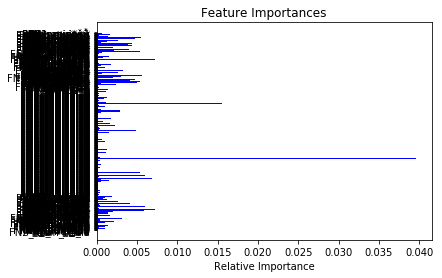

In [68]:
y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(df,x_feature,y_feature,1)

In [99]:
gender_predicton_model.feature_importances_[0]
a = gender_predicton_model.feature_importances_.tolist()
max(a)

0.02884823052867443

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  1.0
Test Accuracy  ::  0.938193950665
Feature Importances
['FN2_radical_一', 'FN2_radical_丨', 'FN2_radical_丶', 'FN2_radical_丿', 'FN2_radical_乙', 'FN2_radical_亅', 'FN2_radical_二', 'FN2_radical_亠', 'FN2_radical_人', 'FN2_radical_儿', 'FN2_radical_兀', 'FN2_radical_入', 'FN2_radical_八', 'FN2_radical_冂', 'FN2_radical_冖', 'FN2_radical_冫', 'FN2_radical_几', 'FN2_radical_凵', 'FN2_radical_刀', 'FN2_radical_力', 'FN2_radical_勹', 'FN2_radical_匕', 'FN2_radical_匚', 'FN2_radical_匸', 'FN2_radical_十', 'FN2_radical_卜', 'FN2_radical_卩', 'FN2_radical_厂', 'FN2_radical_厶', 'FN2_radical_又', 'FN2_radical_口', 'FN2_radical_囗', 'FN2_radical_土', 'FN2_radical_士', 'FN2_radical_夂', 'FN2_radical_夊', 'FN2_radical_夕', 'FN2_radical_大', 'FN2_radical_女', 'FN2_radical_子', 'FN2_radical_宀', 'FN2_radical_寸', 'FN2_radical_小', 'FN2_radical_尢', 'FN2_radical_尸', 'FN2_radical_屮', 'FN2_radical_山', 'FN2_radical_巛', 'FN2_radical_工', 'FN2_radical_己', 'FN2_radical_巾', 'FN2_radical_干', 'FN2_radical_幺', 'FN2_radical_广', 'FN2

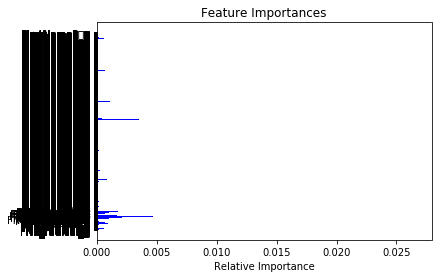

In [105]:
#x_feature = ['FN1_radical_index_cat','FN2_radical_index_cat']
x_feature.append('地格')
y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,1)

In [ ]:
%%time 

y_feature = ['mgender']
gender_predicton_model = basic_RFClassifier(resampled_gender,x_feature,y_feature,1)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  1.0
Test Accuracy  ::  0.935048952579
Feature Importances
['FN2_radical_一', 'FN2_radical_丨', 'FN2_radical_丶', 'FN2_radical_丿', 'FN2_radical_乙', 'FN2_radical_亅', 'FN2_radical_二', 'FN2_radical_亠', 'FN2_radical_人', 'FN2_radical_儿', 'FN2_radical_兀', 'FN2_radical_入', 'FN2_radical_八', 'FN2_radical_冂', 'FN2_radical_冖', 'FN2_radical_冫', 'FN2_radical_几', 'FN2_radical_凵', 'FN2_radical_刀', 'FN2_radical_力', 'FN2_radical_勹', 'FN2_radical_匕', 'FN2_radical_匚', 'FN2_radical_匸', 'FN2_radical_十', 'FN2_radical_卜', 'FN2_radical_卩', 'FN2_radical_厂', 'FN2_radical_厶', 'FN2_radical_又', 'FN2_radical_口', 'FN2_radical_囗', 'FN2_radical_土', 'FN2_radical_士', 'FN2_radical_夂', 'FN2_radical_夊', 'FN2_radical_夕', 'FN2_radical_大', 'FN2_radical_女', 'FN2_radical_子', 'FN2_radical_宀', 'FN2_radical_寸', 'FN2_radical_小', 'FN2_radical_尢', 'FN2_radical_尸', 'FN2_radical_屮', 'FN2_radical_山', 'FN2_radical_巛', 'FN2_radical_工', 'FN2_radical_己', 'FN2_radical_巾', 'FN2_radical_干', 'FN2_radical_幺', 'FN2_radical_广', 'FN2

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/home/john/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train Accuracy ::  0.998314285714
Test Accuracy  ::  0.8988
Feature Importances
['FN1_sonin_index', 'FN2_sonin_index', 'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index', 'FN2_radical_index']
[ 0.1170408   0.12403768  0.16935835  0.17644781  0.16488071  0.24823464]


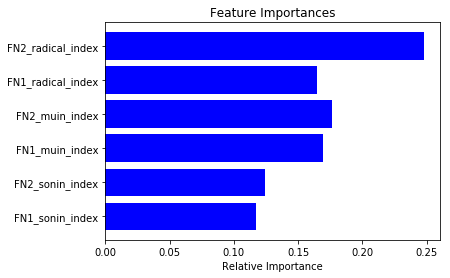

In [69]:
x_feature = ['FN1_sonin_index', 'FN2_sonin_index',
       'FN1_muin_index', 'FN2_muin_index', 'FN1_radical_index',
       'FN2_radical_index']
y_feature = ['mgender']

gender_predicton_model = basic_RFClassifier(df,x_feature,y_feature,1)

In [105]:
def basic_RFClassifier(data_df,x_feature,y_feature,Validation_times):

    #N fold cross-validation
    Train_accuracy_score=0
    Test_accuracy_score=0
    
    importances_list = []
    for i in range(Validation_times):
        train_x, test_x, train_y, test_y = split_dataset(data_df, 0.7, x_feature, y_feature)
        test_index = test_y.index
        test_name_list = data_df.loc[test_index].FirstName.tolist()
        test_gender_list =data_df.loc[test_index].mgender.tolist()
        # Create random forest classifier instance
        trained_model = random_forest_classifier(train_x, train_y)


        predictions = trained_model.predict(test_x)
        predictions_prob = trained_model.predict_proba(test_x)
        # Train and Test Accuracy
        if(Validation_times!=1):
            print('Run times:',i+1)
        print ("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x)))
        print ("Test Accuracy  :: ", accuracy_score(test_y, predictions))
        #print (" Confusion matrix\n ", confusion_matrix(test_y, predictions))
        
        for i in range(len(predictions)):
            if predictions[i]!=test_gender_list[i]:
                if predictions[i]==1 or  predictions[i]=='1':
                    guessed_gender = '男'
                else:
                    guessed_gender = '女'
                if test_name_list[i] in Only_in_FB_name_list:
                    come_from = 'FB'
                else:
                    come_from = 'Real name'
                print(guessed_gender,test_name_list[i],predictions_prob[i][0],predictions_prob[i][1],come_from)
                
        Train_accuracy_score+=accuracy_score(train_y, trained_model.predict(train_x))
        Test_accuracy_score+= accuracy_score(test_y, predictions)
#         calculate_error( predictions, test_y )
        
    
        #validate_error( predictions,data_df, test_y,test_x )
        
        importances = trained_model.feature_importances_
        importances_list.append(importances)
        #indices = np.argsort(importances)
#         print('Feature Importances')
 
#         print(x_feature)
#         print(importances)
#         plt.title('Feature Importances')
#         plt.barh(range(len(importances)), importances, color='b', align='center')
#         plt.yticks(range(len(importances)), x_feature) ## removed [indices]
#         plt.xlabel('Relative Importance')
#         plt.show()
        
    if(Validation_times!=1):
        Train_accuracy_score/=Validation_times
        Test_accuracy_score/=Validation_times
        print ("Average Train Accuracy :: ", Train_accuracy_score)
        print ("Average Test Accuracy  :: ",Test_accuracy_score)
        print(importances_list)
    return trained_model